In [2]:
import sklearn
import numpy
import math
import time
print('The scikit-learn verison is {}.'.format(sklearn.__version__))
print('The numpy versions i {}.'.format(numpy.__version__))
# lt. Paper: Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in 
# Machine Learning ist nur RandomOverSampler für den Multi-class-Fall anwendbar
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, KMeansSMOTE, SVMSMOTE

import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler


from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score 

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.preprocessing import LabelBinarizer

from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels

from skimage import exposure, feature, transform
import pickle as pkl
from sklearn.decomposition import PCA

from itertools import product
from itertools import cycle

import seaborn as sns

import time
import timeit
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import csv
import pandas as pd
# zum Visualisieren der Daten mithilfe von PCA
from mpl_toolkits.mplot3d import Axes3D

# jupyter notebooks als Module importieren
!pip install import-ipynb
import import_ipynb
import save_load
from save_load import load_hog_features, load_vgg16_features, load_labels, save_trained_model_as_pkl, load_trained_model_from_pkl, save_as_csv, read_csv, make_subsets_training_data_A
import tools
from tools import roc_auc_score_multiclass, roc_auc_score_single_class, scale_train_test_data, scale_train_test_data_without_std, scale_train_test_data_without_mean

The scikit-learn verison is 0.21.3.
The numpy versions i 1.15.4.


Using TensorFlow backend.


importing Jupyter notebook from save_load.ipynb
Hallo angekommen
importing Jupyter notebook from tools.ipynb


In [3]:
def load_hog_features(path_train):
    X_hog = np.load(path_train)
    return X_hog

def load_labels(path_train):
    y_label = np.load(path_train)
    return y_label

'''
speichert trainierte Modelle bzw. Ergebnisse wiederholter Grid Search Anwendungen als Pickle-Datei.
Diese gespeicherten Modelle können mit Funktion   load_trained_model_from_pkl(name)
'''

def save_trained_model_as_pkl(model, filename):
    with open(filename, 'wb') as file:
        pkl.dump(model, file)  
        
'''
lädt bereits trainiertes, als Pickle-Datei gespeichertes Modell bzw. Ergebnisse wiederholter
Grid Search Anwendungen
'''
def load_trained_model_from_pkl(filename):
    with open(filename, 'rb') as file:
        new_model=pkl.load(file)
    return new_model

'''
speichern und lesen von CSV-Dateien
'''
def save_as_csv(list,path,name):
    path = path+name    
    with open(path, "w") as file:
        csv_wr = csv.writer(file)
        csv_wr.writerows(list)
        
def read_csv(path):
    read_file = []
    with open(path, "r") as file:
        csv_r = csv.reader(file)
        for row in csv_r:
            if row:
                read_file.append(row)
    return read_file

In [4]:
# in Anlehnung an:   https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def roc_auc_score_multiclass(y_test, y_pred, average='macro'):    
    labelBin = LabelBinarizer()
    labelBin.fit(y_test)    
    y_test = labelBin.transform(y_test)
    y_pred = labelBin.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
    
    
'''
Roc_Auc_score für die einzelnen Klassen berechnen
'''
def roc_auc_score_single_class(y_test, y_pred, average = "macro"):
    # Menge der einzelnen Klassen erstellen
    single_classes = set(y_test)
    roc_aucs = {}
    for cl in single_classes:
        #Liste der restlichen Klassen erstellen
        remain_classes = [x for x in single_classes if x != cl]

        # aktuelle Klasse mit 1 markieren und alle anderen Klassen mit 0
        y_test_roc = [0 if x in remain_classes else 1 for x in y_test]
        y_pred_roc = [0 if x in remain_classes else 1 for x in y_pred]

        # roc_auc_score berechnen
        roc_auc = roc_auc_score(y_test_roc, y_pred_roc, average = average)
        roc_aucs[cl] = roc_auc

    return roc_aucs

#lr_roc_auc_multiclass = roc_auc_score_single_class(y_test, pred)
#print(lr_roc_auc_multiclass)

In [5]:
def plot_confusion_matrix_norm(y_test, y_pred, title):        
    classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
              '19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
              '36','37','38','39','40','41','42']    
    cm = confusion_matrix(y_test, y_pred)    
    np.set_printoptions(precision=3)    
    #plt.figure(figsize=(4.5*2, 2.5*2))
    #plt.figure(figsize=(9*2, 5*2))
    #plt.figure(figsize=(13.5*2, 7.5*2))
    
    fig = plt.figure(figsize=(18*2, 10*2))
    #fig.suptitle('Confusion matrix ', fontsize=20, fontweight='medium')
    normalize=True    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix  '+title, fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):            
    #for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)
    plt.tight_layout()
    plt.show()
    return fig

In [6]:
# Classification report ausgeben
def classif_report(y_te, y_pred):    
    print(classification_report(y_te, y_pred))   

In [7]:
'''
erstellen unterschiedlicher Trainingsmengen aus 39.209 Trainingsdaten
Datensätze werden zufällig aber reproduzierbar durch random_state=0
unter Berücksichtigung der prozentualen Anteile der Daten in den
einzelnen Klassen, erstellt.
Tracks werden nicht berücksichtigt
'''
def make_training_subsets_A(X_tr, y_tr):
    # Trainingsdaten mischen, da diese ursprünglich sortiert vorliegen
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=42)    
    # Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_2, y_tr_20000, y_te_2 = train_test_split(
        X_tr, y_tr, random_state = 0, train_size=20000/39209, stratify=y_tr)
    # Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_3, y_tr_10000, y_te_3 = train_test_split(
        X_tr_20000, y_tr_20000, random_state = 0, train_size=1/2, stratify=y_tr_20000)
    # Trainingsmenge mit 5.000 Bilder erzeugen   
    X_tr_5000, X_te_4, y_tr_5000, y_te_4 = train_test_split(
        X_tr_10000, y_tr_10000, random_state = 0, train_size=1/2, stratify=y_tr_10000)
     #Trainingsmenge mit 2.000 Bilder erzeugen   
    X_tr_2000, X_te_5, y_tr_2000, y_te_5 = train_test_split(
        X_tr_5000, y_tr_5000, random_state = 0, train_size=2/5, stratify=y_tr_5000)
     #Trainingsmenge mit 1.000 Bilder erzeugen   
    X_tr_1000, X_te_6, y_tr_1000, y_te_6 = train_test_split(
        X_tr_2000, y_tr_2000, random_state = 0, train_size=1/2, stratify=y_tr_2000)
    # Trainingsmenge mit 500 Bilder erzeugen   
    X_tr_500, X_te_7, y_tr_500, y_te_7 = train_test_split(
        X_tr_1000, y_tr_1000, random_state = 0, train_size=1/2, stratify=y_tr_1000)
    # Trainingsmenge mit 200 Bilder erzeugen   
    X_tr_200, X_te_8, y_tr_200, y_te_8 = train_test_split(
        X_tr_500, y_tr_500, random_state = 0, train_size=2/5, stratify=y_tr_500)
    return X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200
    

In [8]:
def plot_confusion_matrix_norm(y_test, y_pred, title):        
    classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
              '19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
              '36','37','38','39','40','41','42']    
    cm = confusion_matrix(y_test, y_pred)    
    np.set_printoptions(precision=3)    
    #plt.figure(figsize=(4.5*2, 2.5*2))
    #plt.figure(figsize=(9*2, 5*2))
    #plt.figure(figsize=(13.5*2, 7.5*2))
    
    fig = plt.figure(figsize=(18*2, 10*2))
    #fig.suptitle('Confusion matrix ', fontsize=20, fontweight='medium')
    normalize=True    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix  '+title, fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):            
    #for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)
    plt.tight_layout()
    plt.show()
    return fig

In [9]:
'''
Trainings- und Testdaten mit dem StandardScaler skalieren
'''
def scale_train_test_data(X_tr, X_te):
    scaler = StandardScaler()
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
    
    
'''
Trainings- und Testdaten mit dem StandardScaler skalieren
ohne std
'''
def scale_train_test_data_without_std(X_tr, X_te):
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
    
'''
Trainings- und Testdaten mit dem StandardScaler skalieren
ohne std
'''
def scale_train_test_data_without_mean(X_tr, X_te):
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_tr)
    X_tr_trans = scaler.transform(X_tr)
    X_te_trans = scaler.transform(X_te)
    return X_tr_trans, X_te_trans
    
    
'''
Oversampling der Minderheitsklasse
'''
def make_smote_minority(X, y):
    smote = SMOTE('minority', k_neighbors=1, random_state=0)
    X_smote, y_smote = smote.fit_sample(X,y)
    return X_smote, y_smote    

In [10]:
'''
LinearSVC trainieren
seed = Saatpunkt für Numpy-Zufallsgenerator
number = Anzahl der Trainingsdaten
C = Wert des Parameters C
scale = Daten skalieren oder nicht, wenn scale=0 dann nicht skalieren
                                    wenn scale=1 dann skalieren ohne std
                                    wenn scale=2 dann skalieren mit std
                                    wenn scale=3 dann skalieren ohne mean
smote = 0, dann ohne SMOTE
smote = 1, dann mit SMOTE mit minority

class_weight:    class_weight='balanced', class_weight=None
'''
'''
SVC mit RBF-Kernel trainieren, mit StandardScaler
'''
def train_RBF_SVC(X_tr, X_te, y_tr, y_te, seed, number, C, gamma, scale, smote, decision_function, 
                  class_weight, front_path, end_path, feature):
    # Seed-Punkt setzen für Reproduzierbarkeit
    #seed = seed
    #np.random.seed(seed)
    # Pfad für speichern des Modells, Confusion matrix, Metriken
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random 0/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random B/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/rbf/"+number+"/NEU seed 7 random C/1terDL/"
    path = front_path+"/"+number+"/"+end_path+"/"
    
    # Liste in welcher die berechneten Metriken gespeichert werden
    metrics = []
    # Liste für Trainingszeiten
    time_list = []
    #Liste für Testzeiten
    time_list_test = []
    
    if smote == 1:
        print("Smote minority")
        X_tr, y_tr = make_smote_minority(X_tr, y_tr)
    
     # Trainings- und Testdaten skalieren
    if scale == 1:
        print("Daten skalieren ohne std")
        X_tr, X_te = scale_train_test_data_without_std(X_tr, X_te)
    if scale == 2:
        print("Daten skalieren")
        X_tr, X_te = scale_train_test_data(X_tr, X_te)
    if scale == 3:
        print("Daten skalieren ohne mean")
        scale_train_test_data_without_mean(X_tr, X_te)
        
    #if smote == 1:
     #   print("Smote minority")
      #  X_tr, y_tr = make_smote_minority(X_tr, y_tr)
 
    # LinearSVC mit den skalierten Daten trainieren und speichern
    start = time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    
    #rbfSVC = SVC(C=C, gamma='auto_deprecated')
    rbfSVC = SVC(C=C, gamma=gamma, class_weight=class_weight, decision_function_shape= decision_function, random_state=seed)
    rbfSVC.fit(X_tr, y_tr)
    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
                
    end_per_sample = end/int(number)
    end2_per_sample = end2/int(number)
    end3_per_sample = end3/int(number)
    # Trainingszeiten speichern
    time_list.append([end,end2,end3])    
    time_list.append([end_per_sample, end2_per_sample, end3_per_sample])
    save_as_csv(time_list, path, 'Trainingszeiten.csv')
    
    # trainiertes Modell speichern
    save_trained_model_as_pkl(rbfSVC, path+"RBF_SVC_"+number+"_"+feature)    
                              
    # Vorhersage machen und speichern
    y_pred = rbfSVC.predict(X_te)    
    np.save(path+"y_pred_label.npy", y_pred) 
    # zusätzlich Label der Testdaten speichern, auch wenn eigentlich überflüssig
    np.save(path+"y_test_label.npy", y_te)
                                  
    # Metriken berechnen und speichern                          
    acc = accuracy_score(y_te, y_pred)                  
    prec = precision_score(y_te, y_pred, average='macro')    
    rec = recall_score(y_te, y_pred, average='macro')   
    f1 = f1_score(y_te, y_pred, average='macro') 
    roc = roc_auc_score_multiclass(y_te, y_pred, average='macro')
    kappa = cohen_kappa_score(y_te, y_pred)
    metrics.append([acc,prec,rec,f1,roc,kappa])
    save_as_csv(metrics,path,'metrics.csv')  
    
    roc_single_class = roc_auc_score_single_class(y_te, y_pred, average='macro')
    np.save(path+"roc_auc_score_single_class.npy", roc_single_class)
    
    # Confusion Matrix erstellen und speichern
    title = '(SVC rbf '+number+' C='+str(C)+')'    
    cm = plot_confusion_matrix_norm(y_te, y_pred, title)       
    cm.savefig(path+"Confusion_matrix.png")    
    
    # Performanz mit Testdaten testen und Klassifikationszeit speichern
    start4 = time.time()
    start5 = time.process_time()
    start6 = time.perf_counter()
    test_acc = rbfSVC.score(X_te, y_te)
    end4 = time.time()-start4
    end5 = time.process_time()-start5
    end6 = time.perf_counter()-start6
    end4_per_sample = end4/int(number)
    end5_per_sample = end5/int(number)
    end6_per_sample = end6/int(number)
    # Klassifikationszeiten speichern
    time_list_test.append([end4,end5,end6])    
    time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
    save_as_csv(time_list_test, path, 'Testzeiten.csv')
    print("Test accuracy: ",test_acc,'\n')
    
    # Klassifikationsreport erstellen und speichern
    classif_report(y_te, y_pred)
    
    # precision, recall und f-Score pro Klasse speichern
    save_as_csv(precision_recall_fscore_support(y_te, y_pred), path, "precision_recall_fscore.csv")

In [11]:
'''
LinearSVC trainieren
seed = Saatpunkt für Numpy-Zufallsgenerator
number = Anzahl der Trainingsdaten
C = Wert des Parameters C
scale = Daten skalieren oder nicht, wenn scale=0 dann nicht skalieren
                                    wenn scale=1 dann skalieren ohne std
                                    wenn scale=2 dann skalieren mit std
smote = 0, dann ohne SMOTE
smote = 1, dann mit SMOTE

class_weight:    class_weight='balanced', class_weight=None
'''
def train_LinearSVC(X_tr, X_te, y_tr, y_te, seed, number, C, penalty, loss, scale, smote, class_weight, front_path, end_path,feature):
    # Seed-Punkt setzen für Reproduzierbarkeit
    #seed = seed
    #np.random.seed(seed)
    # Pfad für speichern des Modells, Confusion matrix, Metriken
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random 0/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random B/1terDL/"
    #path = "SVM_Modelle_FM/Hog_default/LinearSVC/"+number+"/NEU seed 7 random C/1terDL/"
    path = front_path+"/"+number+"/"+end_path+"/"
    # Liste in welcher die berechneten Metriken gespeichert werden
    metrics = []
    # Liste für Trainingszeiten
    time_list = []
    #Liste für Testzeiten
    time_list_test = []
    
    if smote == 1:
        print("Smote minority")
        X_tr, y_tr = make_smote_minority(X_tr, y_tr)
       
    if scale == 1:
        print("Daten skalieren ohne std")
        X_tr, X_te = scale_train_test_data_without_std(X_tr, X_te)
    if scale == 2:
        print("Daten skalieren")
        X_tr, X_te = scale_train_test_data(X_tr, X_te)
        
    # LinearSVC mit den Daten trainieren und speichern
    start = time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    
    linSVC = LinearSVC(C=C, penalty = penalty, loss=loss, class_weight=class_weight, random_state=seed)
    linSVC.fit(X_tr, y_tr)
    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
            
    end_per_sample = end/int(number)
    end2_per_sample = end2/int(number)
    end3_per_sample = end3/int(number)
    # Trainingszeiten speichern
    time_list.append([end,end2,end3])    
    time_list.append([end_per_sample, end2_per_sample, end3_per_sample])
    save_as_csv(time_list, path, 'Trainingszeiten.csv')
    
    # trainiertes Modell speichern
    save_trained_model_as_pkl(linSVC, path+"LinearSVC_"+number+"_"+feature)      
                              
    # Vorhersage machen und speichern
    y_pred = linSVC.predict(X_te)    
    np.save(path+"y_pred_label.npy", y_pred) 
    # zusätzlich Label der Testdaten speichern, auch wenn eigentlich überflüssig
    np.save(path+"y_test_label.npy", y_te)
                                  
    # Metriken berechnen und speichern                          
    acc = accuracy_score(y_te, y_pred)                  
    prec = precision_score(y_te, y_pred, average='macro')    
    rec = recall_score(y_te, y_pred, average='macro')   
    f1 = f1_score(y_te, y_pred, average='macro')
    roc = roc_auc_score_multiclass(y_te, y_pred, average='macro')
    kappa = cohen_kappa_score(y_te, y_pred)
    metrics.append([acc,prec,rec,f1,roc,kappa])
    save_as_csv(metrics,path,'metrics.csv')  
    
    roc_single_class = roc_auc_score_single_class(y_te, y_pred, average='macro')
    np.save(path+"roc_auc_score_single_class.npy", roc_single_class)
    
    # Confusion Matrix erstellen und speichern
    title = '(LinearSVC '+number+' C='+str(C)+')'
    cm = plot_confusion_matrix_norm(y_te, y_pred, title)     
    cm.savefig(path+"Confusion_matrix.png")    
    
    # Performanz mit Testdaten testen und Klassifikationszeit speichern
    start4 = time.time()
    start5 = time.process_time()
    start6 = time.perf_counter()
    test_acc = linSVC.score(X_te, y_te)
    end4 = time.time()-start4
    end5 = time.process_time()-start5
    end6 = time.perf_counter()-start6
    end4_per_sample = end4/int(number)
    end5_per_sample = end5/int(number)
    end6_per_sample = end6/int(number)
    # Klassifikationszeiten speichern
    time_list_test.append([end4,end5,end6])    
    time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
    save_as_csv(time_list_test, path, 'Testzeiten.csv')
    print("Test accuracy: ",test_acc,'\n')
    
    # Klassifikationsreport erstellen und speichern
    classif_report(y_te, y_pred)
        
    # precision, recall und f-Score pro Klasse speichern
    save_as_csv(precision_recall_fscore_support(y_te, y_pred), path, 'precision_recall_fscore.csv')      

In [24]:
'''
Tuning der Hyperparameter mit GridSearchCV 

Mit refit=True (Standardeinstellung) wird der beste Estimator, welcher über 
die Kreuzvalidierung gefunden wurde, zusätzlich mit dem gesamten
Trainingsdatensatz trainiert 
'''
def tuning_hyper_params(X, y, X_test, y_test, kernel='LinearSVC', cv=3,
                        scaler=0, pca=0,
                        c_range=np.logspace(-16,10,14, base=2), 
                        gamma_range=np.logspace(-16,4,11, base=2), penalty='l2',
                        loss='squared_hinge', seed=1):
    # extra nochmal seed für np.random setzen, z.B. auch StratifiedKFold ein
    # random_state verwendet wird
    seed = seed
    np.random.seed(seed)    
    start=time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    time_list = [] # Zeit für GridSearch
    
    scoring = {'Precision': make_scorer(precision_score, average='macro'),
               'Recall': make_scorer(recall_score, average='macro'),
               'F1': make_scorer(f1_score, average='macro'),
               'acc': make_scorer(accuracy_score),
               'roc': make_scorer(roc_auc_score_multiclass, average='macro')} 
                  
    if kernel == 'LinearSVC':
        if scaler == 0:
            pipeline = Pipeline([
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', random_state=seed))])
        if scaler == 1:
            pipeline = Pipeline([
                ("scaler", StandardScaler(with_std=False)),
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', random_state=seed))
            ])
        if scaler == 2:
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", LinearSVC(penalty=penalty, loss=loss, class_weight='balanced', 
                                  random_state=seed))
            ])          
                        
        param_grid=[{'svm__C': c_range}]
                        
        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='F1', n_jobs=-1)
        clf.fit(X,y)                
                               
        print('\n C_range:', c_range)
        print('\n Bester Score: ',clf.best_score_)
        print('\n Besten Parameter: ', clf.best_params_)            
                        
    elif kernel == 'rbf':
        if scaler == 2:
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("svm", SVC(decision_function_shape='ovo', class_weight="balanced", random_state=seed))])
                              
        param_grid=[{'svm__C': c_range, 'svm__gamma': gamma_range}]
        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='F1', n_jobs=-1)
        clf.fit(X,y)        
        print('\n C_range: ', c_range)
        print('\n gamma_range:', gamma_range)
        print('\n Beste Score: ',clf.best_score_)
        print('\n Besten Parameter: ', clf.best_params_)   

    end = time.time()-start
    end2 = time.process_time()-start2
    end3 = time.perf_counter()-start3
    time_list.append([end,end2,end3])
    
    print("Bester Estimator score: ",clf.best_estimator_.score(X_test, y_test))            
       
    for mean, stdev, param in zip(clf.cv_results_['mean_test_Precision'],
                              clf.cv_results_['std_test_Precision'],
                              clf.cv_results_['params']):
        print("Precision-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_Recall'], 
                              clf.cv_results_['std_test_Recall'],clf.cv_results_['params']):
        print("Recall-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_F1'], 
                              clf.cv_results_['std_test_F1'],clf.cv_results_['params']):
        print("F1-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))
        
    for mean, stdev, param in zip(clf.cv_results_['mean_test_acc'], clf.cv_results_['std_test_acc'],
                              clf.cv_results_['params']):
        print("Accuracy-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))  
                
    for mean, stdev, param in zip(clf.cv_results_['mean_test_roc'],clf.cv_results_['std_test_roc'],
                              clf.cv_results_['params']):
        print("Roc-Score: %f (%f) mit Parameter: %r" % (mean, stdev, param))    
    return clf, time_list


'''
Verfeinerten Suchbereich für gefundenen Parameter bestimmen
Schrittweite 1/4 im Exponenten, d.h. wenn z.B. 8 der gefundene Parameter ist,
np.log2(8) = 3    ---> np.logspace(1,5,17,base=2)
'''
def get_finer_range(number):
    exp = np.log2(number) #Exponent bestimmen, Basis 2
    range = np.logspace(exp-2, exp+2, 17, base=2)
    return range

In [15]:
# Trainingsdaten, Bounding Box laden
X_train_vgg16 = load_hog_features("GTSRB_VGG16_Data/Vgg16_Trainingsdaten_gtsrb_without_histo.npy")
X_test_vgg16 = load_hog_features("GTSRB_VGG16_Data/Vgg16_Testdaten_gtsrb_without_histo.npy")
# Label laden
y_train = load_labels("GTSRB_VGG16_Data/Vgg16_Train_Label_gtsrb.npy")
y_test = load_labels("GTSRB_VGG16_Data/Vgg16_Test_Label_gtsrb.npy")

In [16]:
X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200 = make_training_subsets_A(X_train_vgg16, y_train)

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


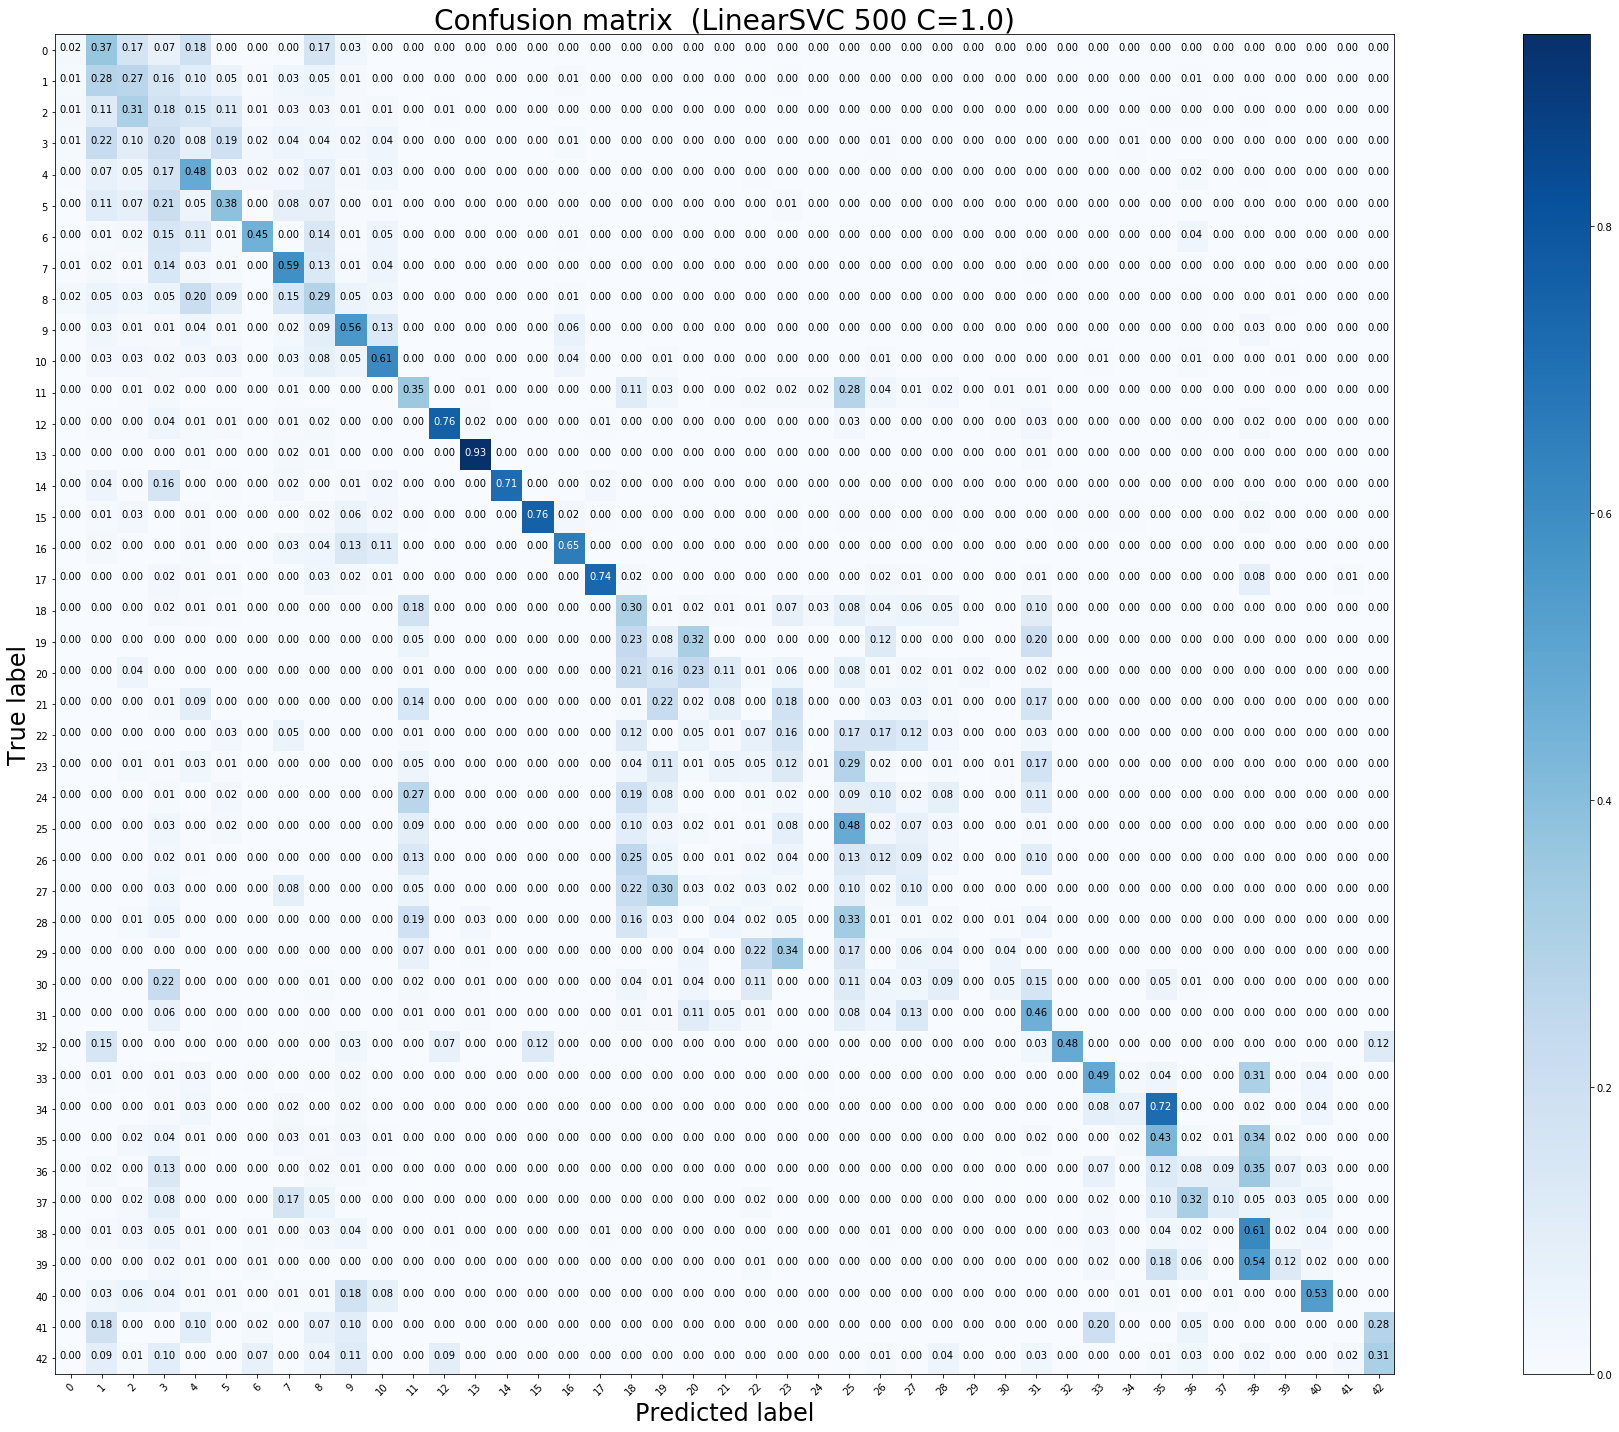

Test accuracy:  0.44980205859065714 

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        60
           1       0.31      0.28      0.29       720
           2       0.35      0.31      0.33       750
           3       0.09      0.20      0.13       450
           4       0.40      0.48      0.44       660
           5       0.42      0.38      0.40       630
           6       0.54      0.45      0.49       150
           7       0.47      0.59      0.52       450
           8       0.23      0.29      0.25       450
           9       0.55      0.56      0.56       480
          10       0.67      0.61      0.64       660
          11       0.39      0.35      0.37       420
          12       0.95      0.76      0.85       690
          13       0.96      0.93      0.95       720
          14       0.98      0.71      0.83       270
          15       0.95      0.76      0.84       210
          16       0.53      0.65      0.59

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


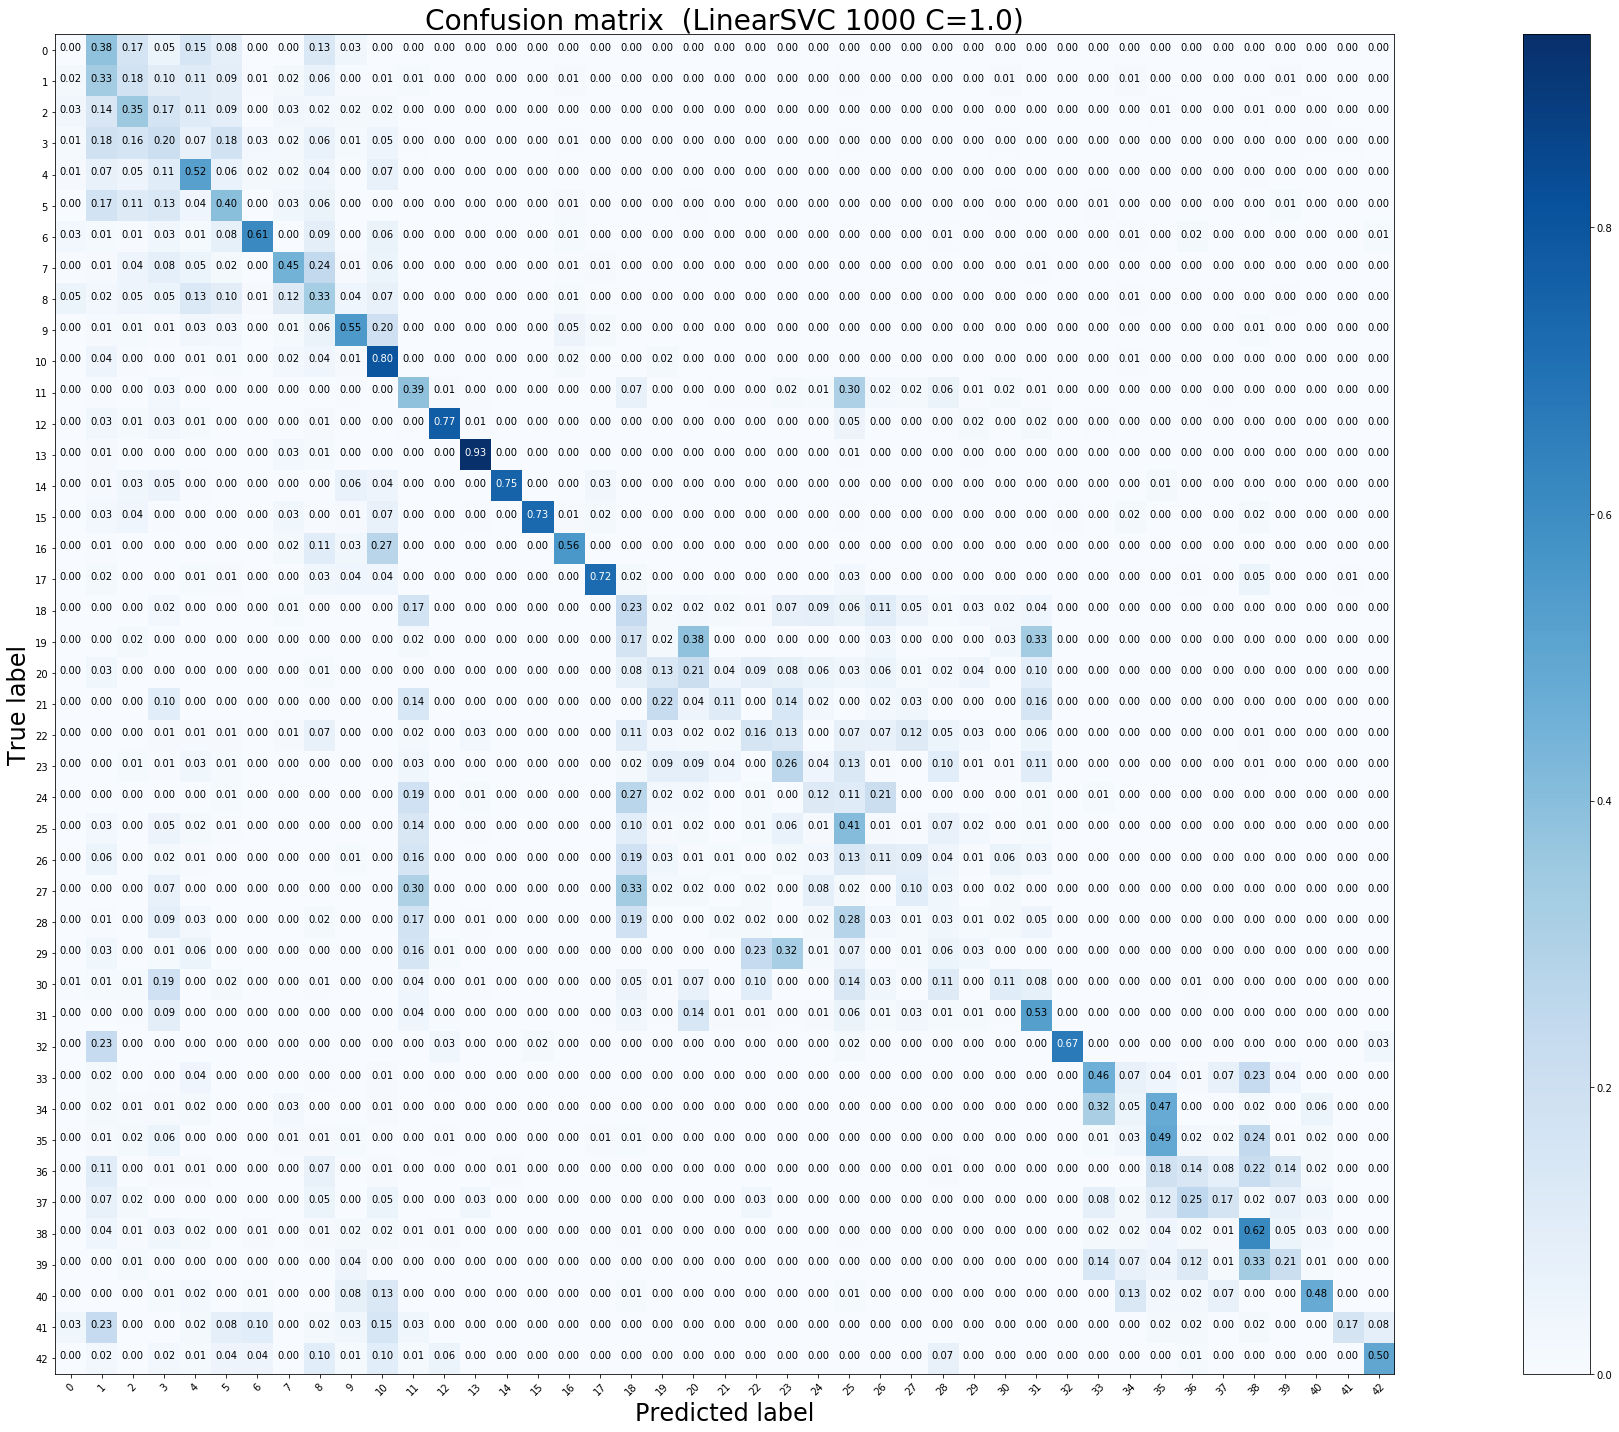

Test accuracy:  0.47268408551068886 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.29      0.33      0.31       720
           2       0.39      0.35      0.37       750
           3       0.12      0.20      0.15       450
           4       0.46      0.52      0.49       660
           5       0.40      0.40      0.40       630
           6       0.65      0.61      0.63       150
           7       0.50      0.45      0.47       450
           8       0.25      0.33      0.29       450
           9       0.67      0.55      0.61       480
          10       0.58      0.80      0.67       660
          11       0.35      0.39      0.37       420
          12       0.95      0.77      0.85       690
          13       0.97      0.93      0.95       720
          14       0.99      0.75      0.85       270
          15       0.97      0.73      0.83       210
          16       0.55      0.56      0.55

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


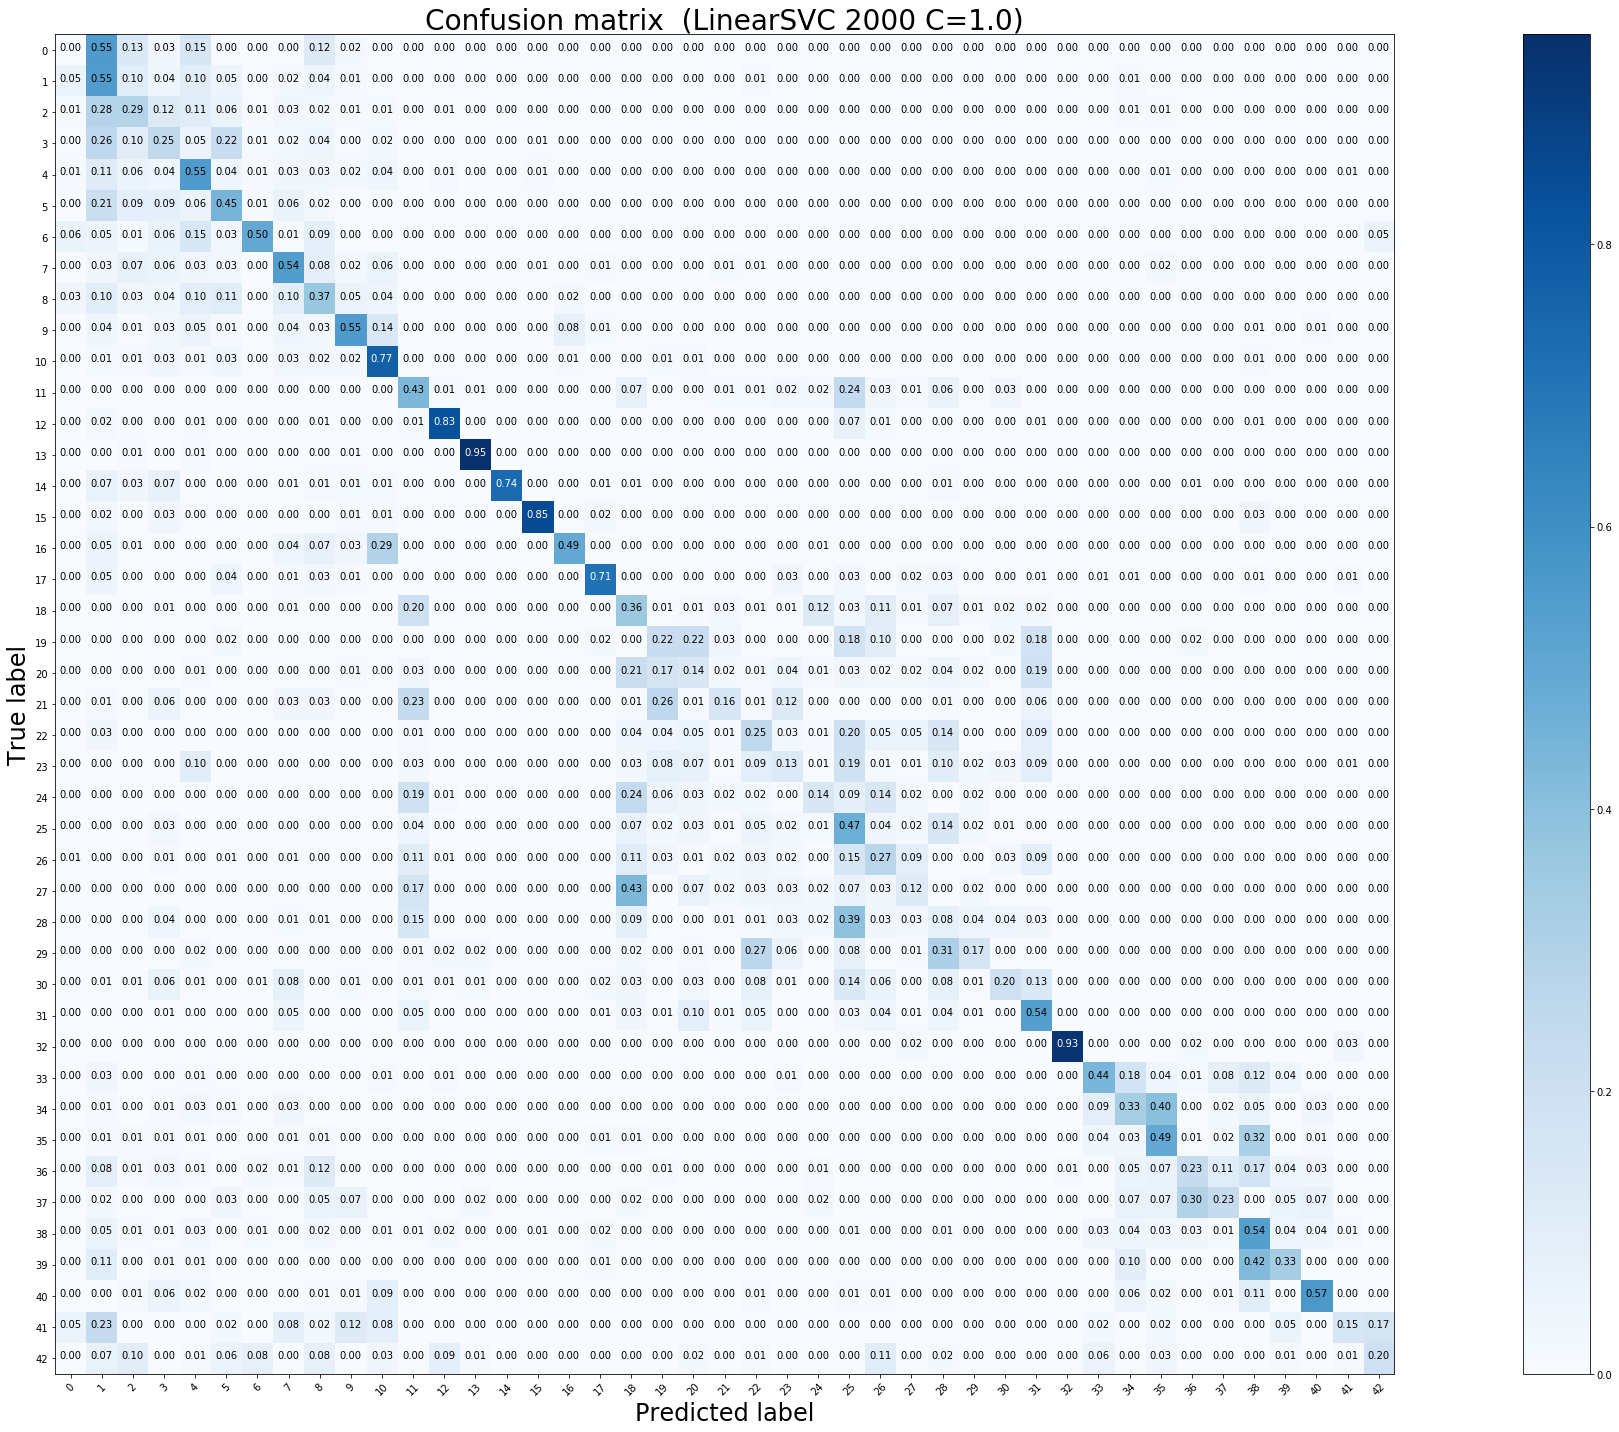

Test accuracy:  0.5064133016627078 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.33      0.55      0.41       720
           2       0.40      0.29      0.33       750
           3       0.23      0.25      0.24       450
           4       0.48      0.55      0.51       660
           5       0.46      0.45      0.46       630
           6       0.60      0.50      0.55       150
           7       0.50      0.54      0.52       450
           8       0.38      0.37      0.38       450
           9       0.70      0.55      0.62       480
          10       0.69      0.77      0.73       660
          11       0.45      0.43      0.44       420
          12       0.91      0.83      0.87       690
          13       0.98      0.95      0.97       720
          14       0.98      0.74      0.84       270
          15       0.89      0.85      0.87       210
          16       0.56      0.49      0.52 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


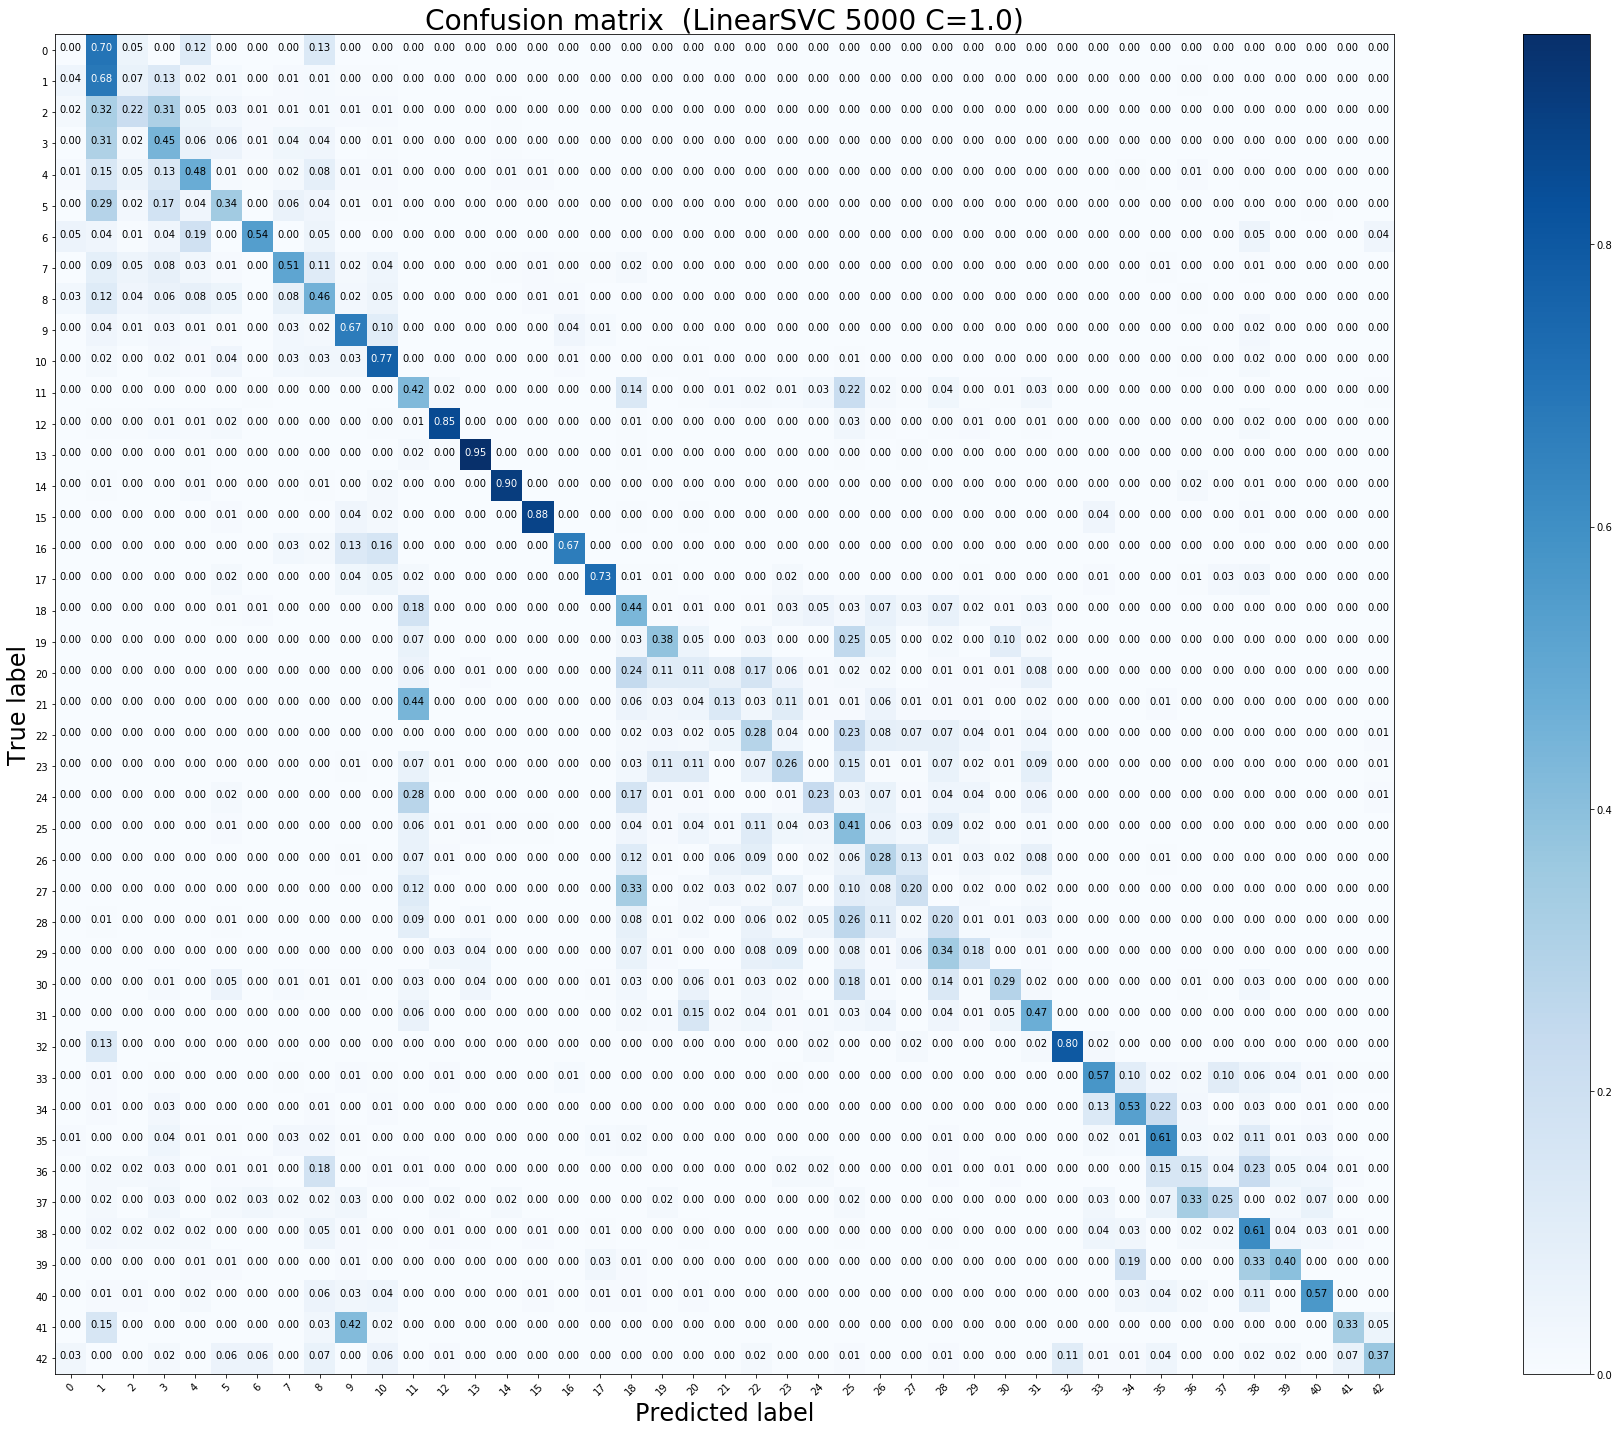

Test accuracy:  0.5403008709422011 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.36      0.68      0.47       720
           2       0.48      0.22      0.30       750
           3       0.23      0.45      0.31       450
           4       0.58      0.48      0.52       660
           5       0.56      0.34      0.43       630
           6       0.70      0.54      0.61       150
           7       0.57      0.51      0.54       450
           8       0.41      0.46      0.43       450
           9       0.69      0.67      0.68       480
          10       0.74      0.77      0.75       660
          11       0.40      0.42      0.41       420
          12       0.95      0.85      0.89       690
          13       0.97      0.95      0.96       720
          14       0.93      0.90      0.92       270
          15       0.86      0.88      0.87       210
          16       0.73      0.67      0.70 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


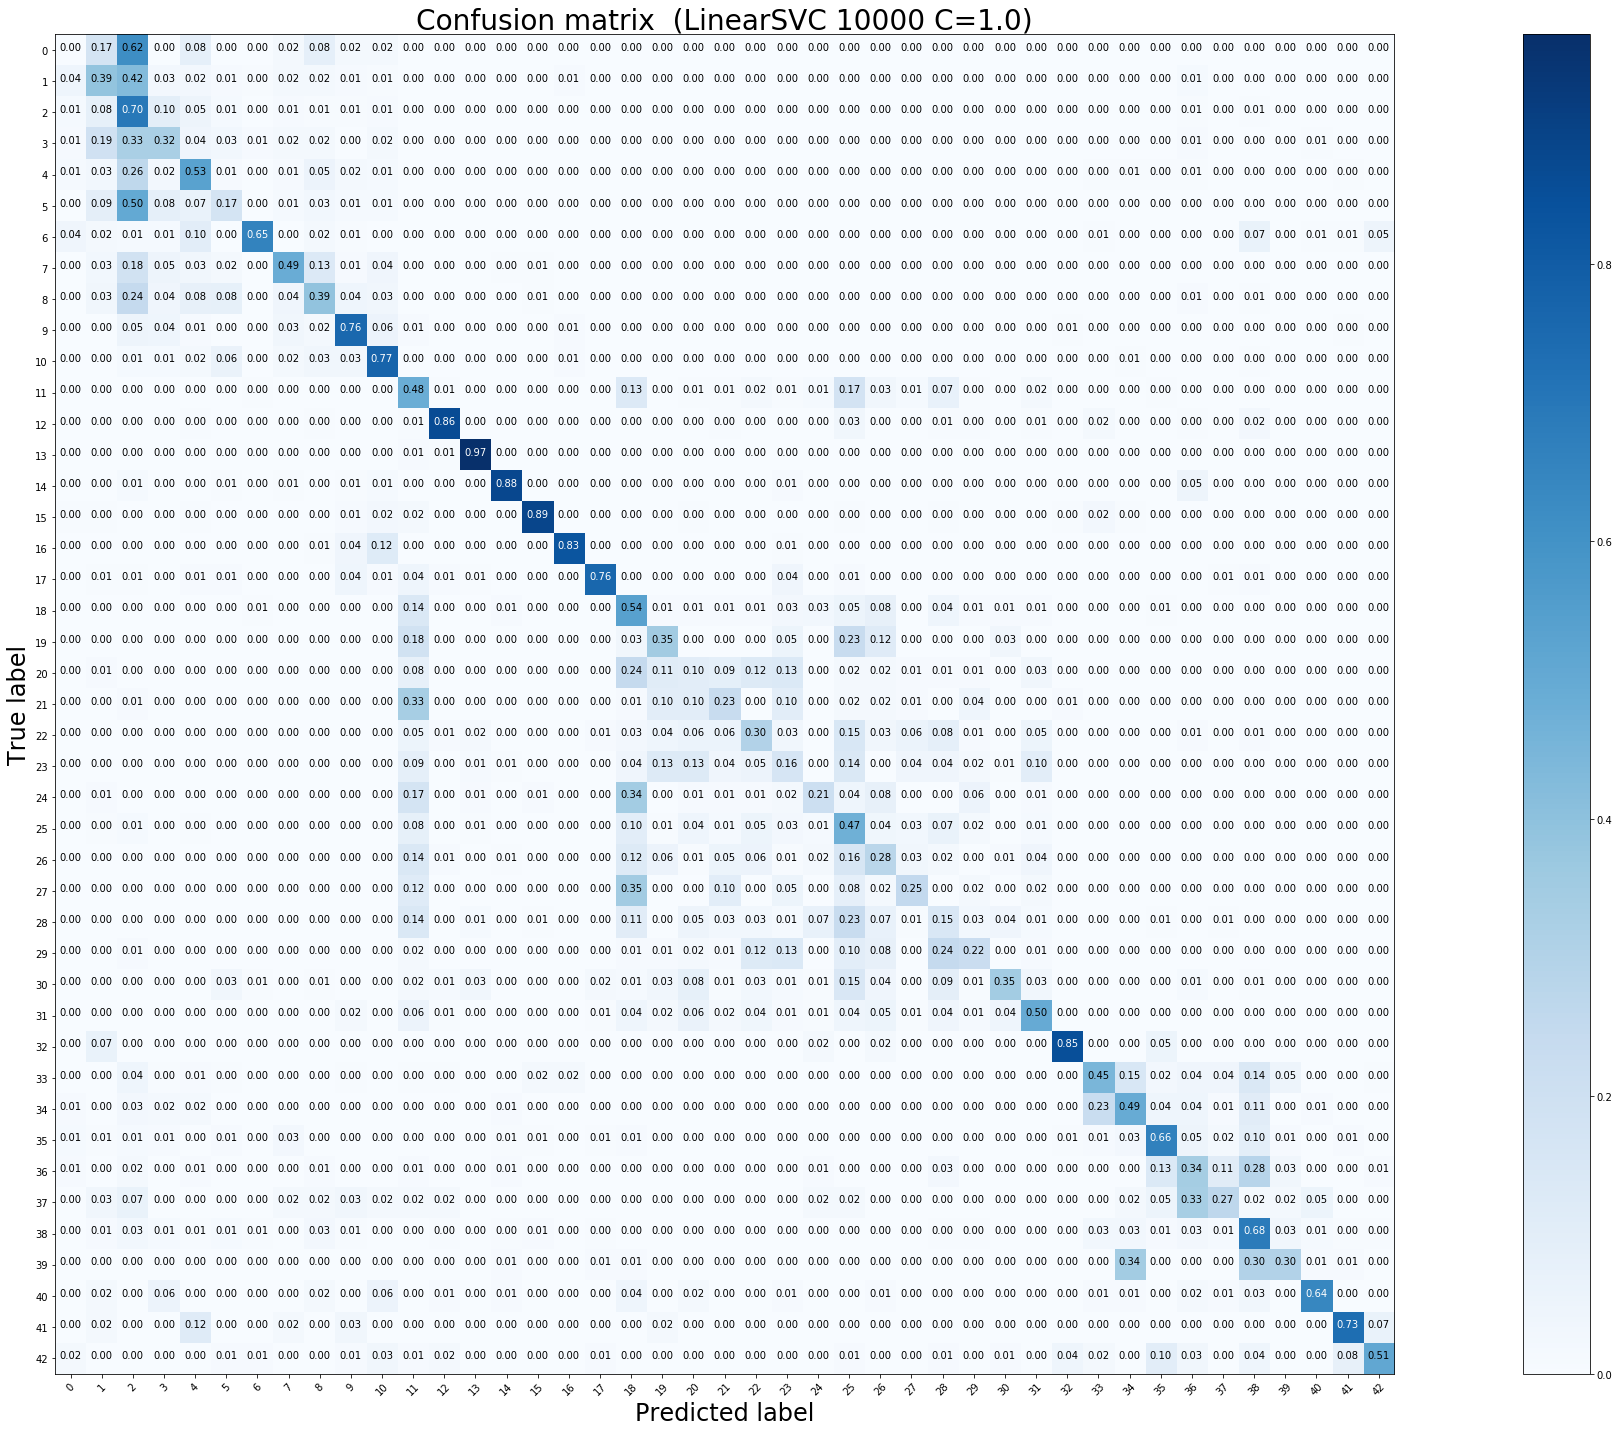

Test accuracy:  0.5631828978622327 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.49      0.39      0.43       720
           2       0.29      0.70      0.41       750
           3       0.36      0.32      0.34       450
           4       0.61      0.53      0.57       660
           5       0.43      0.17      0.25       630
           6       0.80      0.65      0.72       150
           7       0.69      0.49      0.57       450
           8       0.46      0.39      0.42       450
           9       0.75      0.76      0.75       480
          10       0.78      0.77      0.78       660
          11       0.41      0.48      0.44       420
          12       0.95      0.86      0.91       690
          13       0.97      0.97      0.97       720
          14       0.92      0.88      0.90       270
          15       0.87      0.89      0.88       210
          16       0.83      0.83      0.83 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


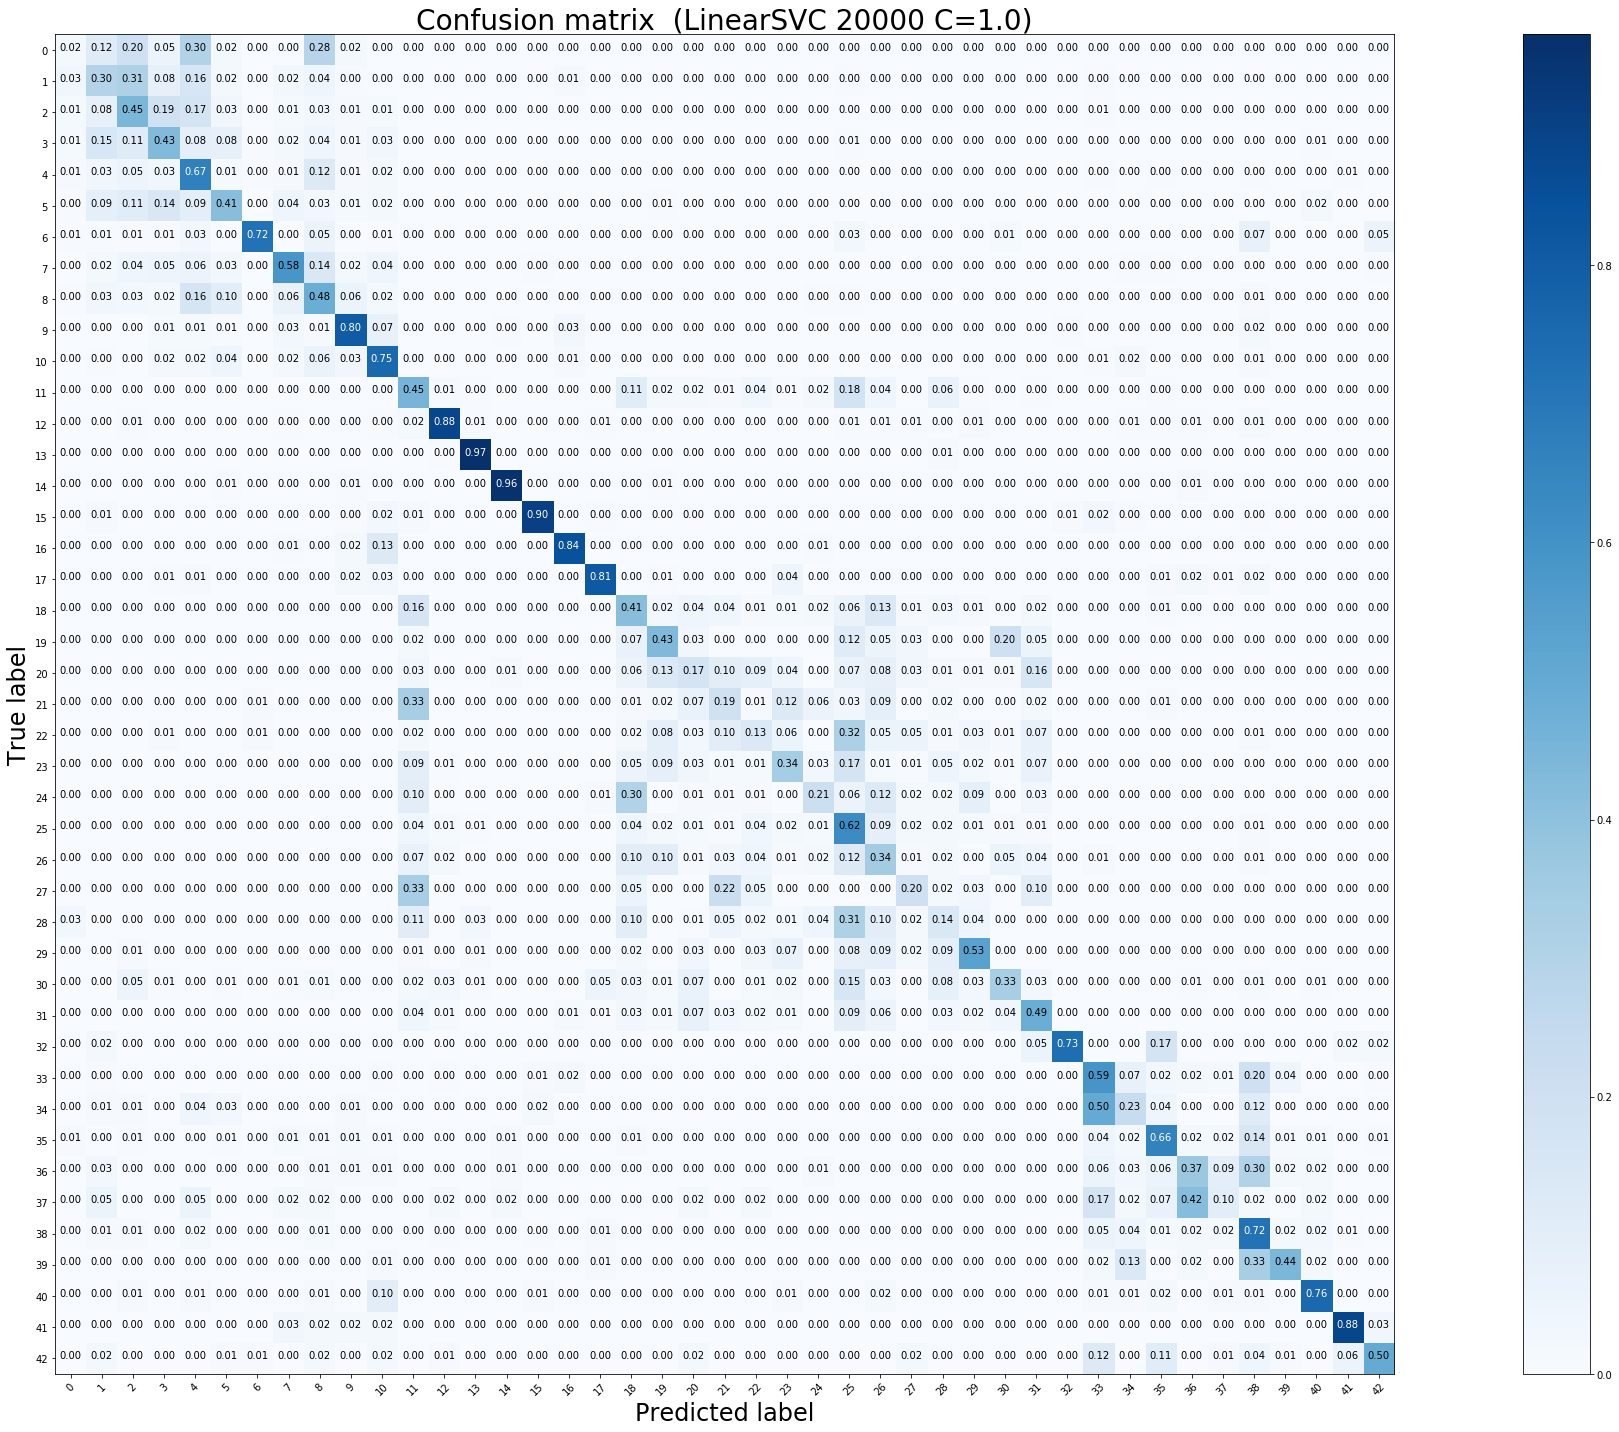

Test accuracy:  0.5865399841646872 

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        60
           1       0.46      0.30      0.36       720
           2       0.43      0.45      0.44       750
           3       0.34      0.43      0.38       450
           4       0.47      0.67      0.55       660
           5       0.59      0.41      0.48       630
           6       0.87      0.72      0.79       150
           7       0.65      0.58      0.62       450
           8       0.40      0.48      0.44       450
           9       0.77      0.80      0.79       480
          10       0.74      0.75      0.75       660
          11       0.46      0.45      0.46       420
          12       0.95      0.88      0.91       690
          13       0.97      0.97      0.97       720
          14       0.95      0.96      0.95       270
          15       0.93      0.90      0.92       210
          16       0.77      0.84      0.81 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


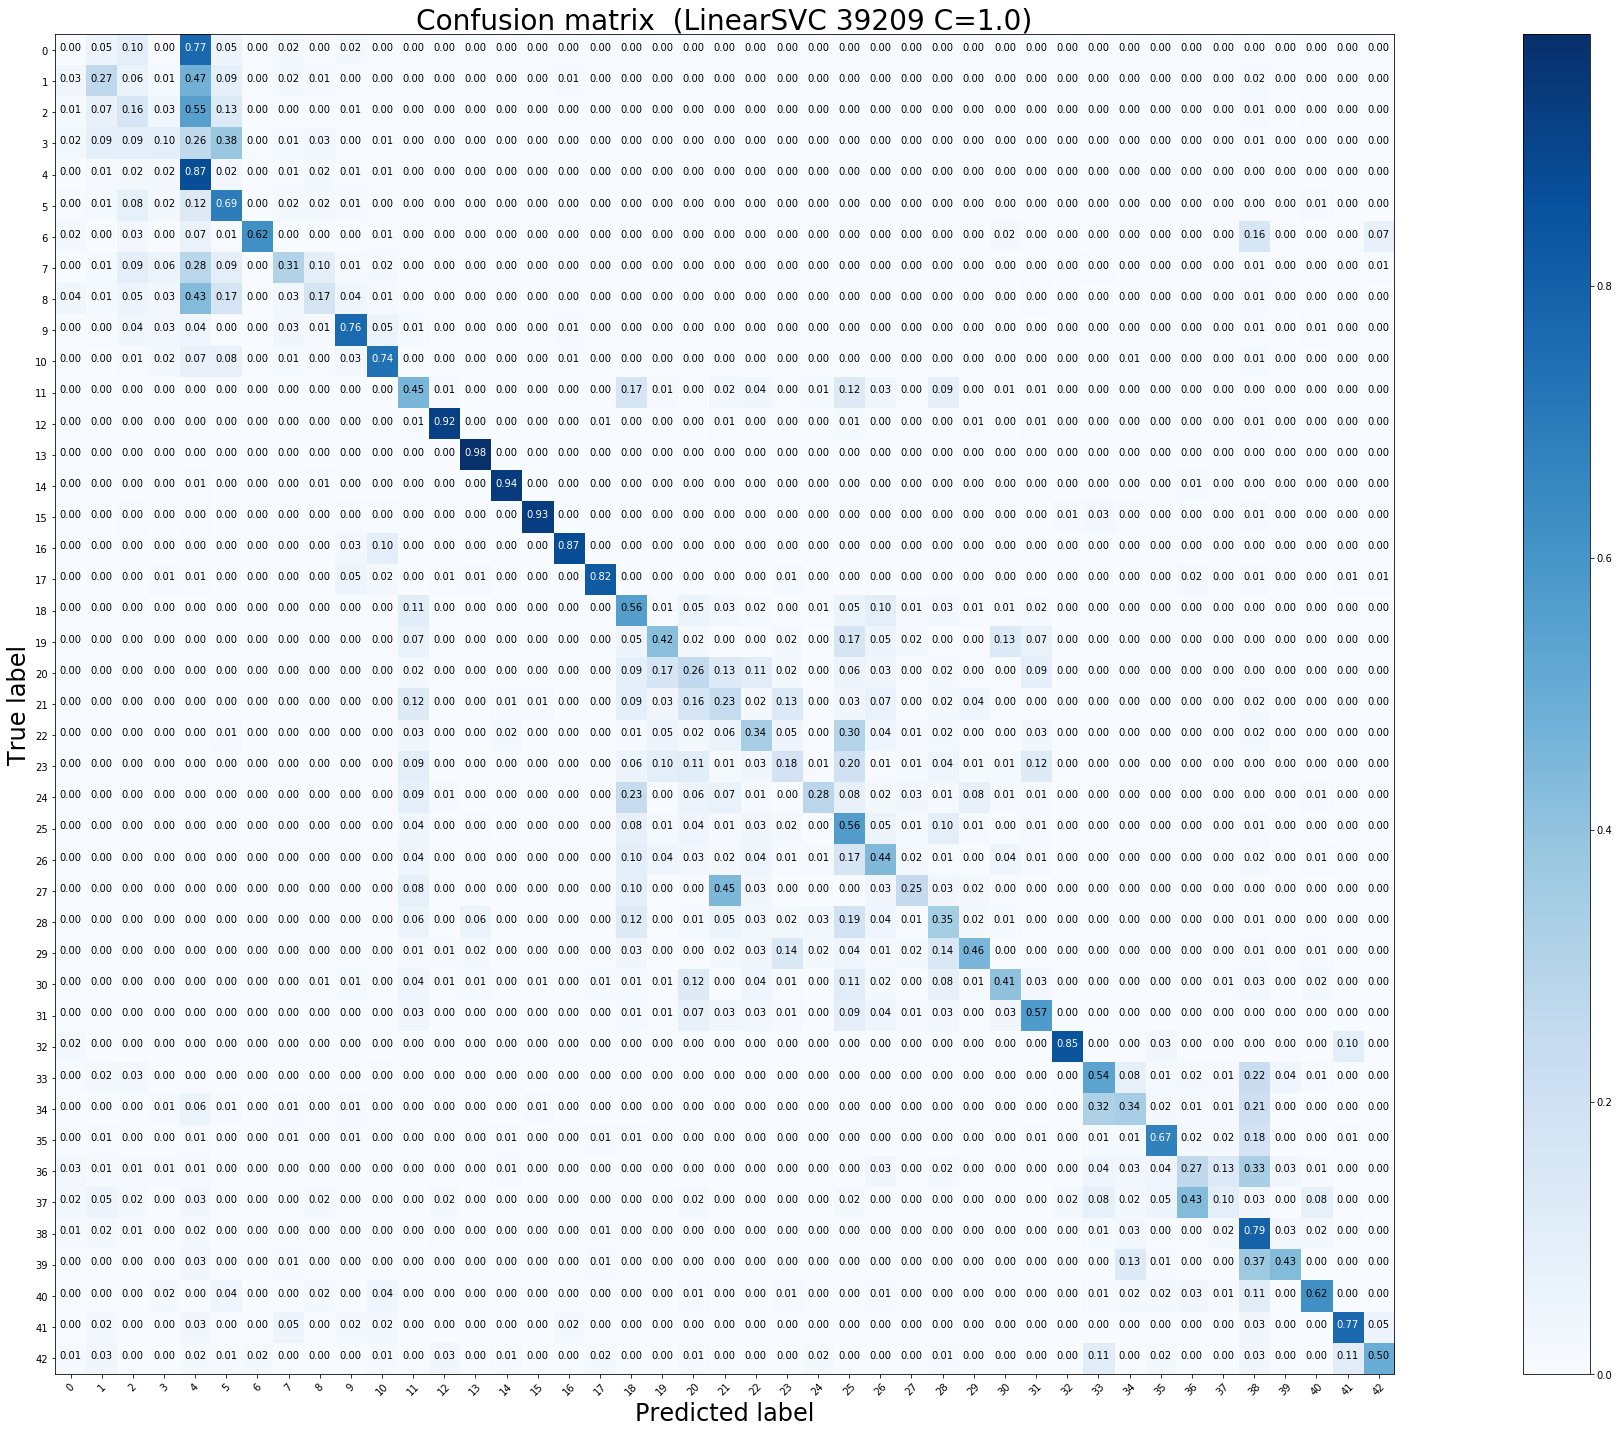

Test accuracy:  0.5726049089469517 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.55      0.27      0.36       720
           2       0.32      0.16      0.21       750
           3       0.25      0.10      0.14       450
           4       0.29      0.87      0.43       660
           5       0.45      0.69      0.54       630
           6       0.87      0.62      0.72       150
           7       0.61      0.31      0.41       450
           8       0.44      0.17      0.25       450
           9       0.81      0.76      0.79       480
          10       0.85      0.74      0.79       660
          11       0.56      0.45      0.50       420
          12       0.97      0.92      0.95       690
          13       0.97      0.98      0.98       720
          14       0.96      0.94      0.95       270
          15       0.97      0.93      0.95       210
          16       0.87      0.87      0.87 

In [19]:
#####################################################################################################
###########   LinearSVC, HOG, seed=1, random_A, without_scaler, hinge und l2  ###############
#####################################################################################################

train_LinearSVC(X_tr_500, X_test_vgg16, y_tr_500, y_test, 1, '500',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_1000, X_test_vgg16, y_tr_1000, y_test, 1, '1000',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_2000, X_test_vgg16, y_tr_2000, y_test, 1, '2000',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_5000, X_test_vgg16, y_tr_5000, y_test, 1, '5000',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_10000, X_test_vgg16, y_tr_10000, y_test, 1, '10000',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_20000, X_test_vgg16, y_tr_20000, y_test, 1, '20000',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")
train_LinearSVC(X_tr, X_test_vgg16, y_tr, y_test, 1, '39209',1.0, 'l2', 'hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler", "VGG16_balanced.pkl")



C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


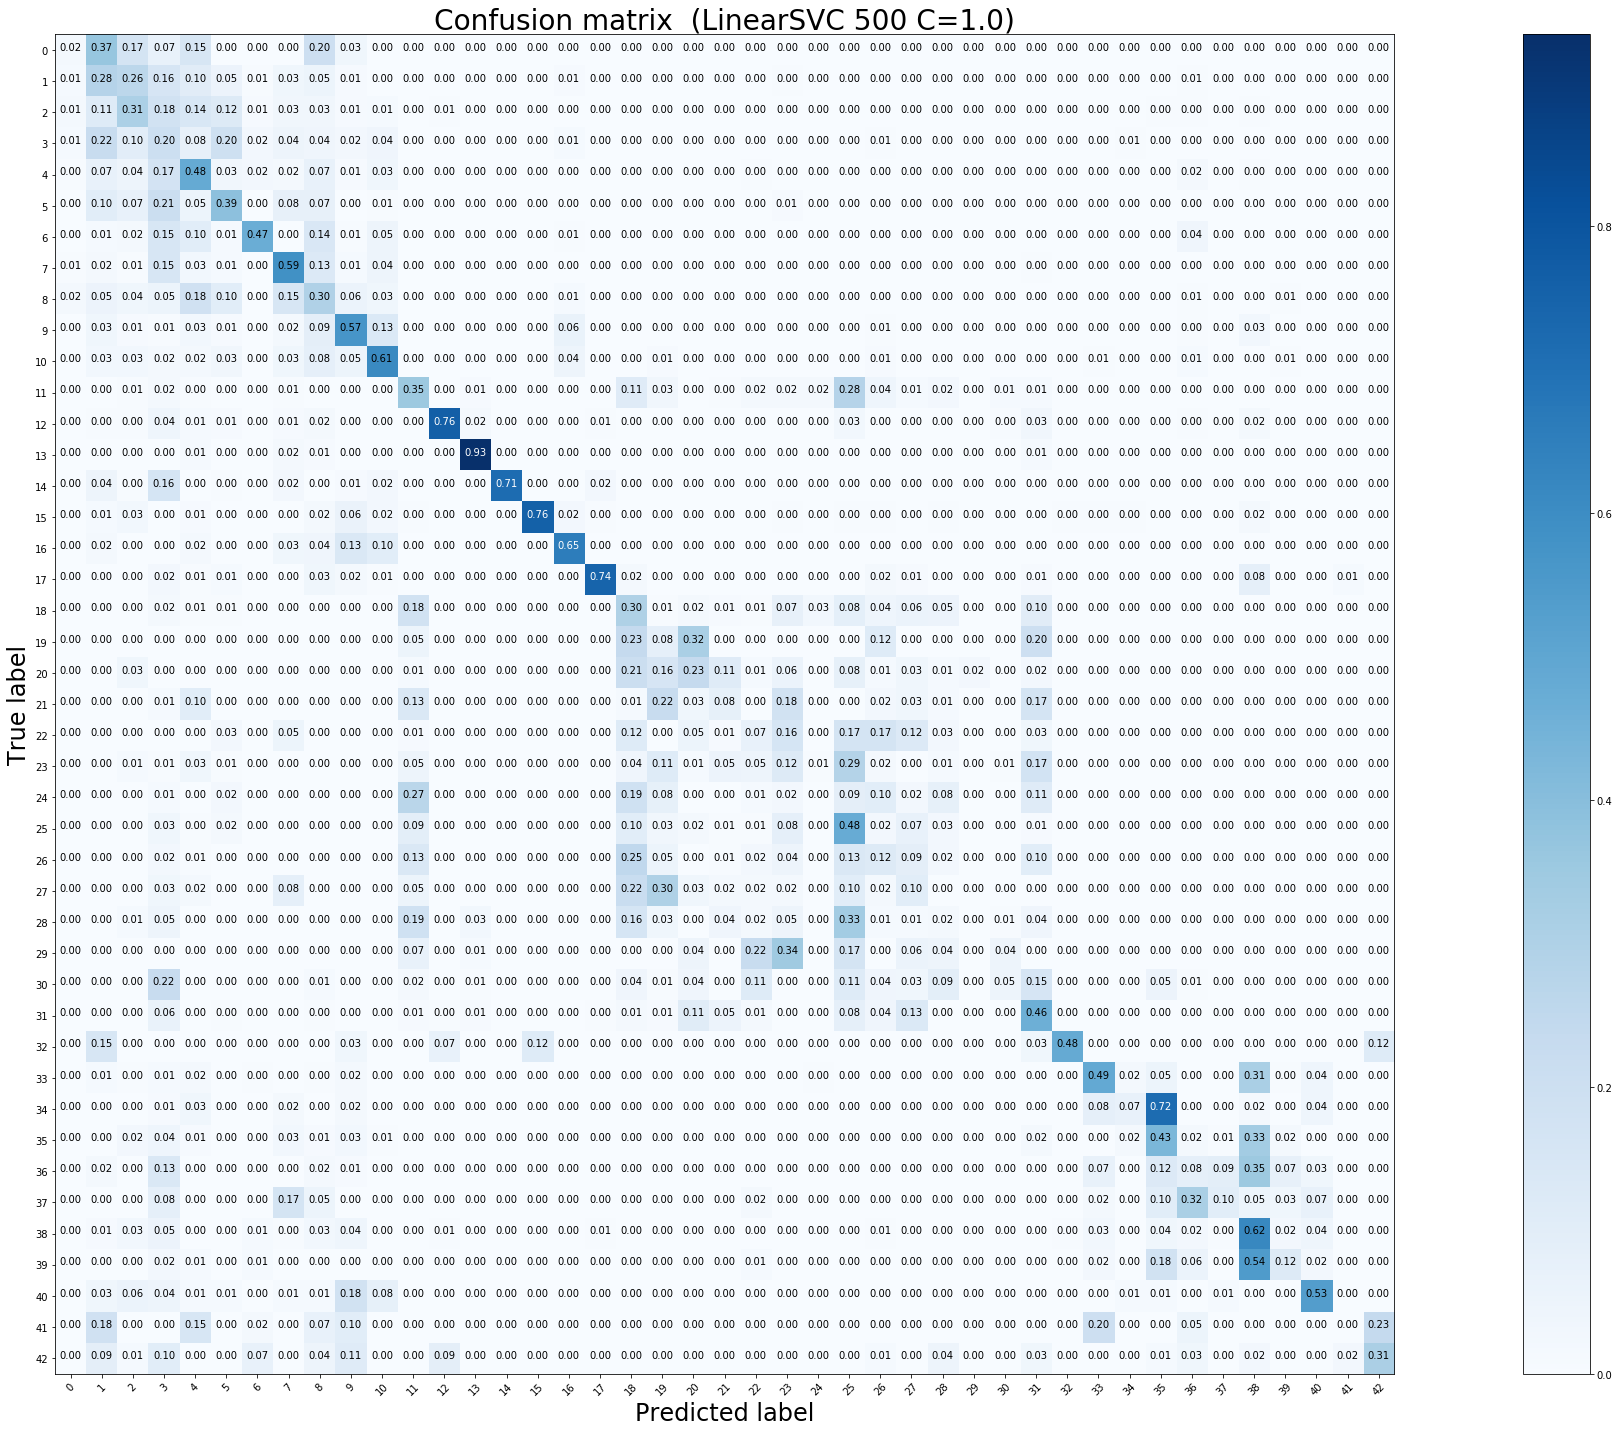

Test accuracy:  0.4513064133016627 

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        60
           1       0.31      0.28      0.30       720
           2       0.36      0.31      0.33       750
           3       0.09      0.20      0.13       450
           4       0.41      0.48      0.44       660
           5       0.41      0.39      0.40       630
           6       0.54      0.47      0.50       150
           7       0.47      0.59      0.52       450
           8       0.23      0.30      0.26       450
           9       0.55      0.57      0.56       480
          10       0.67      0.61      0.64       660
          11       0.39      0.35      0.37       420
          12       0.95      0.76      0.85       690
          13       0.96      0.93      0.95       720
          14       0.98      0.71      0.83       270
          15       0.95      0.76      0.84       210
          16       0.53      0.65      0.59 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


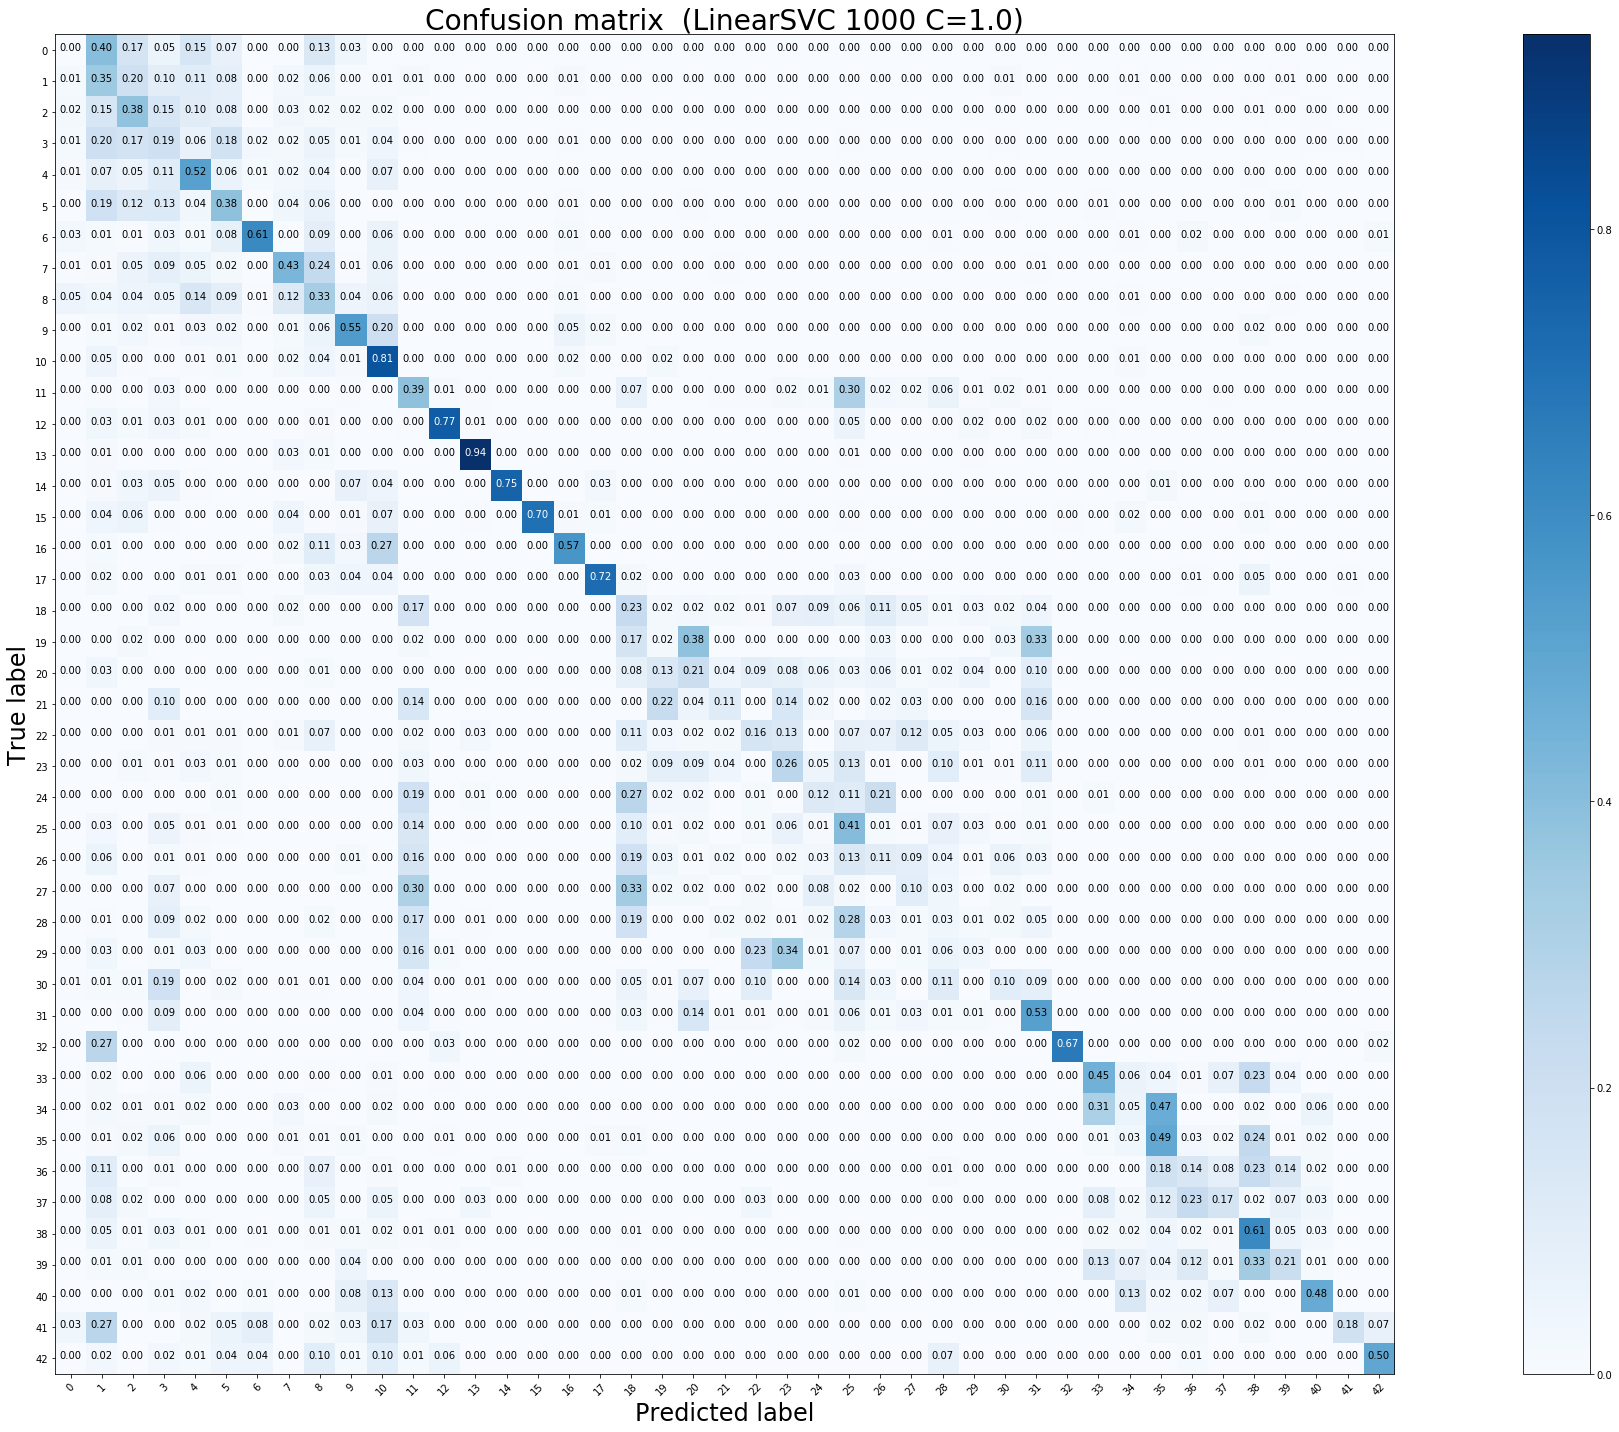

Test accuracy:  0.4731591448931116 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.28      0.35      0.31       720
           2       0.39      0.38      0.38       750
           3       0.12      0.19      0.15       450
           4       0.47      0.52      0.49       660
           5       0.41      0.38      0.39       630
           6       0.69      0.61      0.65       150
           7       0.49      0.43      0.46       450
           8       0.26      0.33      0.29       450
           9       0.67      0.55      0.60       480
          10       0.59      0.81      0.68       660
          11       0.35      0.39      0.37       420
          12       0.95      0.77      0.85       690
          13       0.97      0.94      0.95       720
          14       0.99      0.75      0.85       270
          15       0.98      0.70      0.82       210
          16       0.56      0.57      0.56 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


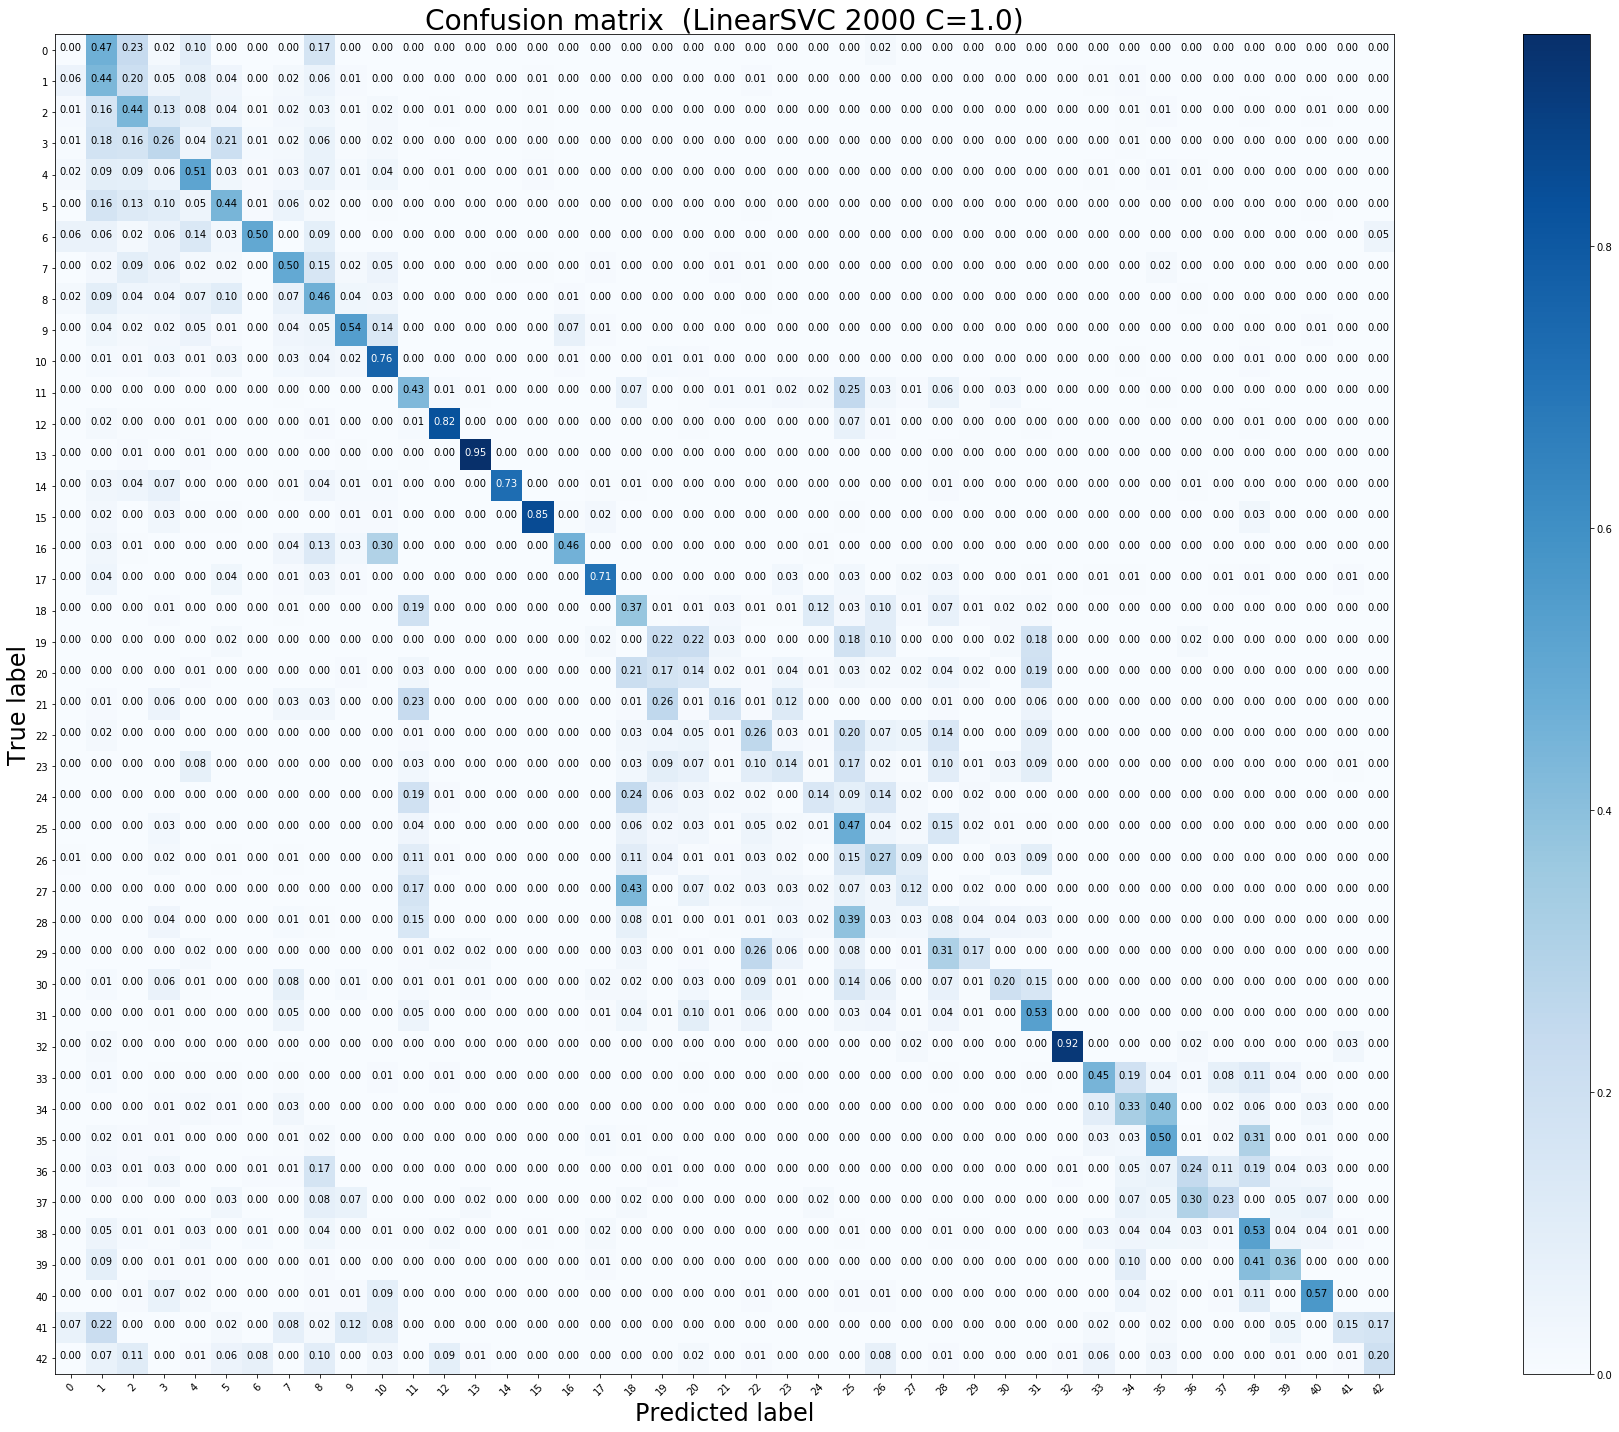

Test accuracy:  0.5076009501187648 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.34      0.44      0.38       720
           2       0.39      0.44      0.41       750
           3       0.22      0.26      0.24       450
           4       0.51      0.51      0.51       660
           5       0.49      0.44      0.46       630
           6       0.63      0.50      0.56       150
           7       0.50      0.50      0.50       450
           8       0.33      0.46      0.39       450
           9       0.73      0.54      0.62       480
          10       0.69      0.76      0.72       660
          11       0.45      0.43      0.44       420
          12       0.91      0.82      0.87       690
          13       0.98      0.95      0.97       720
          14       0.98      0.73      0.84       270
          15       0.89      0.85      0.87       210
          16       0.57      0.46      0.51 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


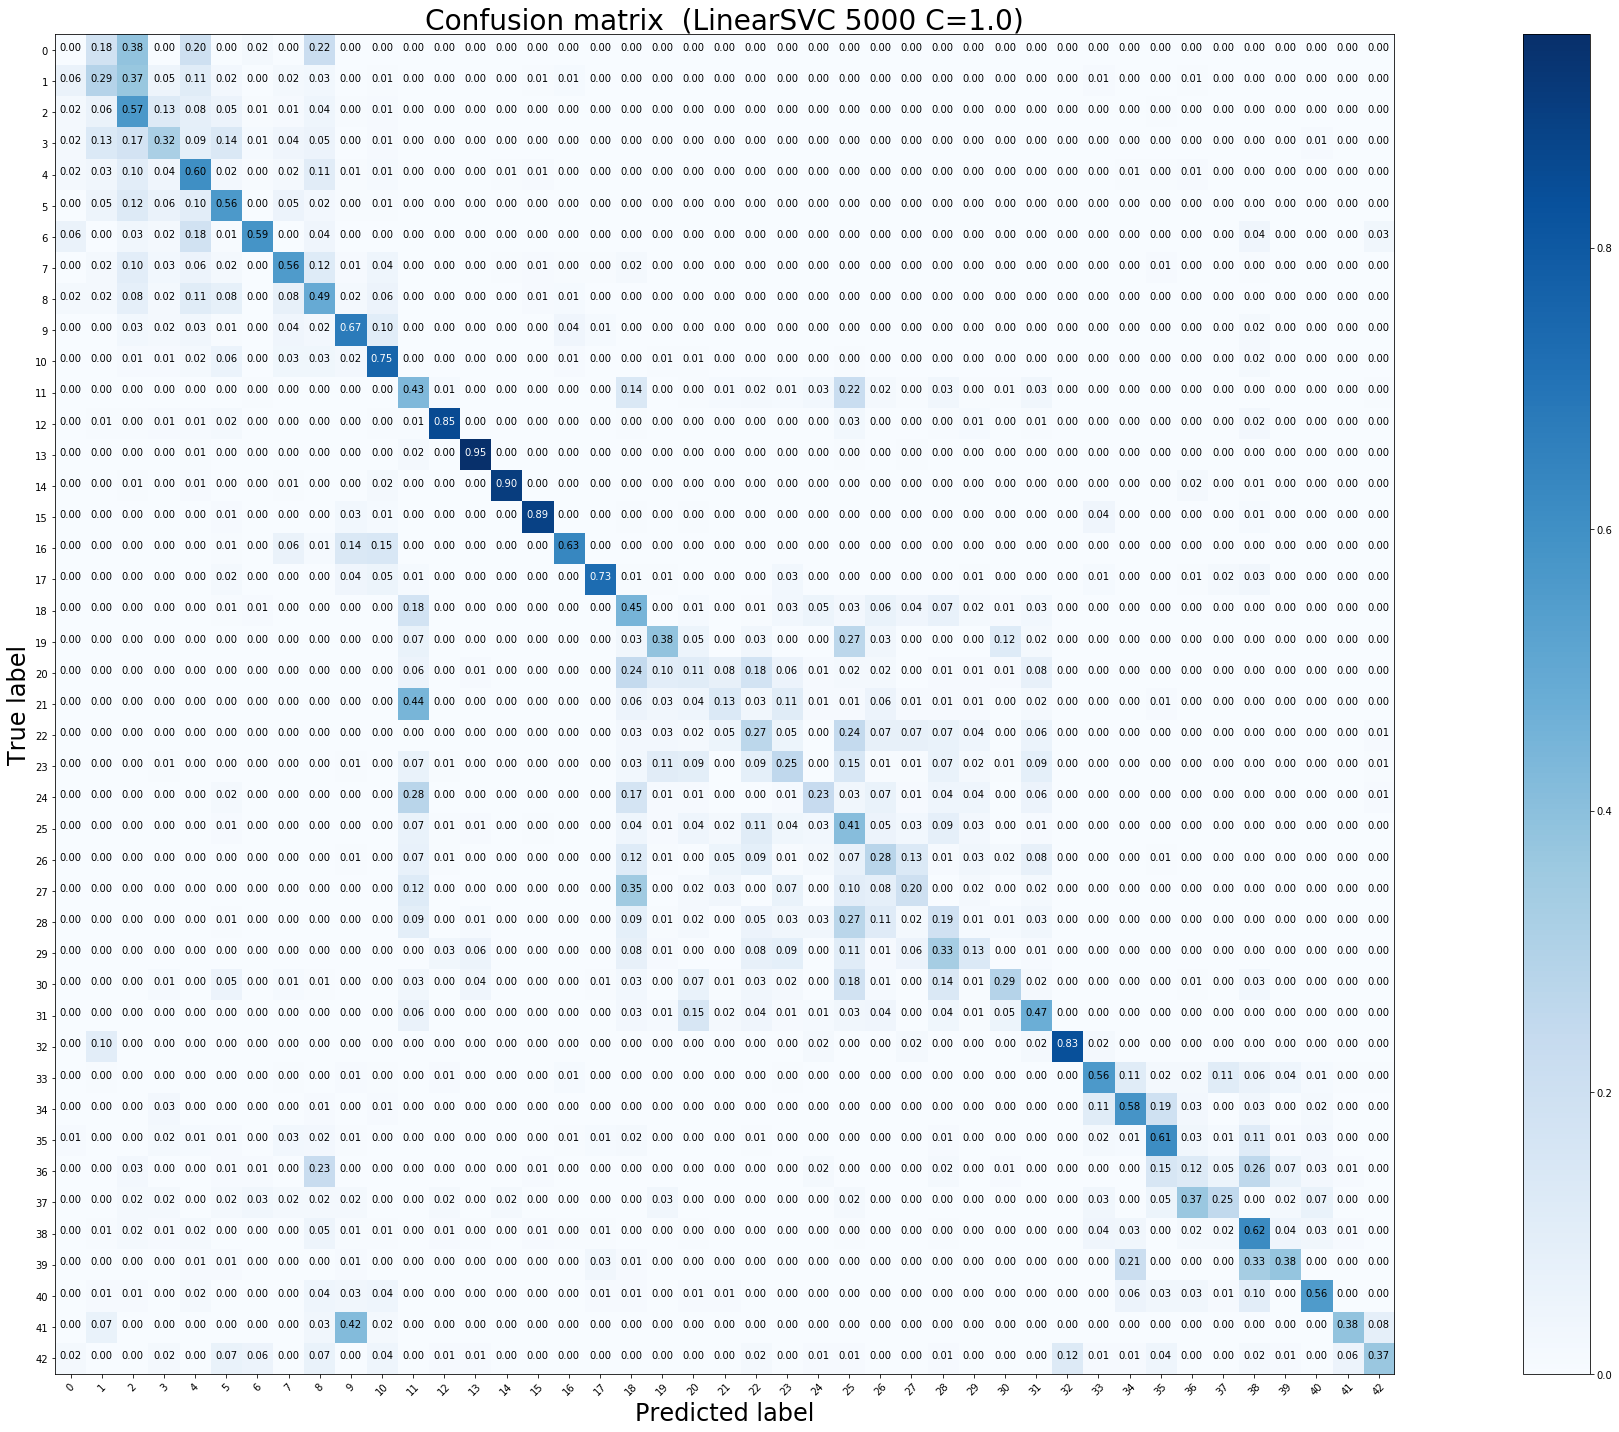

Test accuracy:  0.554473475851148 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      0.29      0.37       720
           2       0.40      0.57      0.47       750
           3       0.36      0.32      0.34       450
           4       0.49      0.60      0.54       660
           5       0.56      0.56      0.56       630
           6       0.70      0.59      0.64       150
           7       0.57      0.56      0.56       450
           8       0.38      0.49      0.43       450
           9       0.72      0.67      0.70       480
          10       0.73      0.75      0.74       660
          11       0.40      0.43      0.41       420
          12       0.95      0.85      0.90       690
          13       0.96      0.95      0.96       720
          14       0.95      0.90      0.92       270
          15       0.86      0.89      0.87       210
          16       0.66      0.63      0.65  

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


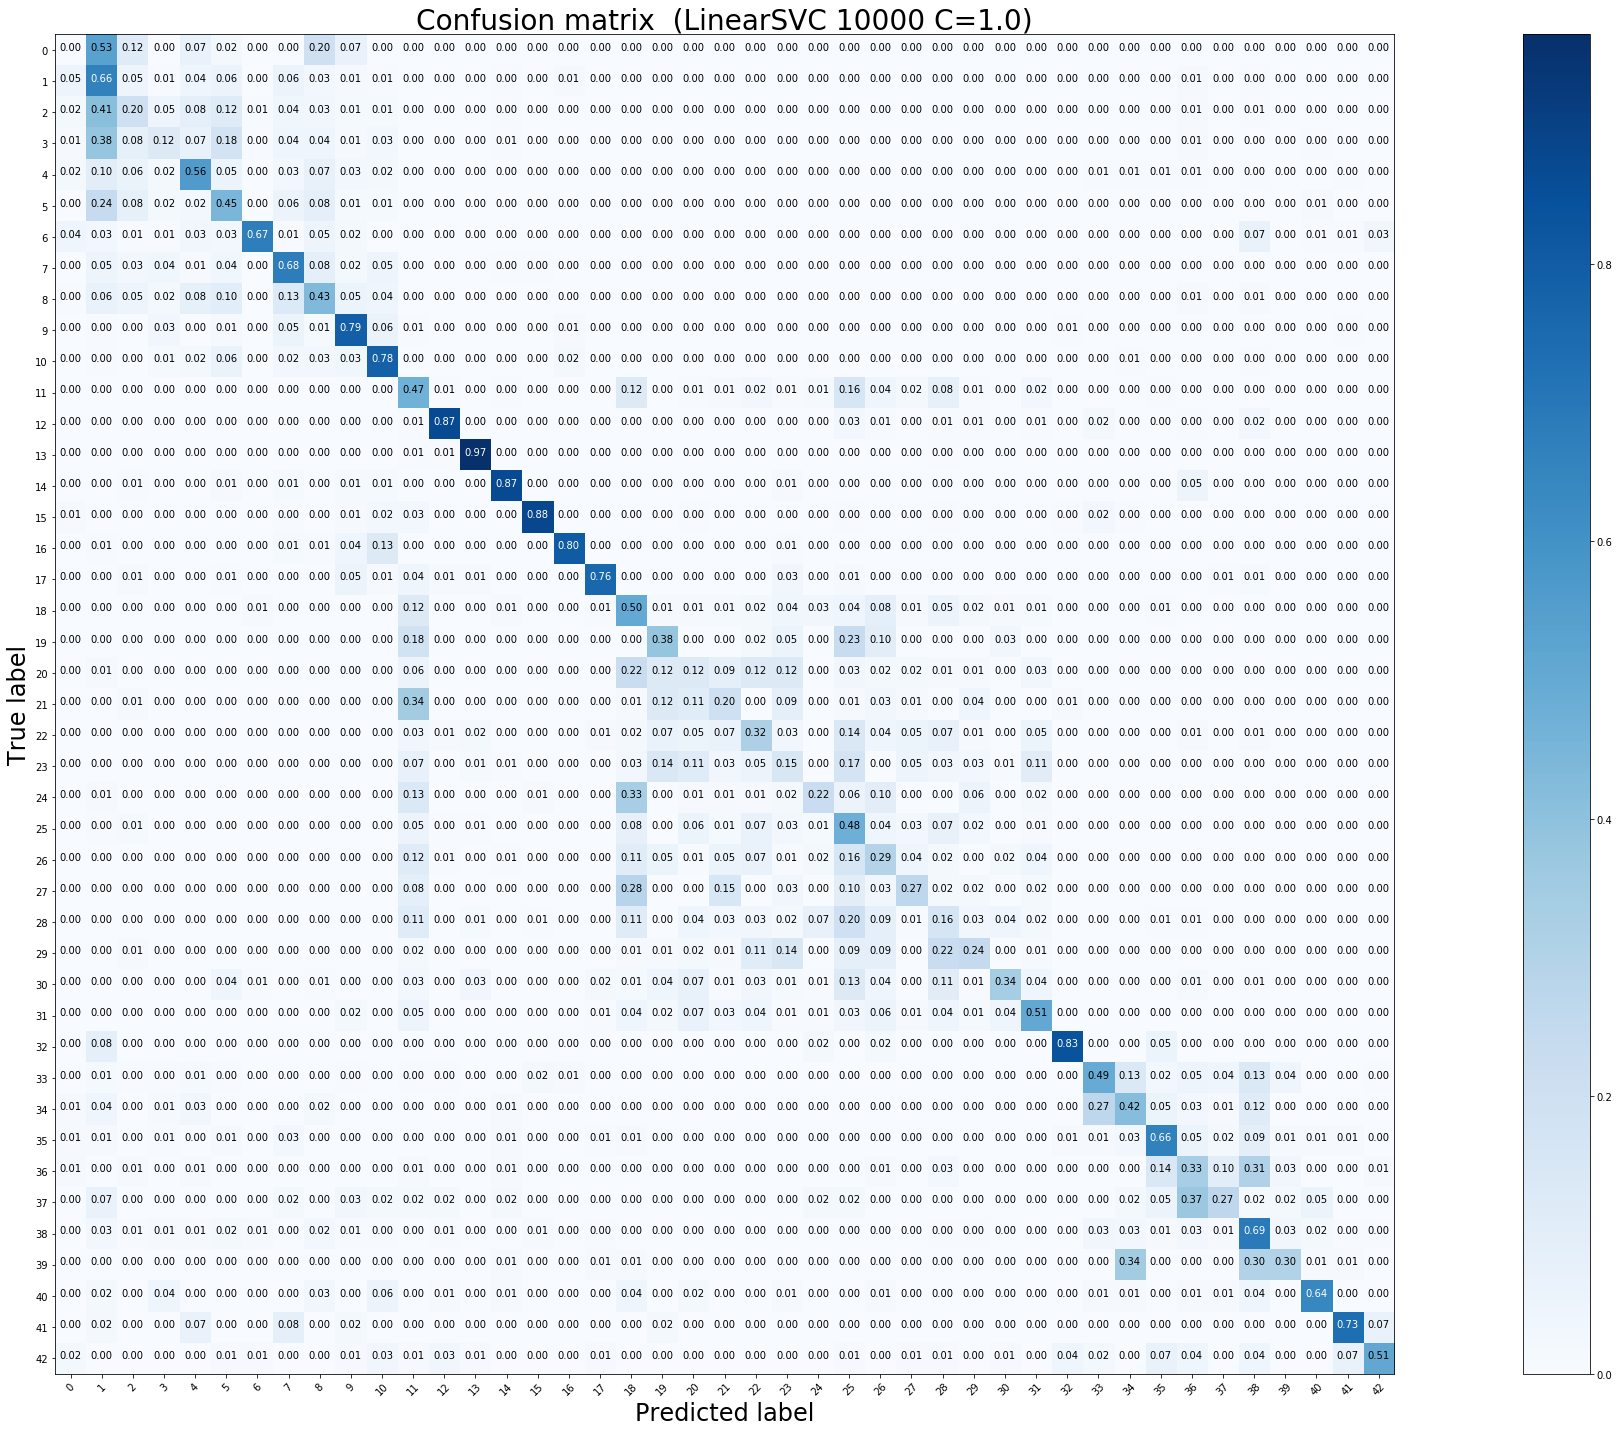

Test accuracy:  0.5663499604117181 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.36      0.66      0.47       720
           2       0.40      0.20      0.26       750
           3       0.30      0.12      0.18       450
           4       0.62      0.56      0.59       660
           5       0.42      0.45      0.43       630
           6       0.80      0.67      0.73       150
           7       0.54      0.68      0.60       450
           8       0.42      0.43      0.42       450
           9       0.71      0.79      0.75       480
          10       0.76      0.78      0.77       660
          11       0.44      0.47      0.45       420
          12       0.95      0.87      0.91       690
          13       0.97      0.97      0.97       720
          14       0.88      0.87      0.87       270
          15       0.89      0.88      0.88       210
          16       0.82      0.80      0.81 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


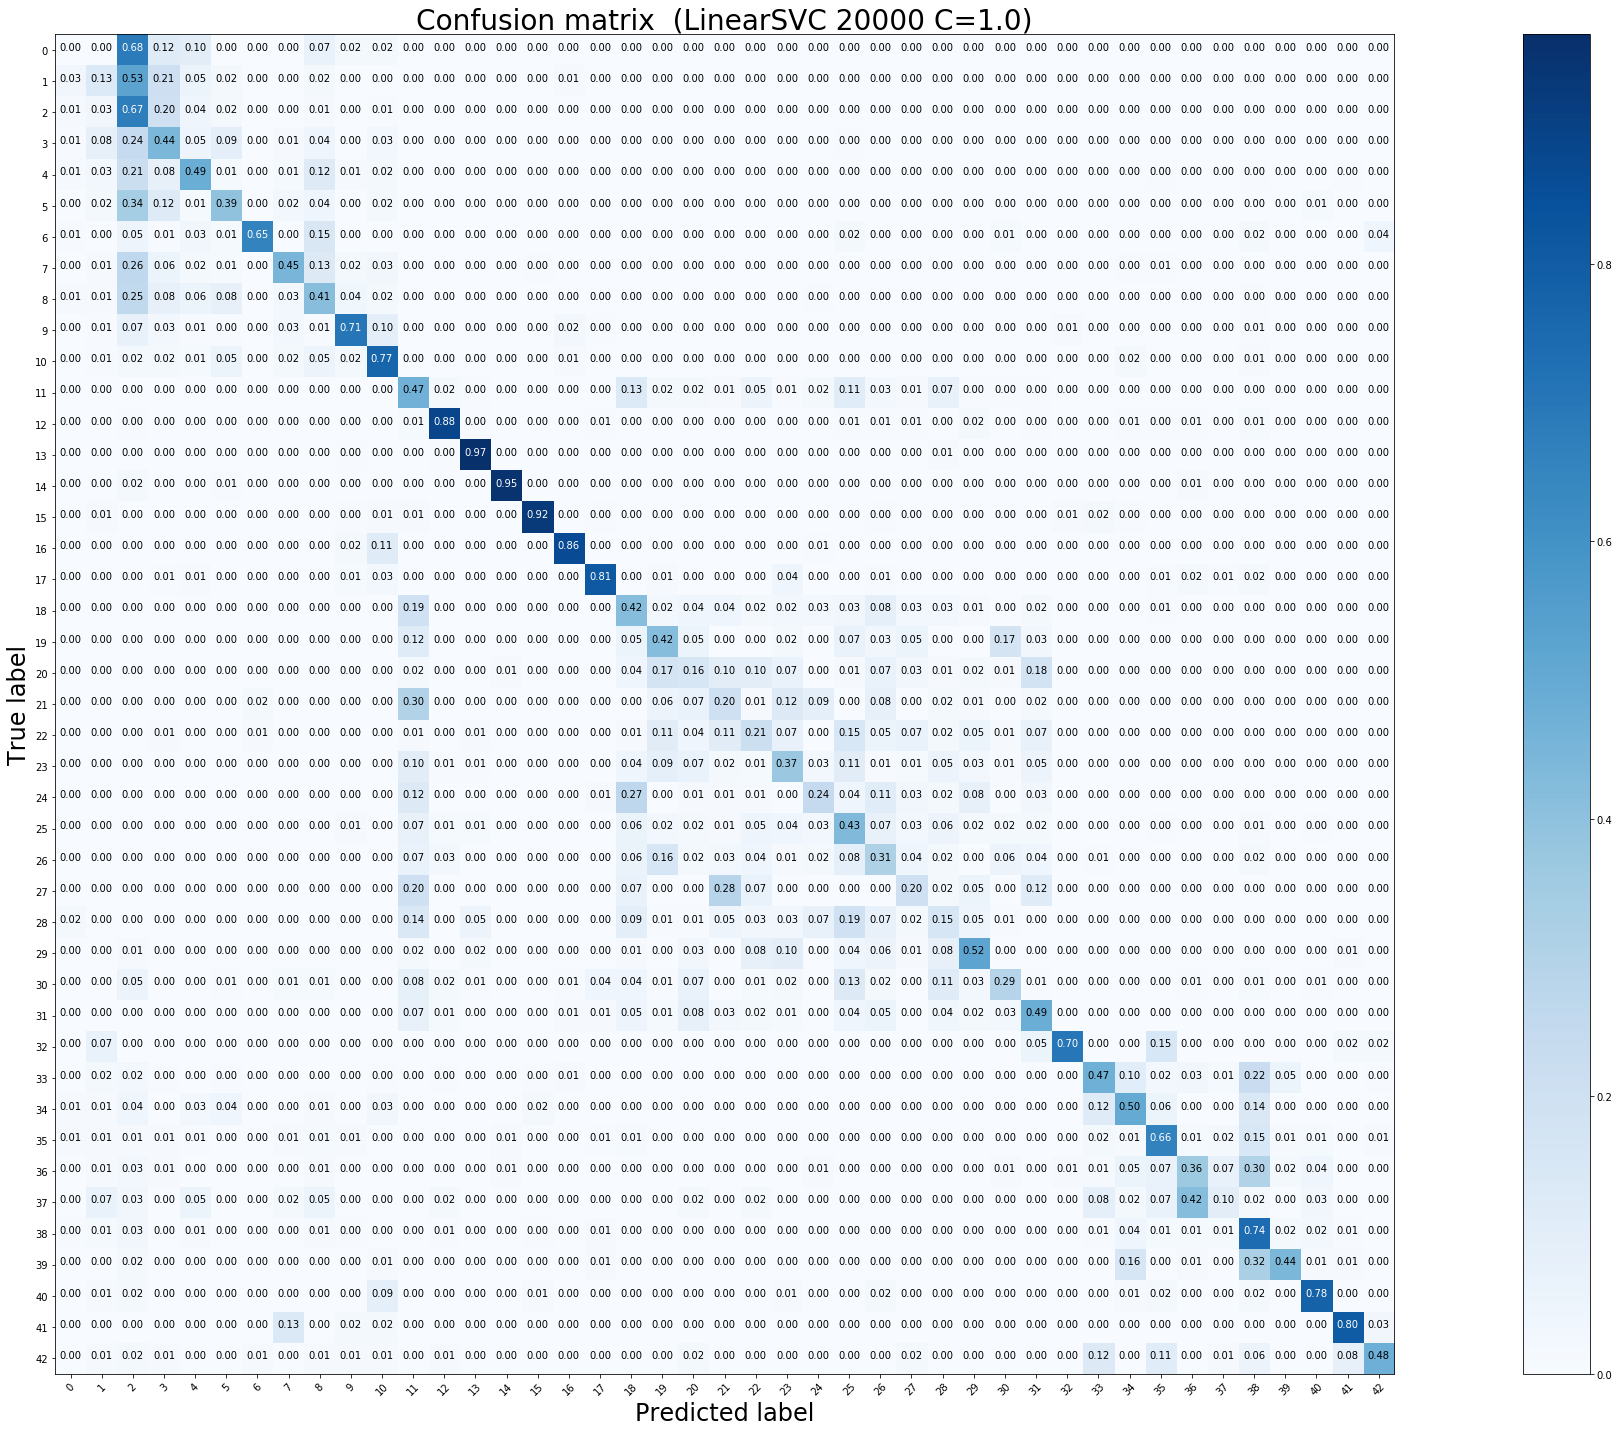

Test accuracy:  0.5644497228820269 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.41      0.13      0.20       720
           2       0.29      0.67      0.41       750
           3       0.27      0.44      0.34       450
           4       0.65      0.49      0.56       660
           5       0.60      0.39      0.48       630
           6       0.89      0.65      0.75       150
           7       0.70      0.45      0.55       450
           8       0.39      0.41      0.40       450
           9       0.82      0.71      0.76       480
          10       0.76      0.77      0.76       660
          11       0.42      0.47      0.44       420
          12       0.94      0.88      0.91       690
          13       0.96      0.97      0.96       720
          14       0.95      0.95      0.95       270
          15       0.94      0.92      0.93       210
          16       0.80      0.86      0.83 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


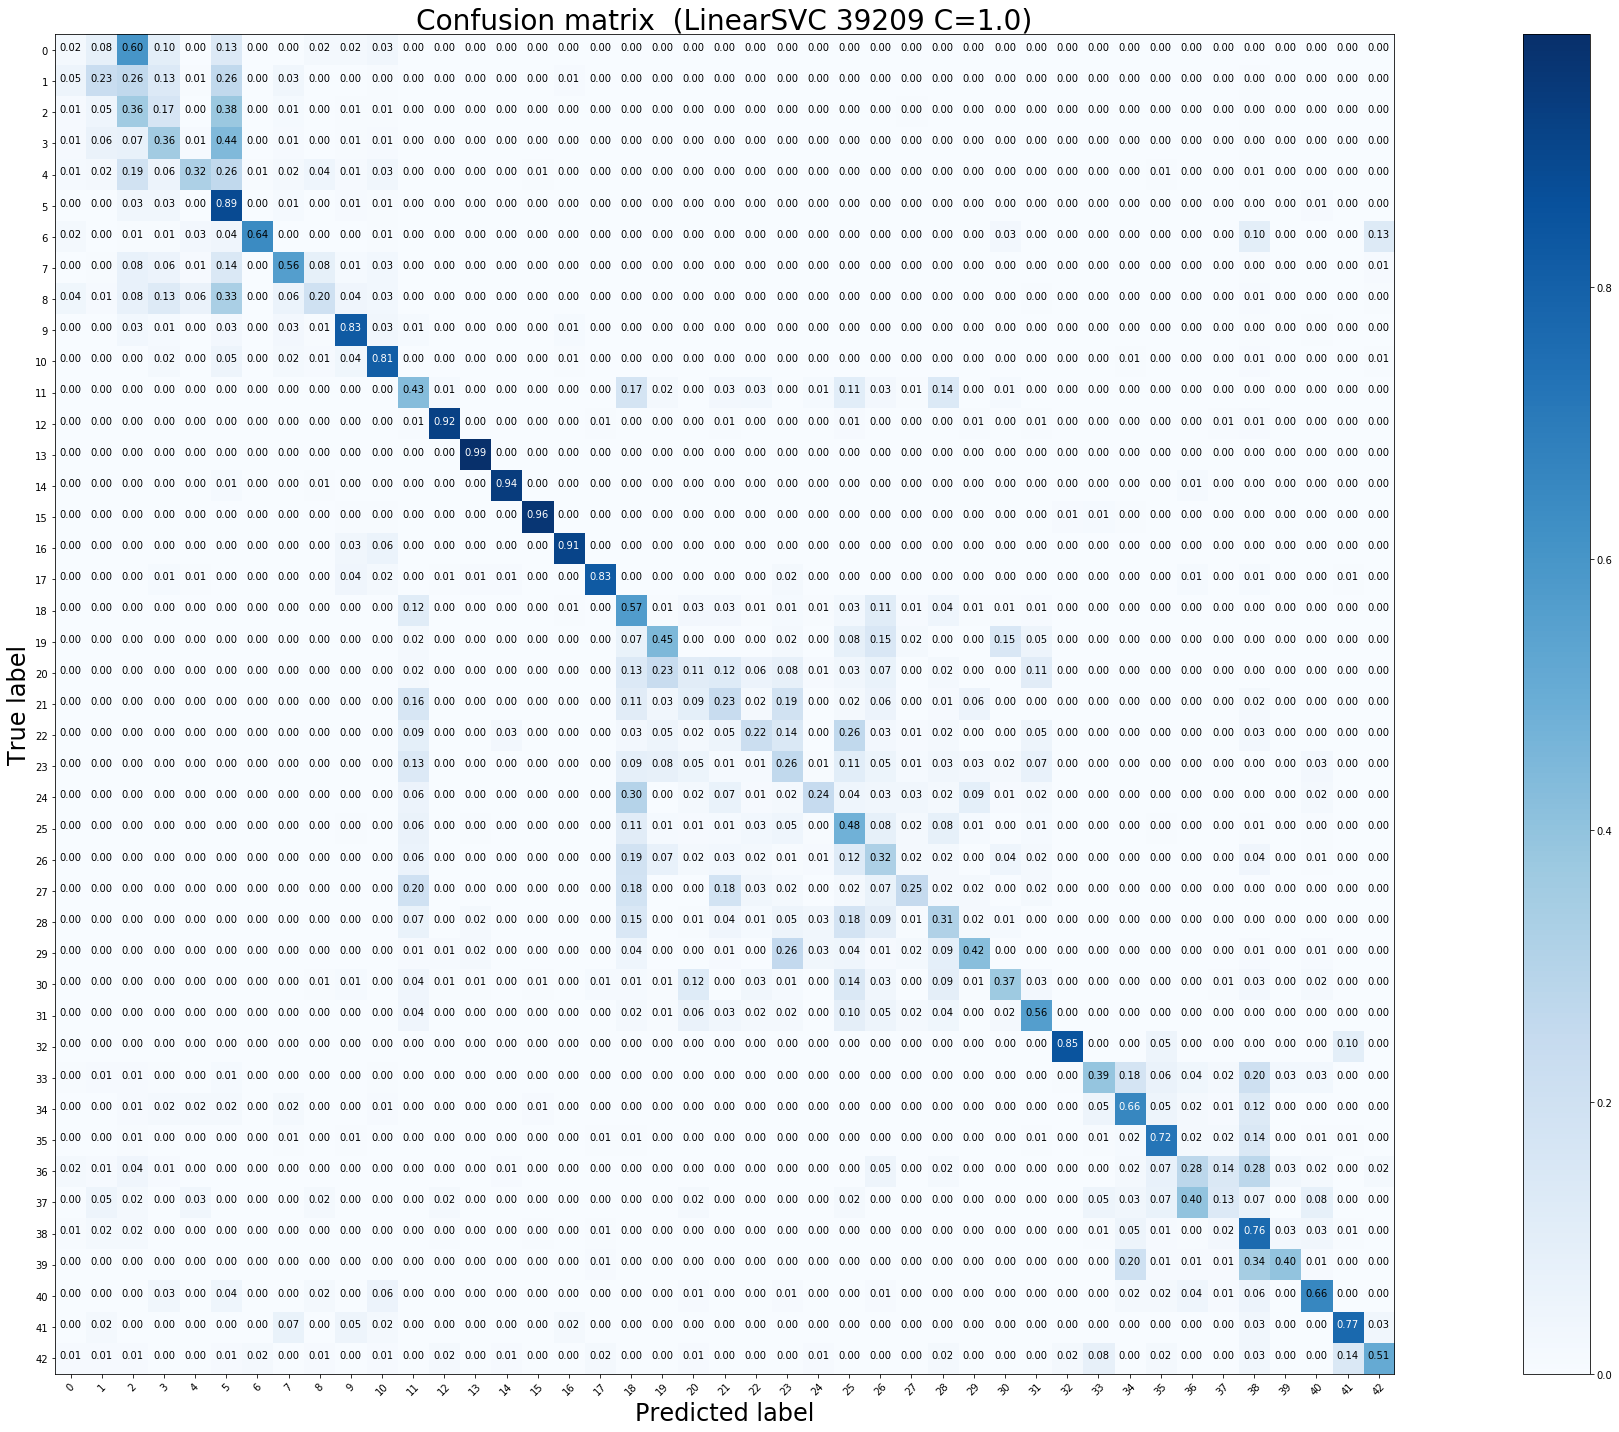

Test accuracy:  0.5828978622327791 

              precision    recall  f1-score   support

           0       0.01      0.02      0.01        60
           1       0.60      0.23      0.33       720
           2       0.34      0.36      0.35       750
           3       0.28      0.36      0.32       450
           4       0.78      0.32      0.46       660
           5       0.33      0.89      0.48       630
           6       0.88      0.64      0.74       150
           7       0.67      0.56      0.61       450
           8       0.51      0.20      0.28       450
           9       0.80      0.83      0.81       480
          10       0.83      0.81      0.82       660
          11       0.49      0.43      0.46       420
          12       0.97      0.92      0.94       690
          13       0.98      0.99      0.98       720
          14       0.95      0.94      0.94       270
          15       0.94      0.96      0.95       210
          16       0.87      0.91      0.89 

In [22]:


#####################################################################################################
###########   LinearSVC, HOG, seed=1, random_A, without_scaler, squared_hinge und l2  ###############
#####################################################################################################

train_LinearSVC(X_tr_500, X_test_vgg16, y_tr_500, y_test, 1, '500',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_1000, X_test_vgg16, y_tr_1000, y_test, 1, '1000',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_2000, X_test_vgg16, y_tr_2000, y_test, 1, '2000',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_5000, X_test_vgg16, y_tr_5000, y_test, 1, '5000',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_10000, X_test_vgg16, y_tr_10000, y_test, 1, '10000',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_20000, X_test_vgg16, y_tr_20000, y_test, 1, '20000',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr, X_test_vgg16, y_tr, y_test, 1, '39209',1.0, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")

In [20]:
#################################################################################################
################## GridSearch LinearSVC, l2, squared_hinge     ##################################
#################################################################################################
################### 1. DL #######################################################################
#################################################################################################

clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2), 'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.4240475006519736

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.5034045922406968
Precision-Score: 0.414961 (0.050903) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.422207 (0.049012) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.429161 (0.076040) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.428058 (0.095742) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.421679 (0.099325) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.408735 (0.102522) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.402130 (0.106263) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.402358 (0.106306) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.403657 (0.106173) mit

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.5120515247761029

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.5353919239904988
Precision-Score: 0.486894 (0.055608) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.509579 (0.056336) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.515461 (0.061735) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.509331 (0.056258) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.518440 (0.046026) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.506669 (0.047954) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.491762 (0.049759) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.491917 (0.050893) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.489882 (0.051025) mit

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.6227446291870224

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.5706254948535233
Precision-Score: 0.592473 (0.045334) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.624681 (0.064784) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.642630 (0.060230) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.623010 (0.058821) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.597900 (0.056447) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.579715 (0.054626) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.570449 (0.052457) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.580228 (0.055312) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.565271 (0.060954) mit

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.7344115222810168

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.6118764845605701
Precision-Score: 0.685848 (0.020106) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.732639 (0.026471) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.752251 (0.027901) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.748728 (0.027908) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.733622 (0.029373) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.731478 (0.034836) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.716451 (0.034376) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.709742 (0.032483) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.715355 (0.037814) mit

In [21]:
print("*************************************************************************")
print("   10.000")
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')
print("*************************************************************************")
print("   20.000")
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')
print("*************************************************************************")
print("   39.209")
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_tr, y_tr, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                np.logspace(-16,10,14, base=2), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_1DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_1_DL.csv')

*************************************************************************
   10.000


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.7823124239111091

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.6323832145684877
Precision-Score: 0.730593 (0.016023) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.769589 (0.015193) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.783651 (0.021960) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.784031 (0.023625) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.771273 (0.021130) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.757124 (0.017637) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.746982 (0.017578) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.746386 (0.014911) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.737368 (0.018154) mit

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.8280092076992214

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.6423594615993666
Precision-Score: 0.773226 (0.009168) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.806867 (0.009704) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.823404 (0.009256) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.823994 (0.010304) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.814584 (0.009229) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.804447 (0.011678) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.794718 (0.014662) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.787805 (0.014373) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.789089 (0.009583) mit

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [1.52587891e-05 6.10351562e-05 2.44140625e-04 9.76562500e-04
 3.90625000e-03 1.56250000e-02 6.25000000e-02 2.50000000e-01
 1.00000000e+00 4.00000000e+00 1.60000000e+01 6.40000000e+01
 2.56000000e+02 1.02400000e+03]

 Bester Score:  0.8518765714772897

 Besten Parameter:  {'svm__C': 0.0009765625}
Bester Estimator score:  0.6499604117181315
Precision-Score: 0.802255 (0.005667) mit Parameter: {'svm__C': 1.52587890625e-05}
Precision-Score: 0.829311 (0.003400) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.842044 (0.003673) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.845183 (0.004991) mit Parameter: {'svm__C': 0.0009765625}
Precision-Score: 0.840657 (0.007242) mit Parameter: {'svm__C': 0.00390625}
Precision-Score: 0.830168 (0.009479) mit Parameter: {'svm__C': 0.015625}
Precision-Score: 0.822667 (0.007606) mit Parameter: {'svm__C': 0.0625}
Precision-Score: 0.812874 (0.006377) mit Parameter: {'svm__C': 0.25}
Precision-Score: 0.814996 (0.011079) mit P

In [22]:
################### 2. DL #######################################################################
#################################################################################################
print("*************************************************************************")
print("   500")
clf_500_lin, time_500_lin = tuning_hyper_params(X_tr_500, y_tr_500, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2), 'l2', 'squared_hinge', 1)
save_trained_model_as_pkl(clf_500_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_500_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/500/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   1.000")
clf_1000_lin, time_1000_lin = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_1000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_1000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/1000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   2.000")
clf_2000_lin, time_2000_lin = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_2000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_2000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/2000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   5.000")
clf_5000_lin, time_5000_lin = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_5000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_5000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/5000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   10.000")
clf_10000_lin, time_10000_lin = tuning_hyper_params(X_tr_10000, y_tr_10000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_10000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_10000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/10000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   20.000")
clf_20000_lin, time_20000_lin = tuning_hyper_params(X_tr_20000, y_tr_20000, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.000244140625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_20000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_20000_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/20000/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')
print("*************************************************************************")
print("   39.209")
clf_39209_lin, time_39209_lin = tuning_hyper_params(X_tr, y_tr, X_test_vgg16, y_test, 'LinearSVC', 10, 0, 0, 
                                                get_finer_range(0.0009765625), np.logspace(-16,4,11, base=2),'l2', 'squared_hinge',1)
save_trained_model_as_pkl(clf_39209_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/GridSearch_2DL.pkl")
save_as_csv(time_39209_lin, "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/39209/seed_1_random_A_without_scaler_l2_sq_hinge/", 'Suchzeiten_GridSearch_2_DL.csv')

*************************************************************************
   500


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [6.10351562e-05 7.25834421e-05 8.63167458e-05 1.02648488e-04
 1.22070312e-04 1.45166884e-04 1.72633492e-04 2.05296976e-04
 2.44140625e-04 2.90333768e-04 3.45266983e-04 4.10593953e-04
 4.88281250e-04 5.80667537e-04 6.90533966e-04 8.21187906e-04
 9.76562500e-04]

 Bester Score:  0.4289337549065533

 Besten Parameter:  {'svm__C': 0.0006905339660024879}
Bester Estimator score:  0.494695170229612
Precision-Score: 0.422207 (0.049012) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.419584 (0.062021) mit Parameter: {'svm__C': 7.25834420778028e-05}
Precision-Score: 0.421218 (0.067094) mit Parameter: {'svm__C': 8.631674575031098e-05}
Precision-Score: 0.423130 (0.065738) mit Parameter: {'svm__C': 0.0001026484881901507}
Precision-Score: 0.428394 (0.065799) mit Parameter: {'svm__C': 0.0001220703125}
Precision-Score: 0.429266 (0.066085) mit Parameter: {'svm__C': 0.0001451668841556056}
Precision-Score: 0.433313 (0.072712) mit Parameter: {'svm__C': 0.00017263349150062197}
Prec

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range: [6.10351562e-05 7.25834421e-05 8.63167458e-05 1.02648488e-04
 1.22070312e-04 1.45166884e-04 1.72633492e-04 2.05296976e-04
 2.44140625e-04 2.90333768e-04 3.45266983e-04 4.10593953e-04
 4.88281250e-04 5.80667537e-04 6.90533966e-04 8.21187906e-04
 9.76562500e-04]

 Bester Score:  0.5147216330438902

 Besten Parameter:  {'svm__C': 0.0001451668841556056}
Bester Estimator score:  0.5384006334125099
Precision-Score: 0.509579 (0.056336) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.510582 (0.055239) mit Parameter: {'svm__C': 7.25834420778028e-05}
Precision-Score: 0.511786 (0.055180) mit Parameter: {'svm__C': 8.631674575031098e-05}
Precision-Score: 0.507744 (0.057076) mit Parameter: {'svm__C': 0.0001026484881901507}
Precision-Score: 0.512421 (0.057860) mit Parameter: {'svm__C': 0.0001220703125}
Precision-Score: 0.515620 (0.059776) mit Parameter: {'svm__C': 0.0001451668841556056}
Precision-Score: 0.516881 (0.061074) mit Parameter: {'svm__C': 0.00017263349150062197}
Pre

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [6.10351562e-05 7.25834421e-05 8.63167458e-05 1.02648488e-04
 1.22070312e-04 1.45166884e-04 1.72633492e-04 2.05296976e-04
 2.44140625e-04 2.90333768e-04 3.45266983e-04 4.10593953e-04
 4.88281250e-04 5.80667537e-04 6.90533966e-04 8.21187906e-04
 9.76562500e-04]

 Bester Score:  0.7355692302506668

 Besten Parameter:  {'svm__C': 0.0004105939527606028}
Bester Estimator score:  0.6127474267616786
Precision-Score: 0.732639 (0.026471) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.734928 (0.029447) mit Parameter: {'svm__C': 7.25834420778028e-05}
Precision-Score: 0.736657 (0.032071) mit Parameter: {'svm__C': 8.631674575031098e-05}
Precision-Score: 0.737027 (0.030569) mit Parameter: {'svm__C': 0.0001026484881901507}
Precision-Score: 0.742103 (0.031301) mit Parameter: {'svm__C': 0.0001220703125}
Precision-Score: 0.747629 (0.024031) mit Parameter: {'svm__C': 0.0001451668841556056}
Precision-Score: 0.748415 (0.021296) mit Parameter: {'svm__C': 0.00017263349150062197}
Pre

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [6.10351562e-05 7.25834421e-05 8.63167458e-05 1.02648488e-04
 1.22070312e-04 1.45166884e-04 1.72633492e-04 2.05296976e-04
 2.44140625e-04 2.90333768e-04 3.45266983e-04 4.10593953e-04
 4.88281250e-04 5.80667537e-04 6.90533966e-04 8.21187906e-04
 9.76562500e-04]

 Bester Score:  0.7823124239111091

 Besten Parameter:  {'svm__C': 0.000244140625}
Bester Estimator score:  0.6323832145684877
Precision-Score: 0.769589 (0.015193) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.770235 (0.015851) mit Parameter: {'svm__C': 7.25834420778028e-05}
Precision-Score: 0.772197 (0.016975) mit Parameter: {'svm__C': 8.631674575031098e-05}
Precision-Score: 0.774447 (0.021270) mit Parameter: {'svm__C': 0.0001026484881901507}
Precision-Score: 0.777111 (0.020007) mit Parameter: {'svm__C': 0.0001220703125}
Precision-Score: 0.779949 (0.019791) mit Parameter: {'svm__C': 0.0001451668841556056}
Precision-Score: 0.780276 (0.019514) mit Parameter: {'svm__C': 0.00017263349150062197}
Precision-

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [6.10351562e-05 7.25834421e-05 8.63167458e-05 1.02648488e-04
 1.22070312e-04 1.45166884e-04 1.72633492e-04 2.05296976e-04
 2.44140625e-04 2.90333768e-04 3.45266983e-04 4.10593953e-04
 4.88281250e-04 5.80667537e-04 6.90533966e-04 8.21187906e-04
 9.76562500e-04]

 Bester Score:  0.8291468744232463

 Besten Parameter:  {'svm__C': 0.00034526698300124393}
Bester Estimator score:  0.641409342834521
Precision-Score: 0.806867 (0.009704) mit Parameter: {'svm__C': 6.103515625e-05}
Precision-Score: 0.810361 (0.010313) mit Parameter: {'svm__C': 7.25834420778028e-05}
Precision-Score: 0.813059 (0.008959) mit Parameter: {'svm__C': 8.631674575031098e-05}
Precision-Score: 0.815312 (0.009590) mit Parameter: {'svm__C': 0.0001026484881901507}
Precision-Score: 0.816676 (0.009196) mit Parameter: {'svm__C': 0.0001220703125}
Precision-Score: 0.820132 (0.007919) mit Parameter: {'svm__C': 0.0001451668841556056}
Precision-Score: 0.820424 (0.008810) mit Parameter: {'svm__C': 0.00017263349150062197}
Pre

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C_range: [0.00024414 0.00029033 0.00034527 0.00041059 0.00048828 0.00058067
 0.00069053 0.00082119 0.00097656 0.00116134 0.00138107 0.00164238
 0.00195312 0.00232267 0.00276214 0.00328475 0.00390625]

 Bester Score:  0.8527335863539613

 Besten Parameter:  {'svm__C': 0.0008211879055212056}
Bester Estimator score:  0.6508313539192399
Precision-Score: 0.842044 (0.003673) mit Parameter: {'svm__C': 0.000244140625}
Precision-Score: 0.842625 (0.002904) mit Parameter: {'svm__C': 0.0002903337683112112}
Precision-Score: 0.843237 (0.003289) mit Parameter: {'svm__C': 0.00034526698300124393}
Precision-Score: 0.843956 (0.003624) mit Parameter: {'svm__C': 0.0004105939527606028}
Precision-Score: 0.844642 (0.003207) mit Parameter: {'svm__C': 0.00048828125}
Precision-Score: 0.844912 (0.003325) mit Parameter: {'svm__C': 0.0005806675366224224}
Precision-Score: 0.845039 (0.004169) mit Parameter: {'svm__C': 0.0006905339660024879}
Precision-Score: 0.845452 (0.004528) mit Parameter: {'svm__C': 0.0008211879

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


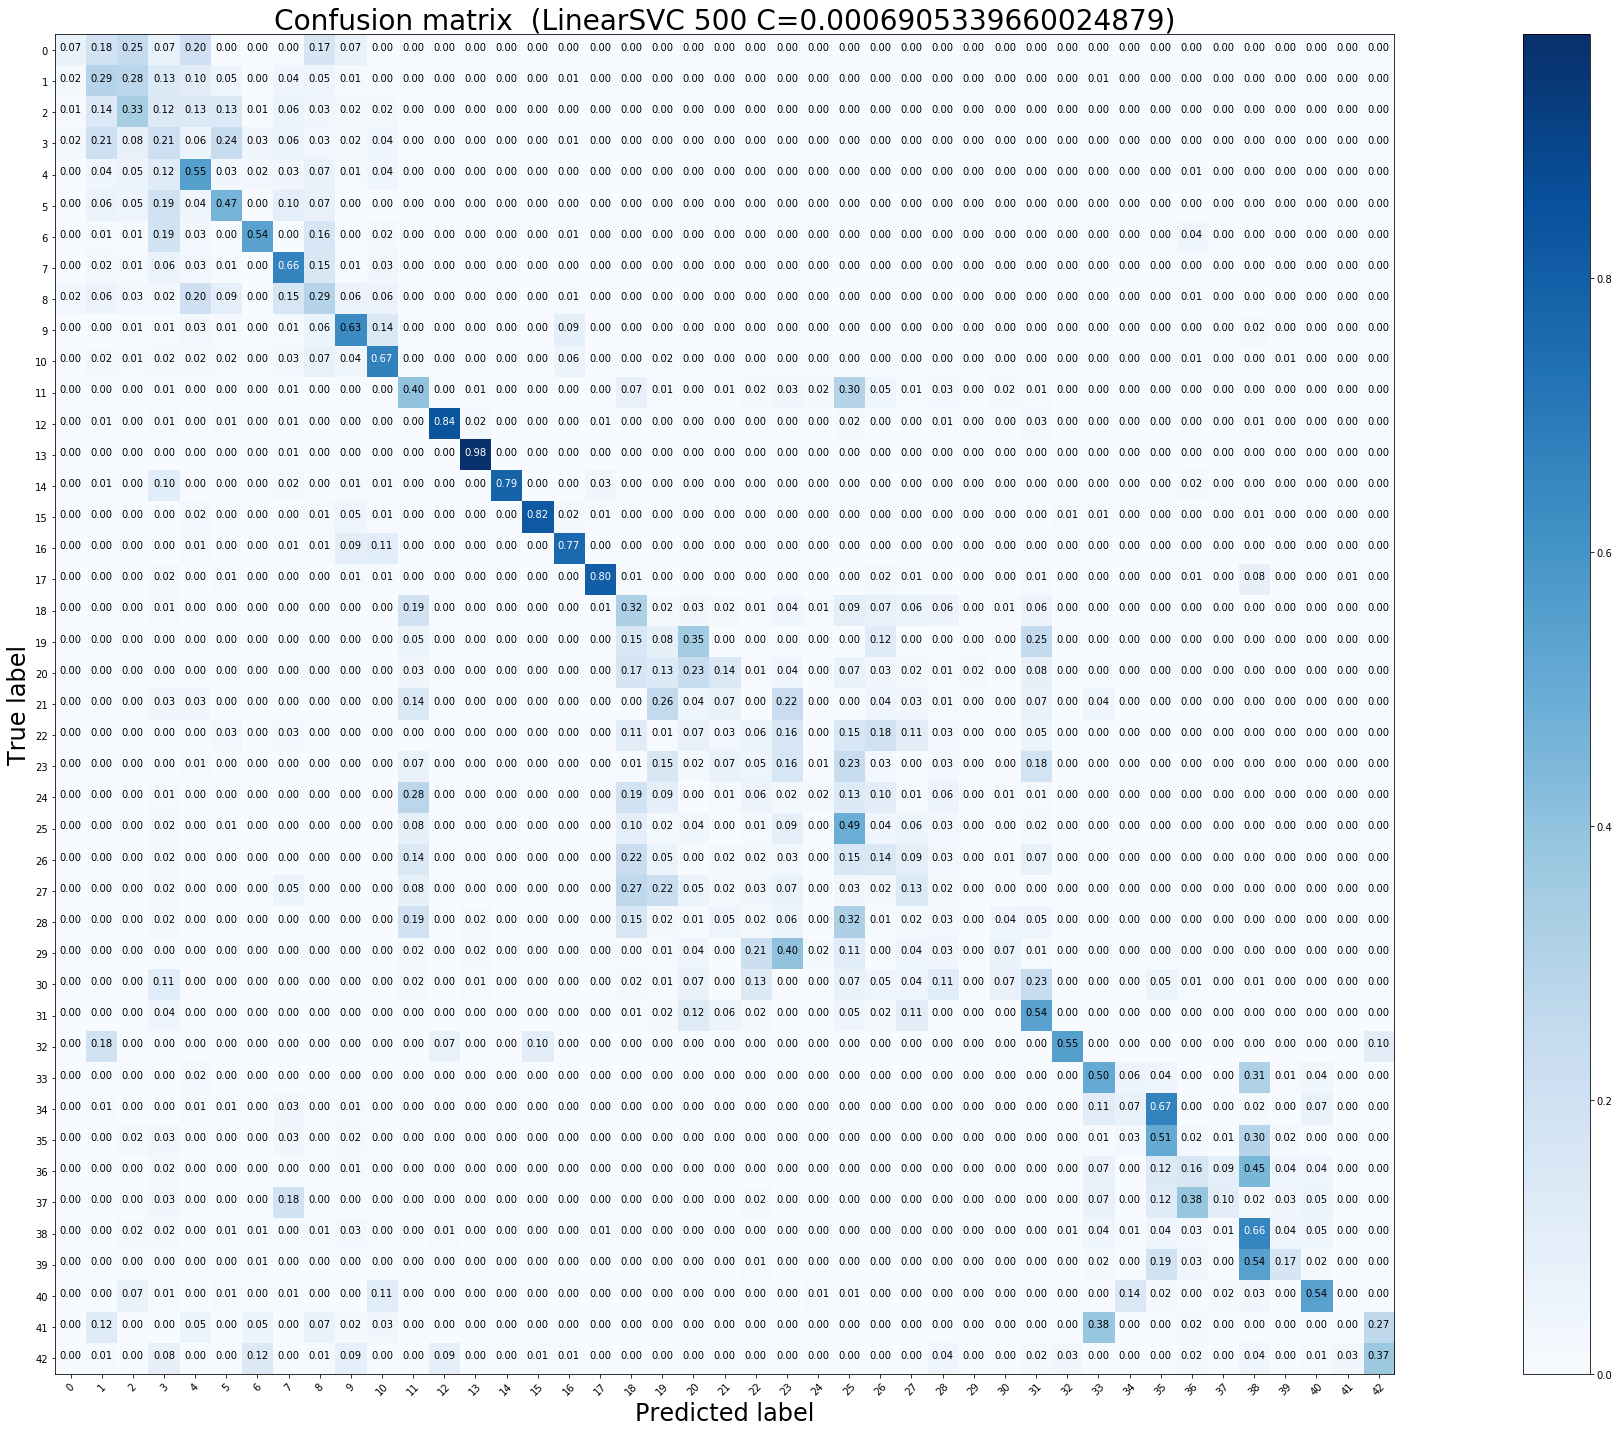

Test accuracy:  0.494695170229612 

              precision    recall  f1-score   support

           0       0.09      0.07      0.08        60
           1       0.37      0.29      0.33       720
           2       0.41      0.33      0.37       750
           3       0.13      0.21      0.16       450
           4       0.48      0.55      0.51       660
           5       0.46      0.47      0.46       630
           6       0.55      0.54      0.54       150
           7       0.47      0.66      0.55       450
           8       0.27      0.29      0.28       450
           9       0.65      0.63      0.64       480
          10       0.68      0.67      0.68       660
          11       0.42      0.40      0.41       420
          12       0.96      0.84      0.90       690
          13       0.96      0.98      0.97       720
          14       0.99      0.79      0.88       270
          15       0.96      0.82      0.89       210
          16       0.53      0.77      0.62  

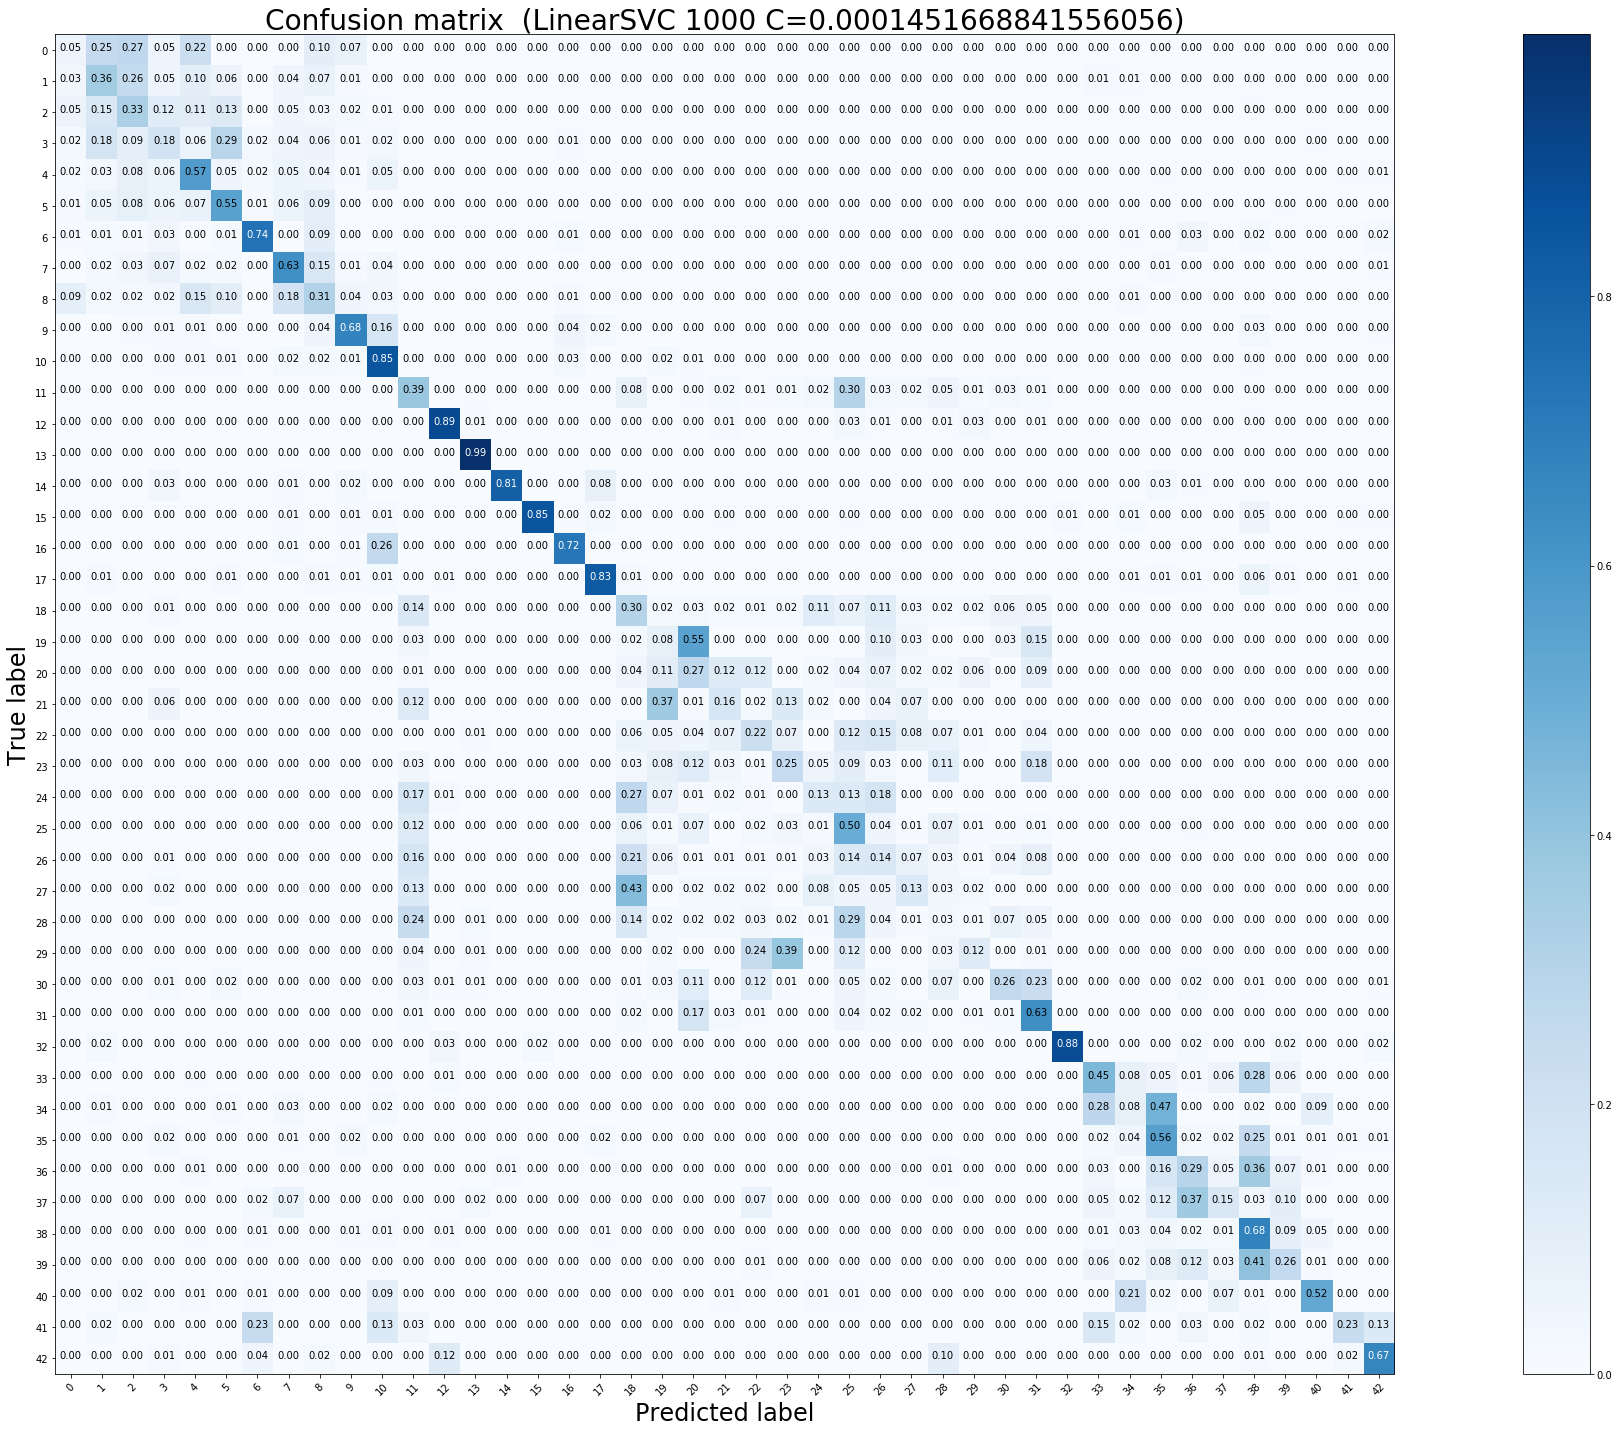

Test accuracy:  0.5384006334125099 

              precision    recall  f1-score   support

           0       0.02      0.05      0.03        60
           1       0.47      0.36      0.41       720
           2       0.40      0.33      0.36       750
           3       0.22      0.18      0.20       450
           4       0.53      0.57      0.55       660
           5       0.48      0.55      0.52       630
           6       0.64      0.74      0.69       150
           7       0.51      0.63      0.56       450
           8       0.32      0.31      0.31       450
           9       0.78      0.68      0.72       480
          10       0.71      0.85      0.77       660
          11       0.41      0.39      0.40       420
          12       0.95      0.89      0.92       690
          13       0.98      0.99      0.99       720
          14       1.00      0.81      0.89       270
          15       0.99      0.85      0.92       210
          16       0.66      0.72      0.69 

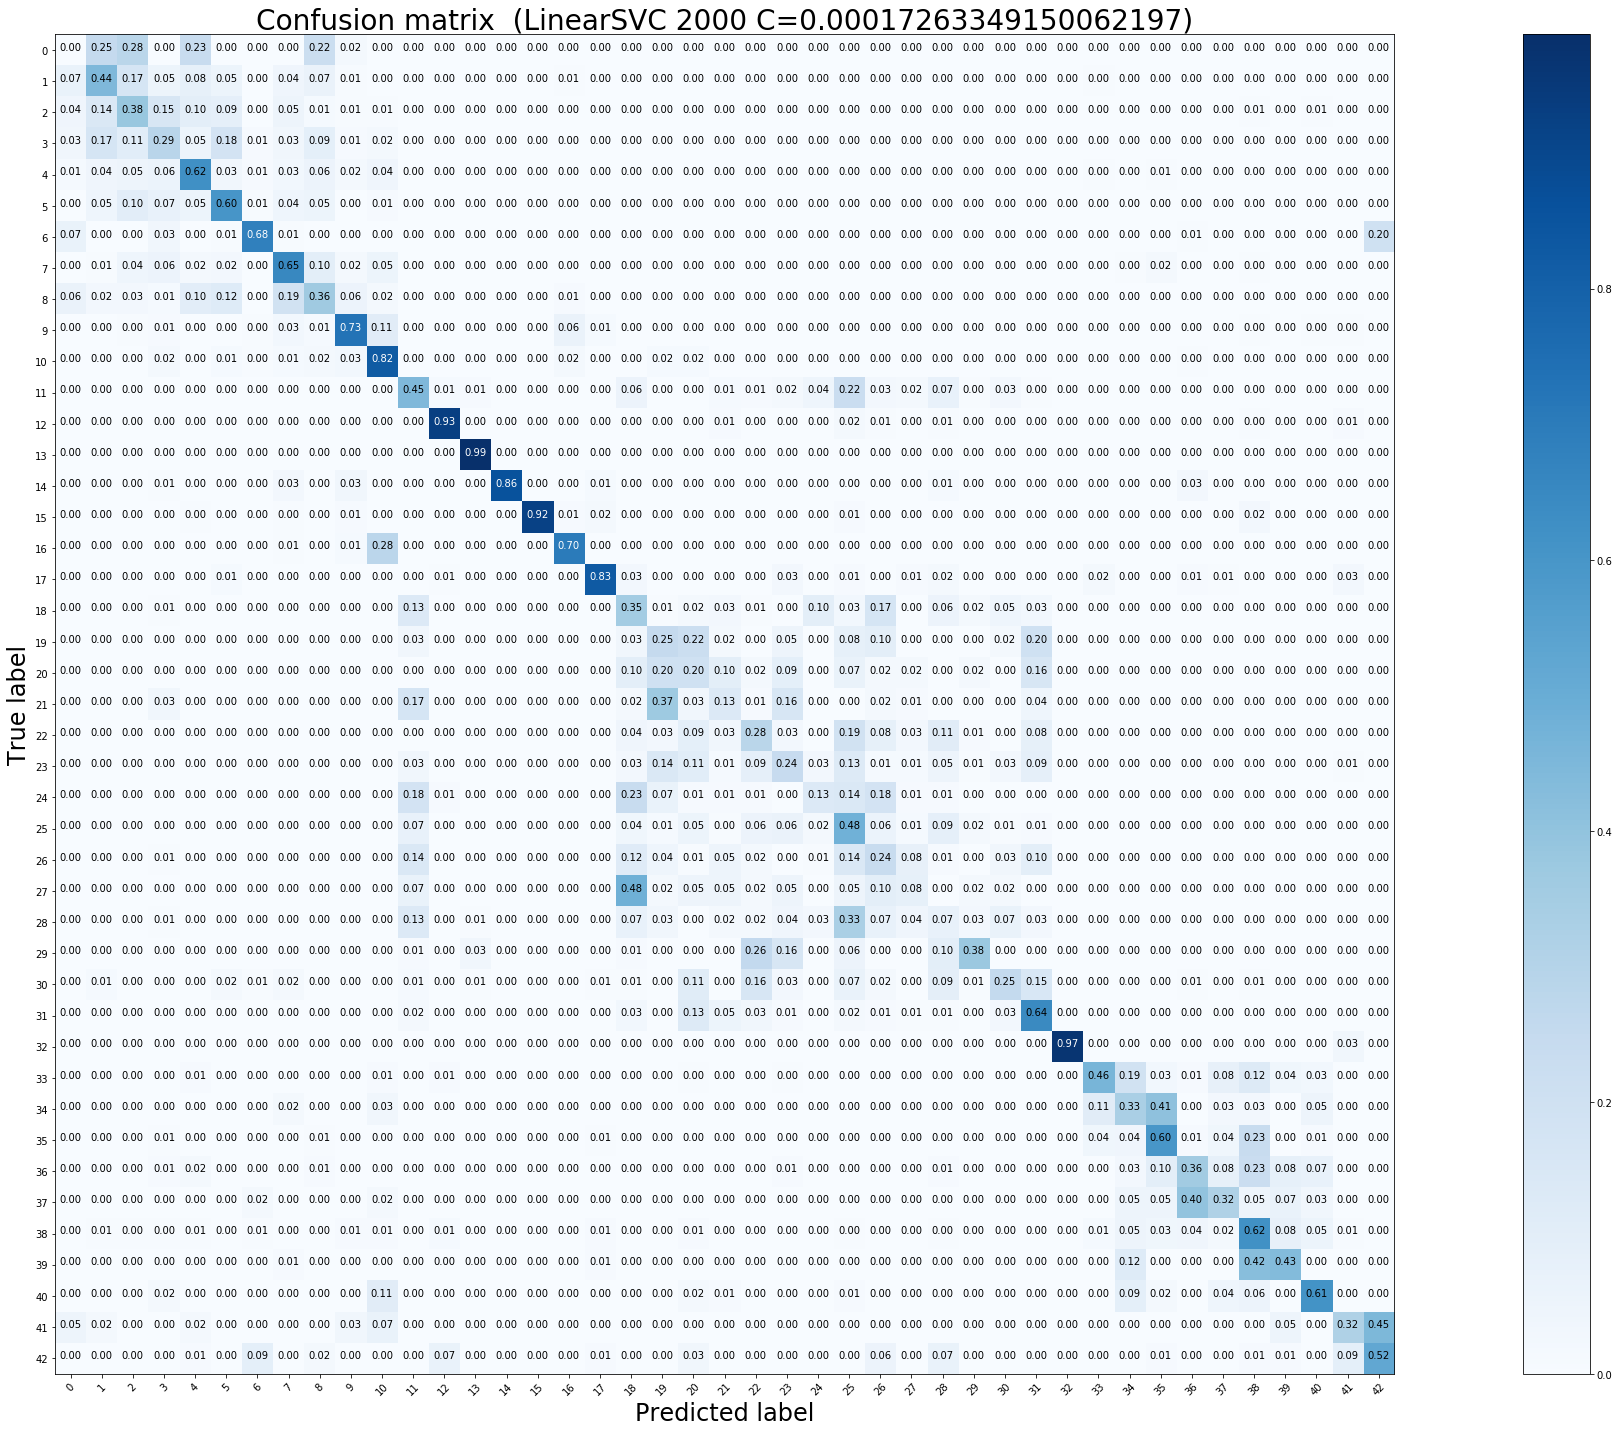

Test accuracy:  0.5718923198733175 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.54      0.44      0.49       720
           2       0.47      0.38      0.42       750
           3       0.29      0.29      0.29       450
           4       0.60      0.62      0.61       660
           5       0.57      0.60      0.58       630
           6       0.72      0.68      0.70       150
           7       0.54      0.65      0.59       450
           8       0.39      0.36      0.38       450
           9       0.77      0.73      0.75       480
          10       0.73      0.82      0.77       660
          11       0.50      0.45      0.47       420
          12       0.96      0.93      0.94       690
          13       0.98      0.99      0.99       720
          14       1.00      0.86      0.92       270
          15       0.96      0.92      0.94       210
          16       0.64      0.70      0.67 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


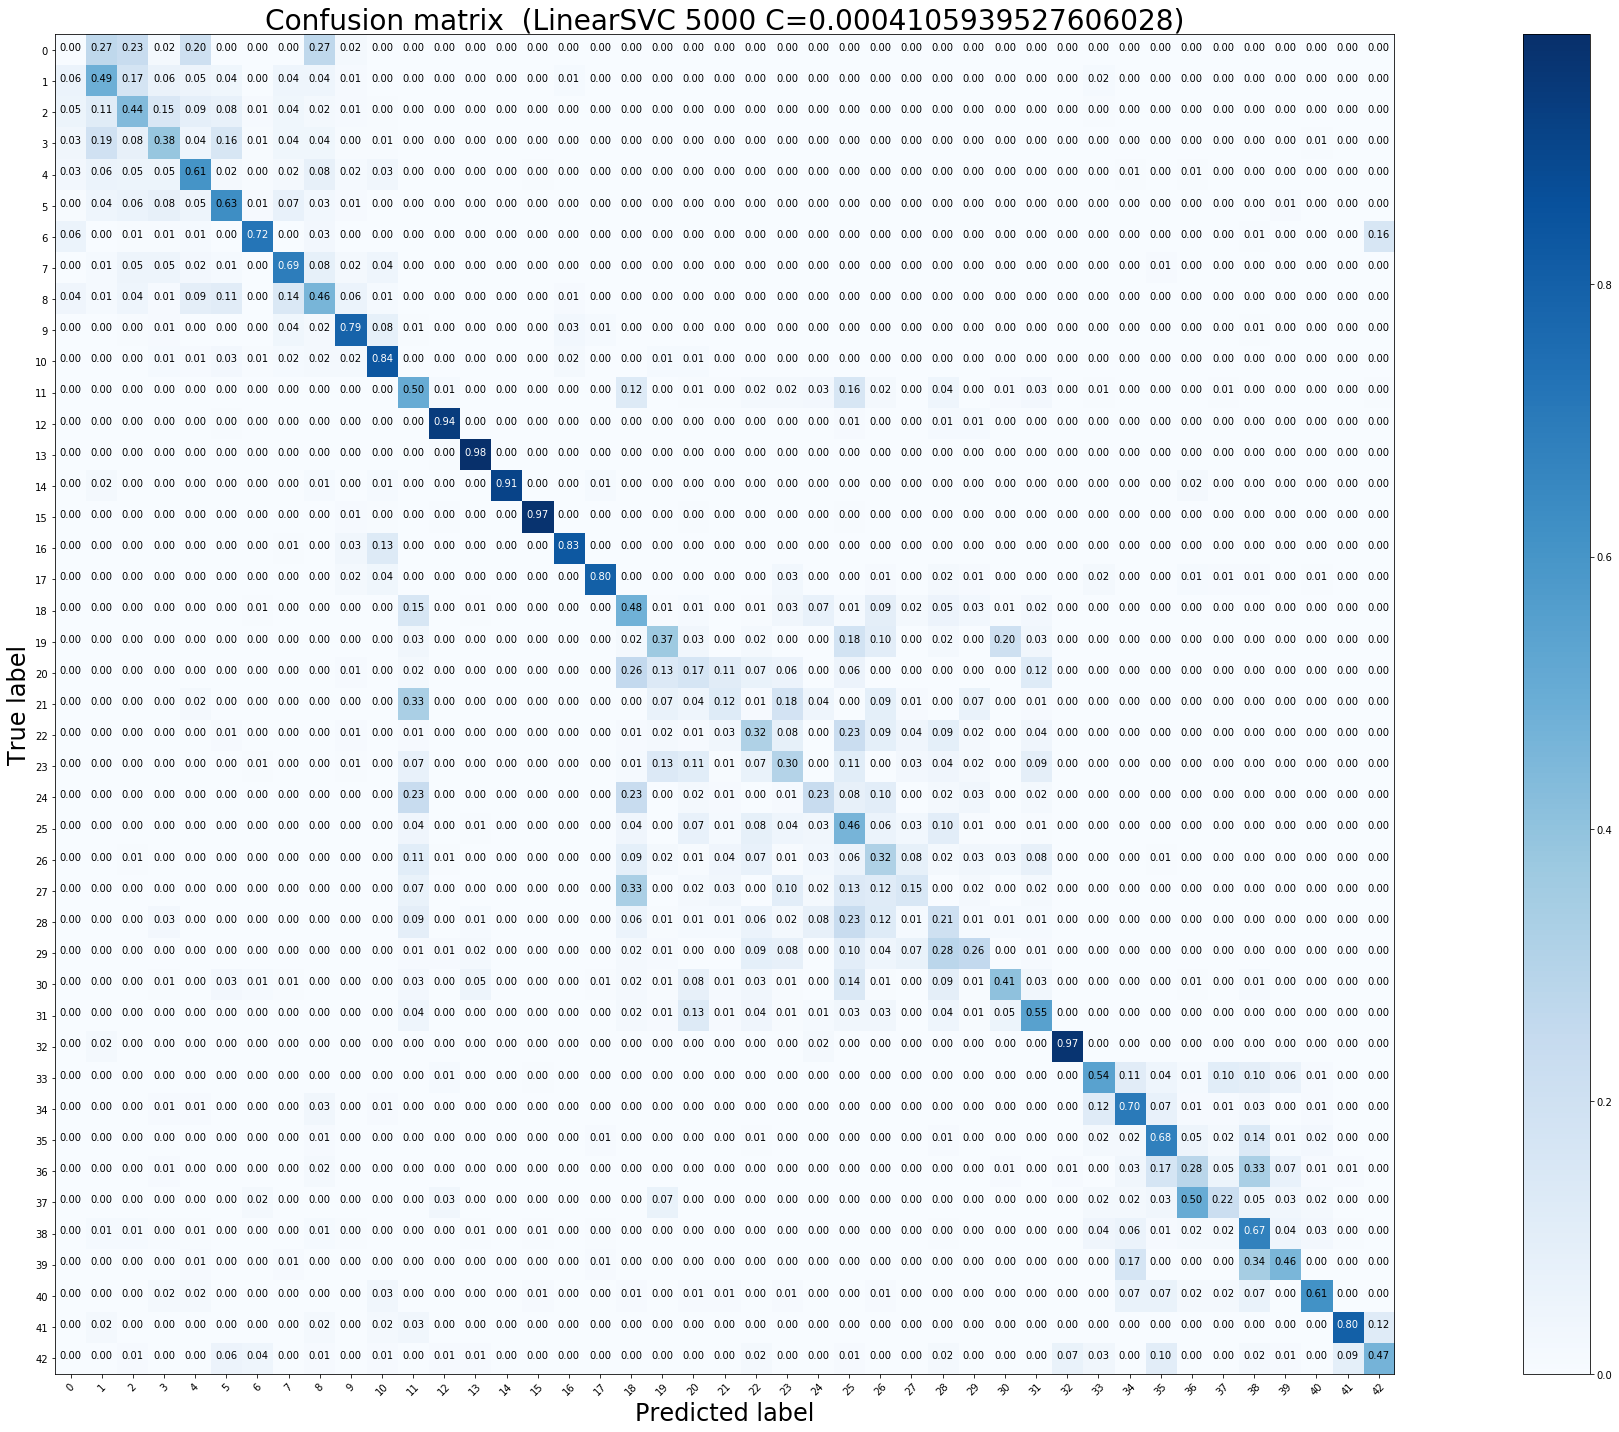

Test accuracy:  0.6127474267616786 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.55      0.49      0.52       720
           2       0.52      0.44      0.48       750
           3       0.37      0.38      0.38       450
           4       0.63      0.61      0.62       660
           5       0.61      0.63      0.62       630
           6       0.74      0.72      0.73       150
           7       0.57      0.69      0.63       450
           8       0.47      0.46      0.46       450
           9       0.79      0.79      0.79       480
          10       0.80      0.84      0.82       660
          11       0.50      0.50      0.50       420
          12       0.97      0.94      0.95       690
          13       0.97      0.98      0.98       720
          14       0.98      0.91      0.94       270
          15       0.95      0.97      0.96       210
          16       0.75      0.83      0.79 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


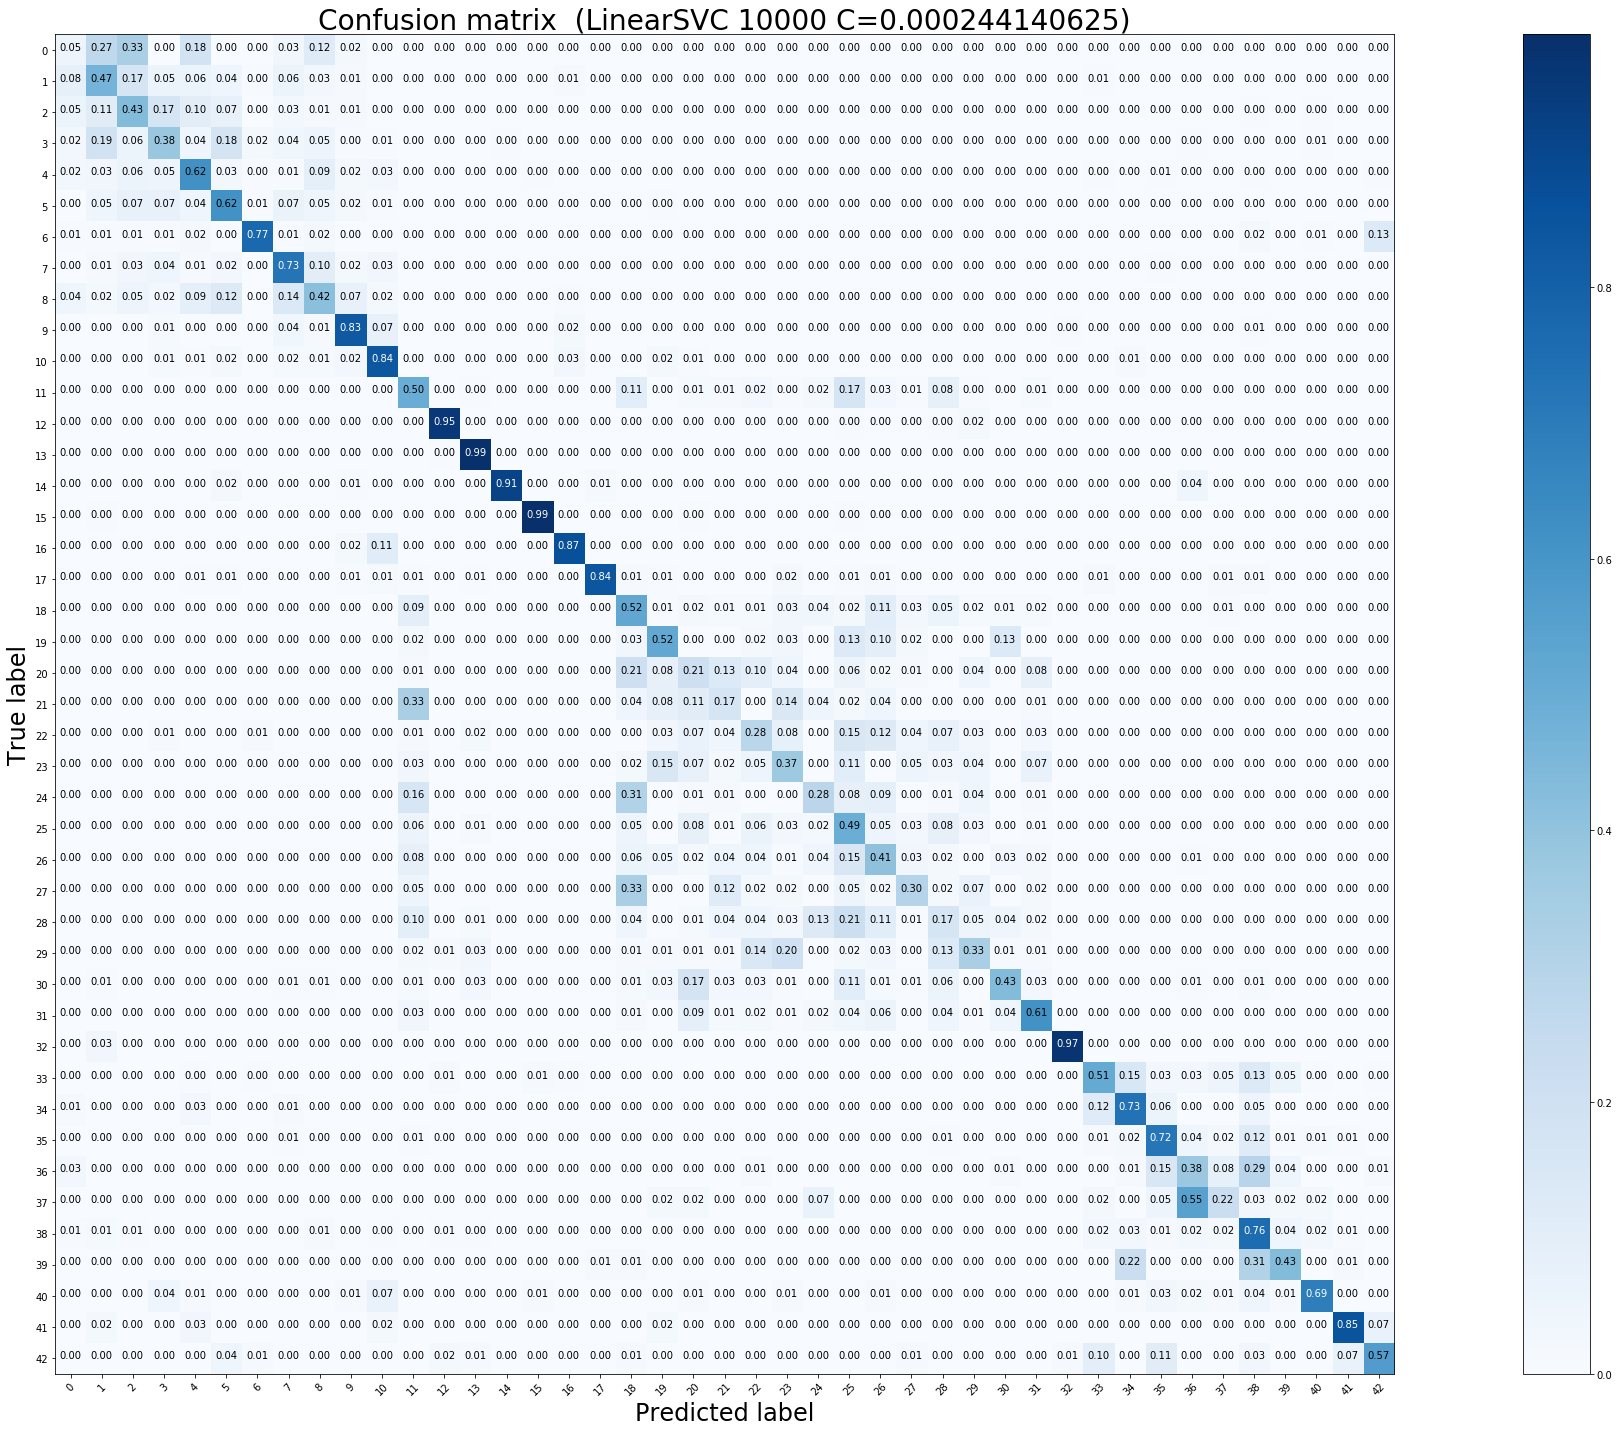

Test accuracy:  0.6323832145684877 

              precision    recall  f1-score   support

           0       0.02      0.05      0.03        60
           1       0.56      0.47      0.51       720
           2       0.52      0.43      0.47       750
           3       0.37      0.38      0.37       450
           4       0.63      0.62      0.62       660
           5       0.58      0.62      0.60       630
           6       0.82      0.77      0.79       150
           7       0.59      0.73      0.65       450
           8       0.47      0.42      0.44       450
           9       0.79      0.83      0.81       480
          10       0.82      0.84      0.83       660
          11       0.56      0.50      0.53       420
          12       0.98      0.95      0.97       690
          13       0.97      0.99      0.98       720
          14       0.98      0.91      0.95       270
          15       0.95      0.99      0.97       210
          16       0.76      0.87      0.81 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


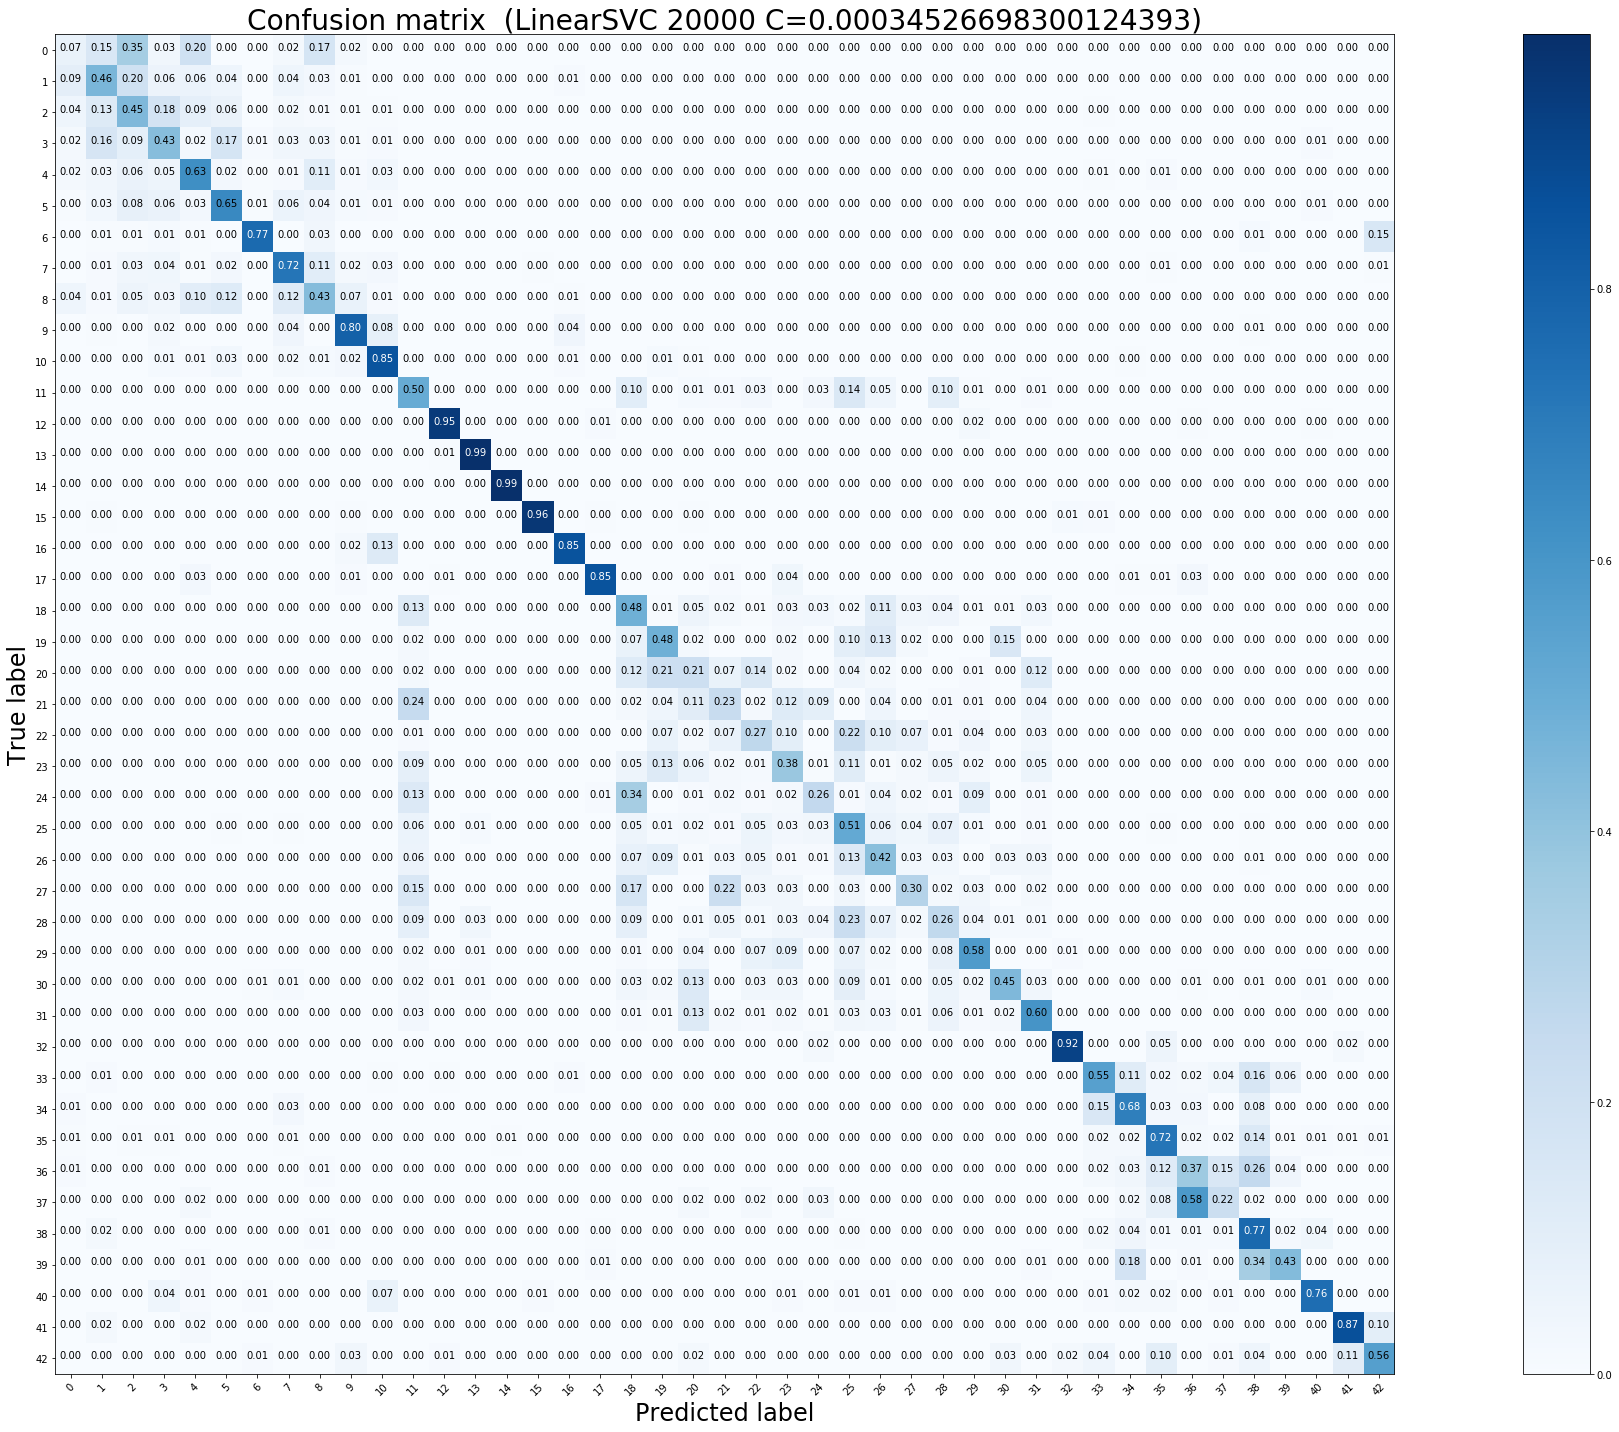

Test accuracy:  0.641409342834521 

              precision    recall  f1-score   support

           0       0.03      0.07      0.04        60
           1       0.57      0.46      0.51       720
           2       0.50      0.45      0.47       750
           3       0.39      0.43      0.41       450
           4       0.66      0.63      0.64       660
           5       0.61      0.65      0.63       630
           6       0.86      0.77      0.81       150
           7       0.61      0.72      0.66       450
           8       0.47      0.43      0.45       450
           9       0.80      0.80      0.80       480
          10       0.83      0.85      0.84       660
          11       0.54      0.50      0.52       420
          12       0.98      0.95      0.96       690
          13       0.97      0.99      0.98       720
          14       0.98      0.99      0.98       270
          15       0.97      0.96      0.96       210
          16       0.77      0.85      0.81  

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


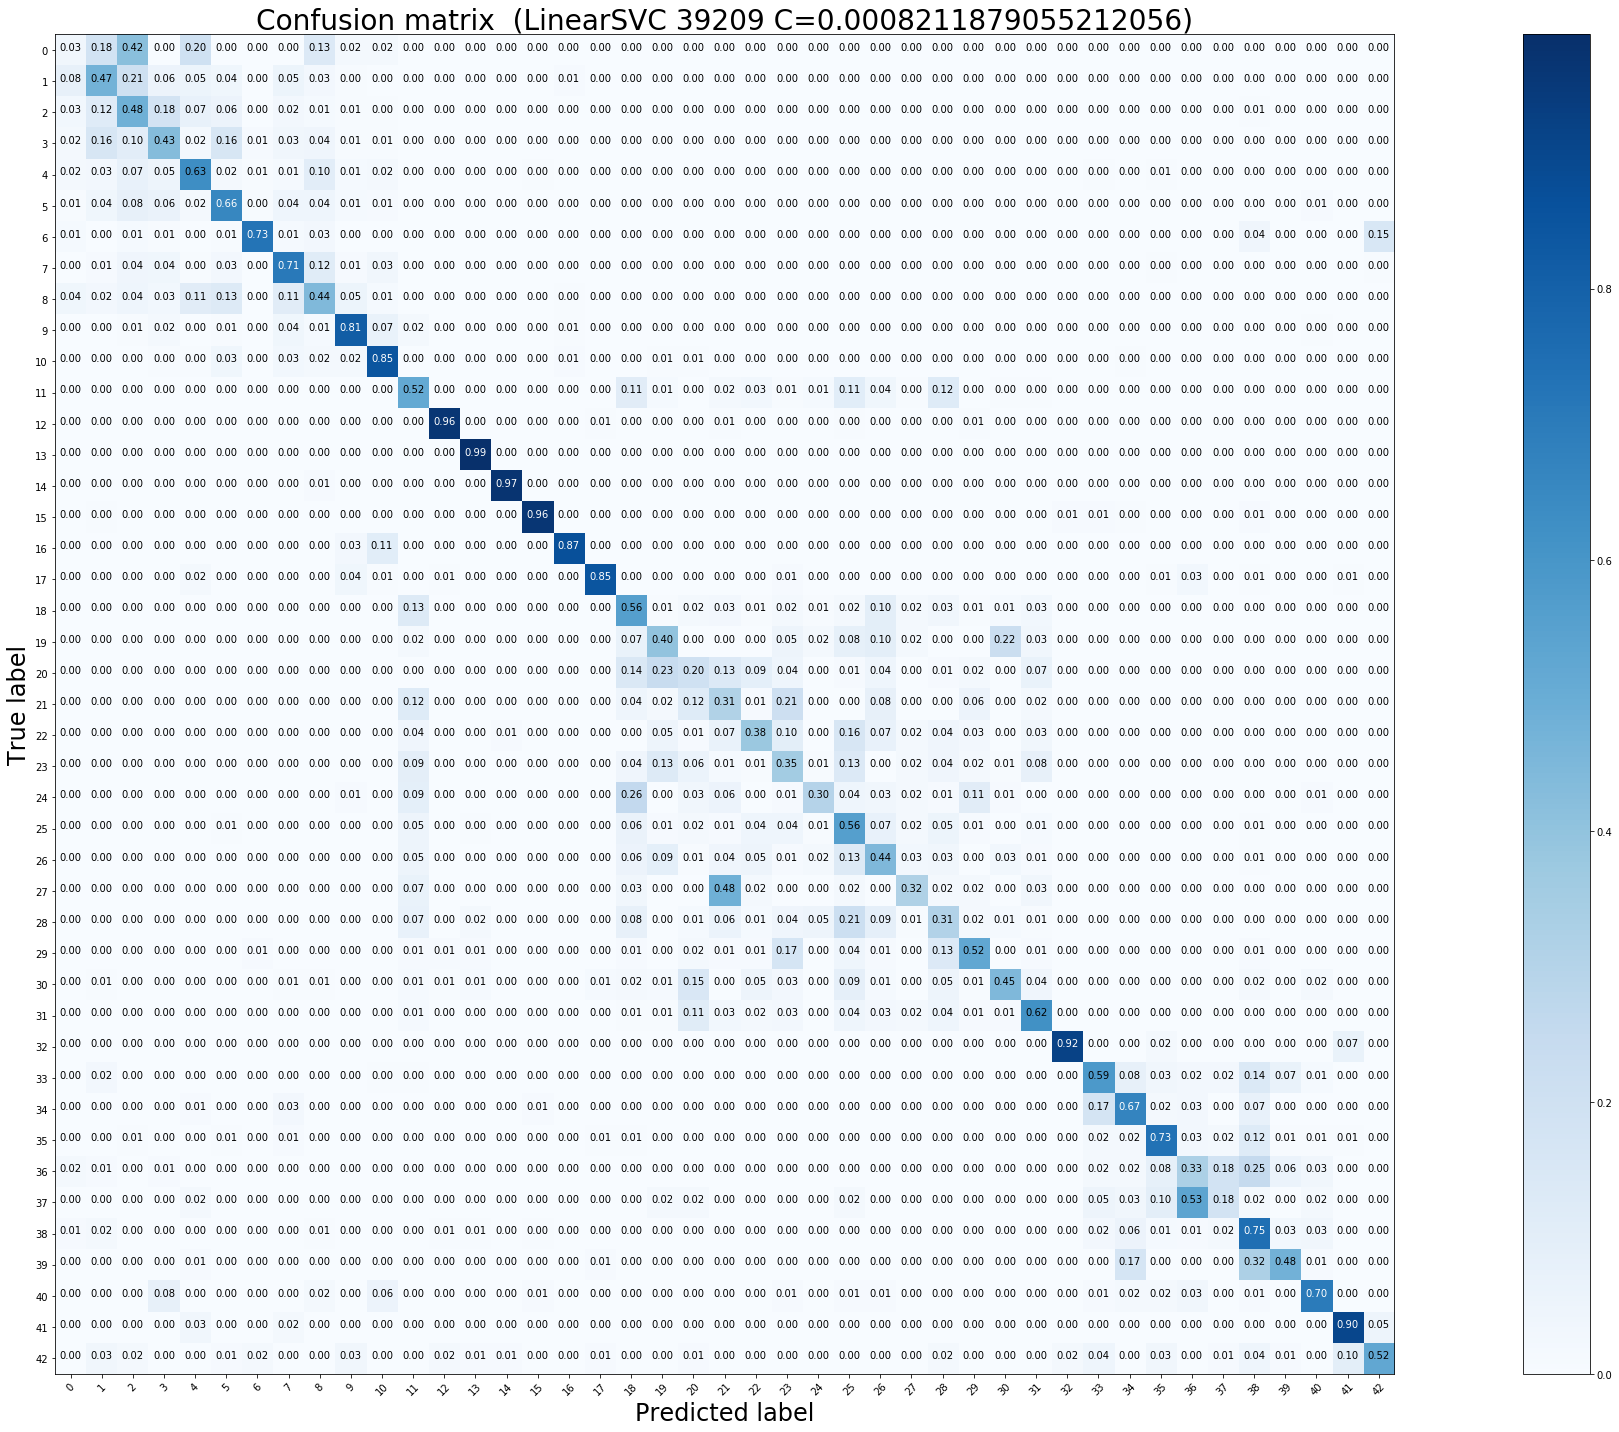

Test accuracy:  0.6508313539192399 

              precision    recall  f1-score   support

           0       0.01      0.03      0.02        60
           1       0.57      0.47      0.52       720
           2       0.50      0.48      0.49       750
           3       0.39      0.43      0.41       450
           4       0.68      0.63      0.65       660
           5       0.62      0.66      0.64       630
           6       0.84      0.73      0.78       150
           7       0.61      0.71      0.65       450
           8       0.46      0.44      0.45       450
           9       0.81      0.81      0.81       480
          10       0.84      0.85      0.84       660
          11       0.57      0.52      0.54       420
          12       0.98      0.96      0.97       690
          13       0.98      0.99      0.98       720
          14       0.97      0.97      0.97       270
          15       0.95      0.96      0.96       210
          16       0.87      0.87      0.87 

In [23]:
# LinearSVC, l2, squared_hinge, mit optimierten C's trainieren
train_LinearSVC(X_tr_500, X_test_vgg16, y_tr_500, y_test, 1, '500',0.0006905339660024879, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_1000, X_test_vgg16, y_tr_1000, y_test, 1, '1000',0.0001451668841556056, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_2000, X_test_vgg16, y_tr_2000, y_test, 1, '2000',0.00017263349150062197, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_5000, X_test_vgg16, y_tr_5000, y_test, 1, '5000',0.0004105939527606028, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_10000, X_test_vgg16, y_tr_10000, y_test, 1, '10000',0.000244140625, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr_20000, X_test_vgg16, y_tr_20000, y_test, 1, '20000',0.00034526698300124393, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")
train_LinearSVC(X_tr, X_test_vgg16, y_tr, y_test, 1, '39209',0.0008211879055212056, 'l2', 'squared_hinge', 0, 0, 'balanced',
               "SVM_Modelle_GTSRB/VGG16_opt/LinearSVC/Neue Mengen/", "seed_1_random_A_without_scaler_l2_sq_hinge", "VGG16_balanced.pkl")

In [18]:
np.logspace(-20,10,16, base=2)

array([9.53674316e-07, 3.81469727e-06, 1.52587891e-05, 6.10351562e-05,
       2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
       6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
       1.60000000e+01, 6.40000000e+01, 2.56000000e+02, 1.02400000e+03])

Daten skalieren


C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


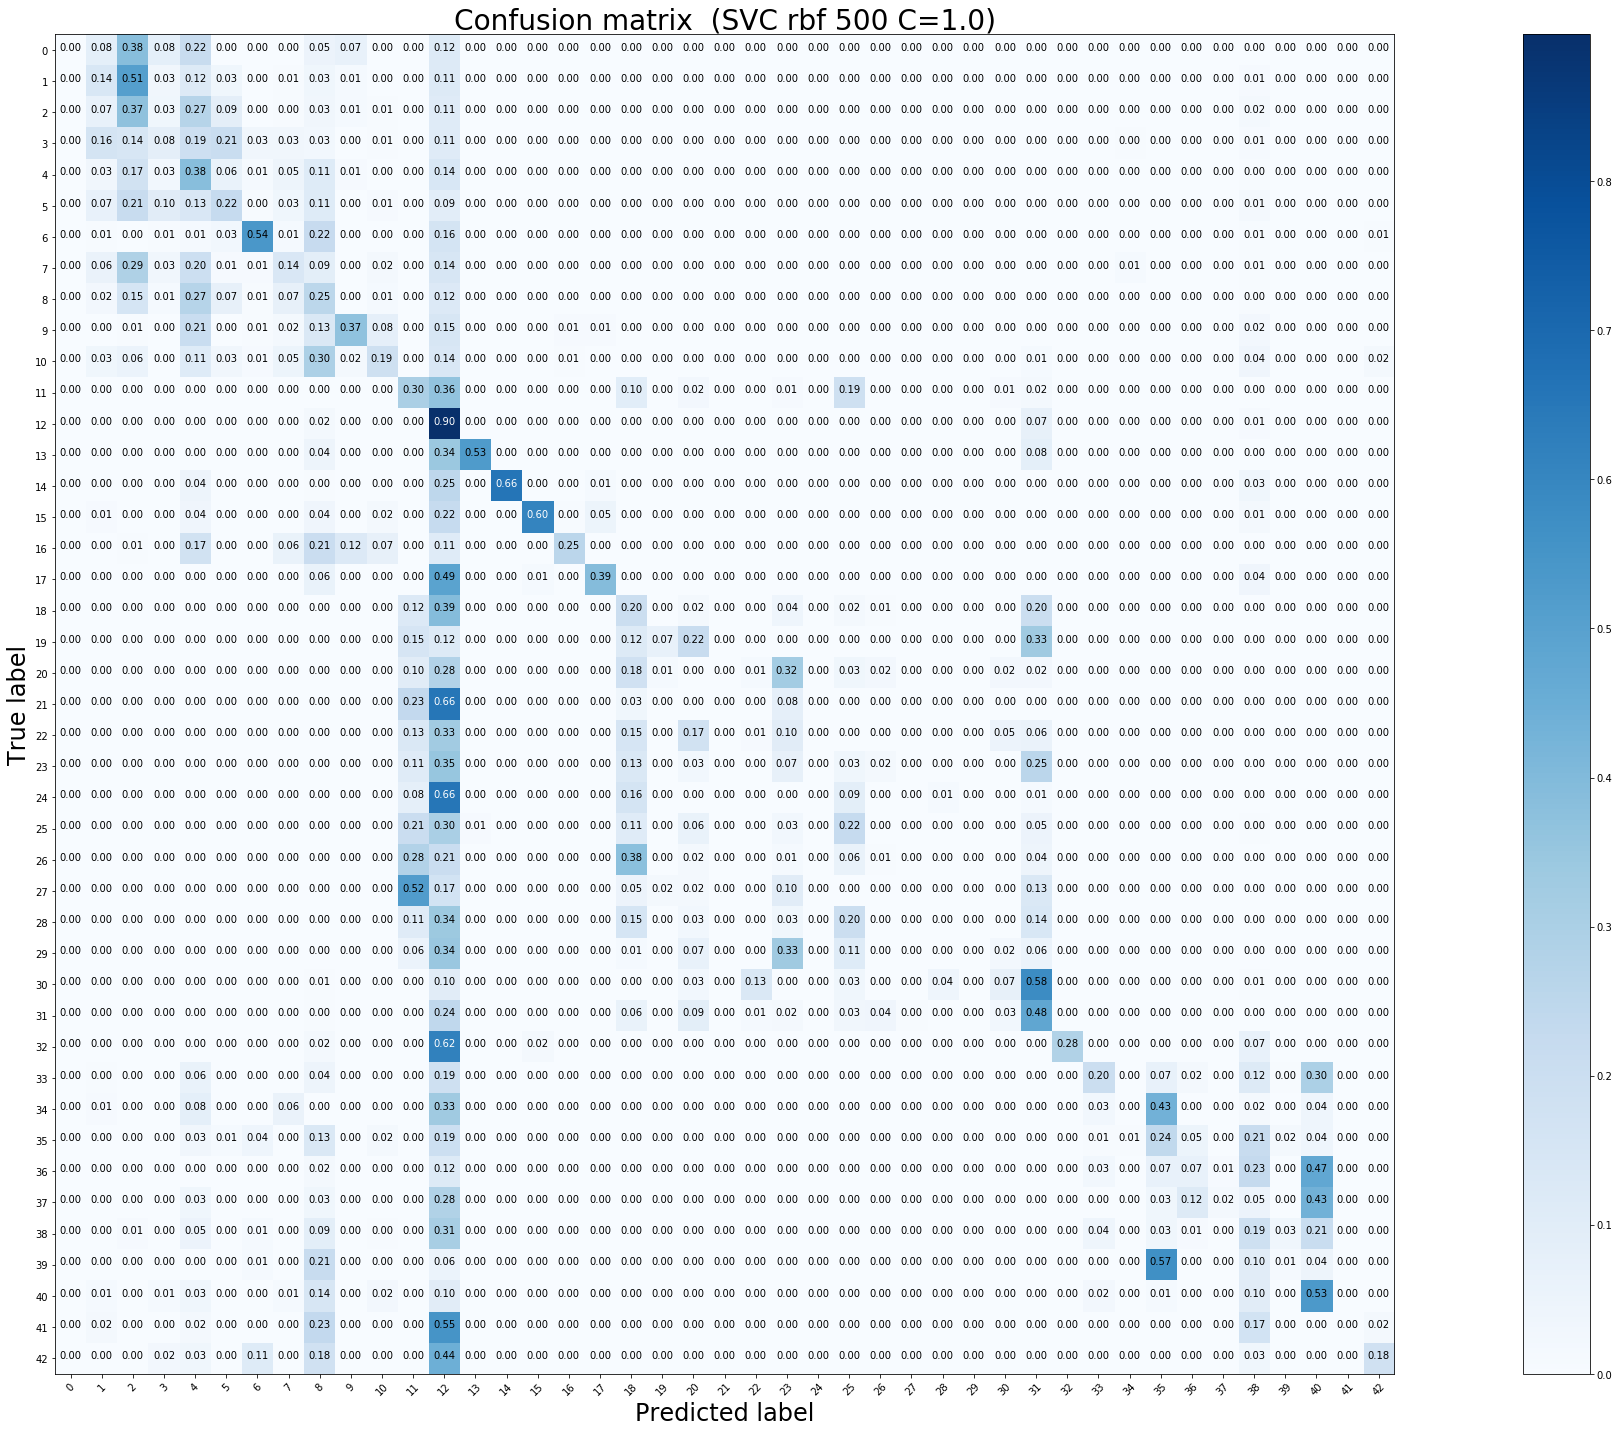

Test accuracy:  0.2906571654790182 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.29      0.14      0.19       720
           2       0.23      0.37      0.28       750
           3       0.19      0.08      0.12       450
           4       0.21      0.38      0.27       660
           5       0.33      0.22      0.26       630
           6       0.51      0.54      0.53       150
           7       0.27      0.14      0.18       450
           8       0.12      0.25      0.16       450
           9       0.75      0.37      0.49       480
          10       0.57      0.19      0.28       660
          11       0.28      0.30      0.29       420
          12       0.19      0.90      0.31       690
          13       0.99      0.53      0.69       720
          14       0.99      0.66      0.79       270
          15       0.96      0.60      0.74       210
          16       0.81      0.25      0.39 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

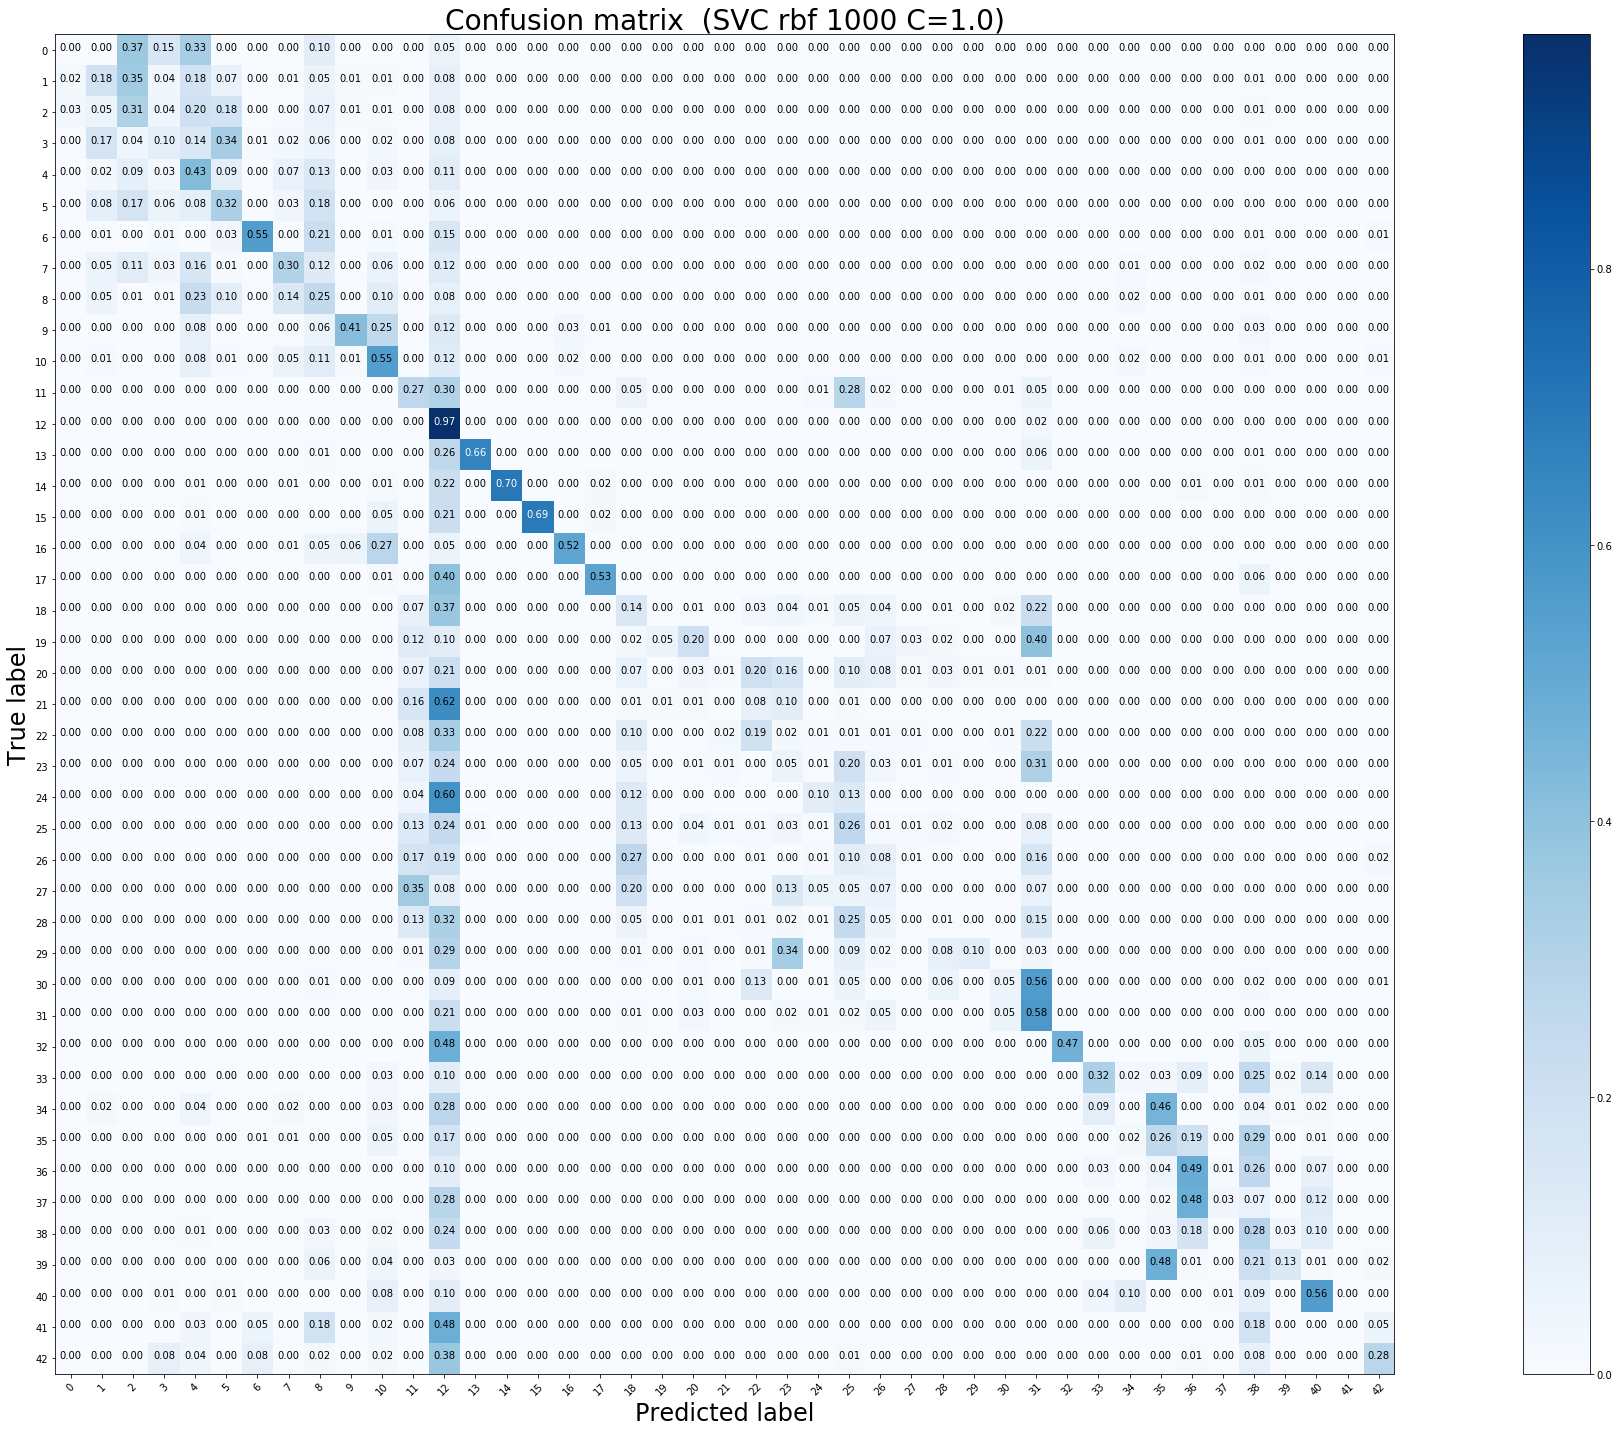

Test accuracy:  0.3639746634996041 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.36      0.18      0.24       720
           2       0.31      0.31      0.31       750
           3       0.22      0.10      0.14       450
           4       0.28      0.43      0.34       660
           5       0.31      0.32      0.31       630
           6       0.76      0.55      0.64       150
           7       0.42      0.30      0.35       450
           8       0.17      0.25      0.20       450
           9       0.87      0.41      0.56       480
          10       0.50      0.55      0.52       660
          11       0.34      0.27      0.30       420
          12       0.24      0.97      0.38       690
          13       0.99      0.66      0.79       720
          14       0.99      0.70      0.82       270
          15       0.99      0.69      0.81       210
          16       0.76      0.52      0.62 

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

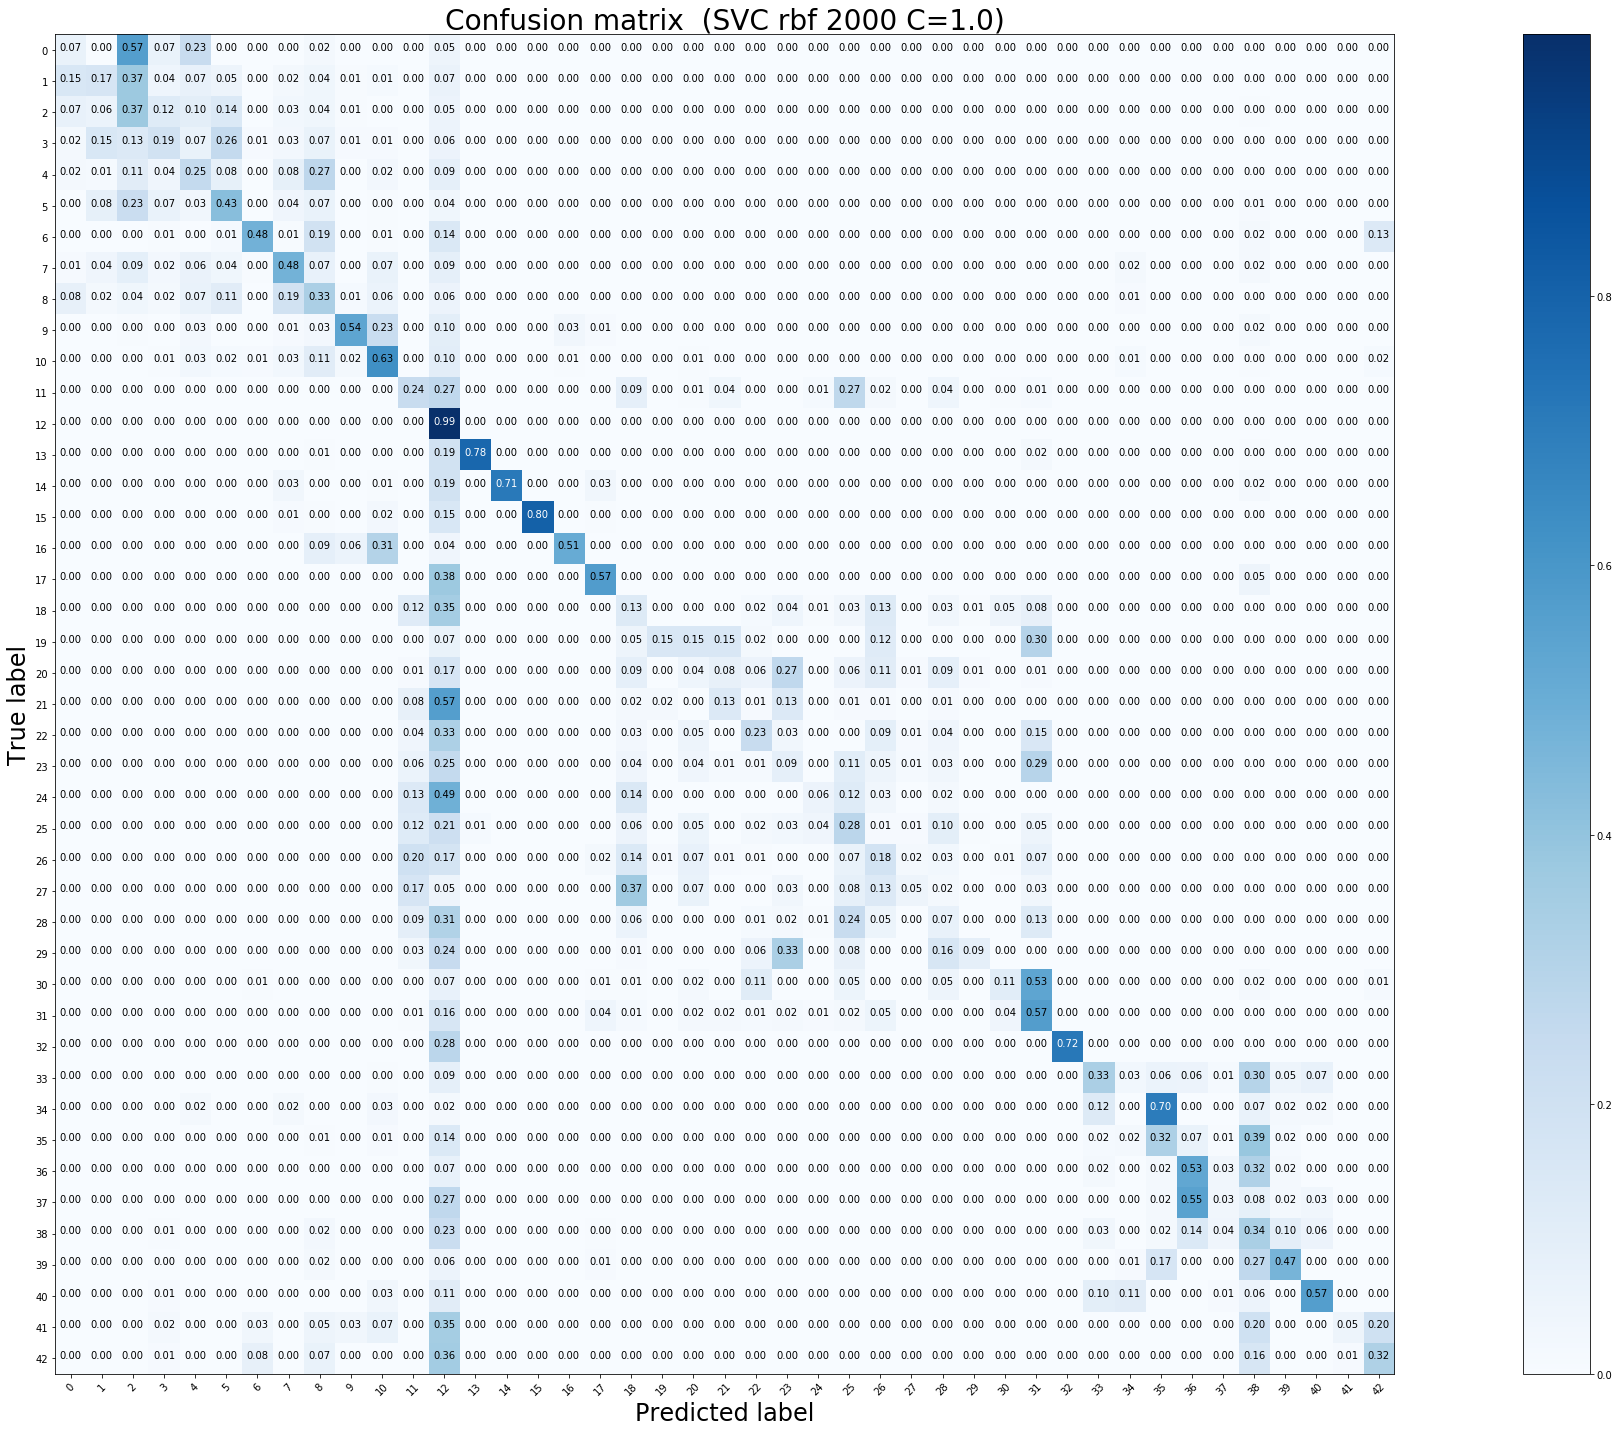

Test accuracy:  0.40902612826603324 

              precision    recall  f1-score   support

           0       0.02      0.07      0.03        60
           1       0.37      0.17      0.23       720
           2       0.31      0.37      0.34       750
           3       0.27      0.19      0.22       450
           4       0.37      0.25      0.30       660
           5       0.41      0.43      0.42       630
           6       0.71      0.48      0.57       150
           7       0.46      0.48      0.47       450
           8       0.23      0.33      0.27       450
           9       0.85      0.54      0.66       480
          10       0.60      0.63      0.61       660
          11       0.33      0.24      0.28       420
          12       0.28      0.99      0.43       690
          13       0.99      0.78      0.87       720
          14       1.00      0.71      0.83       270
          15       0.99      0.80      0.89       210
          16       0.76      0.51      0.61

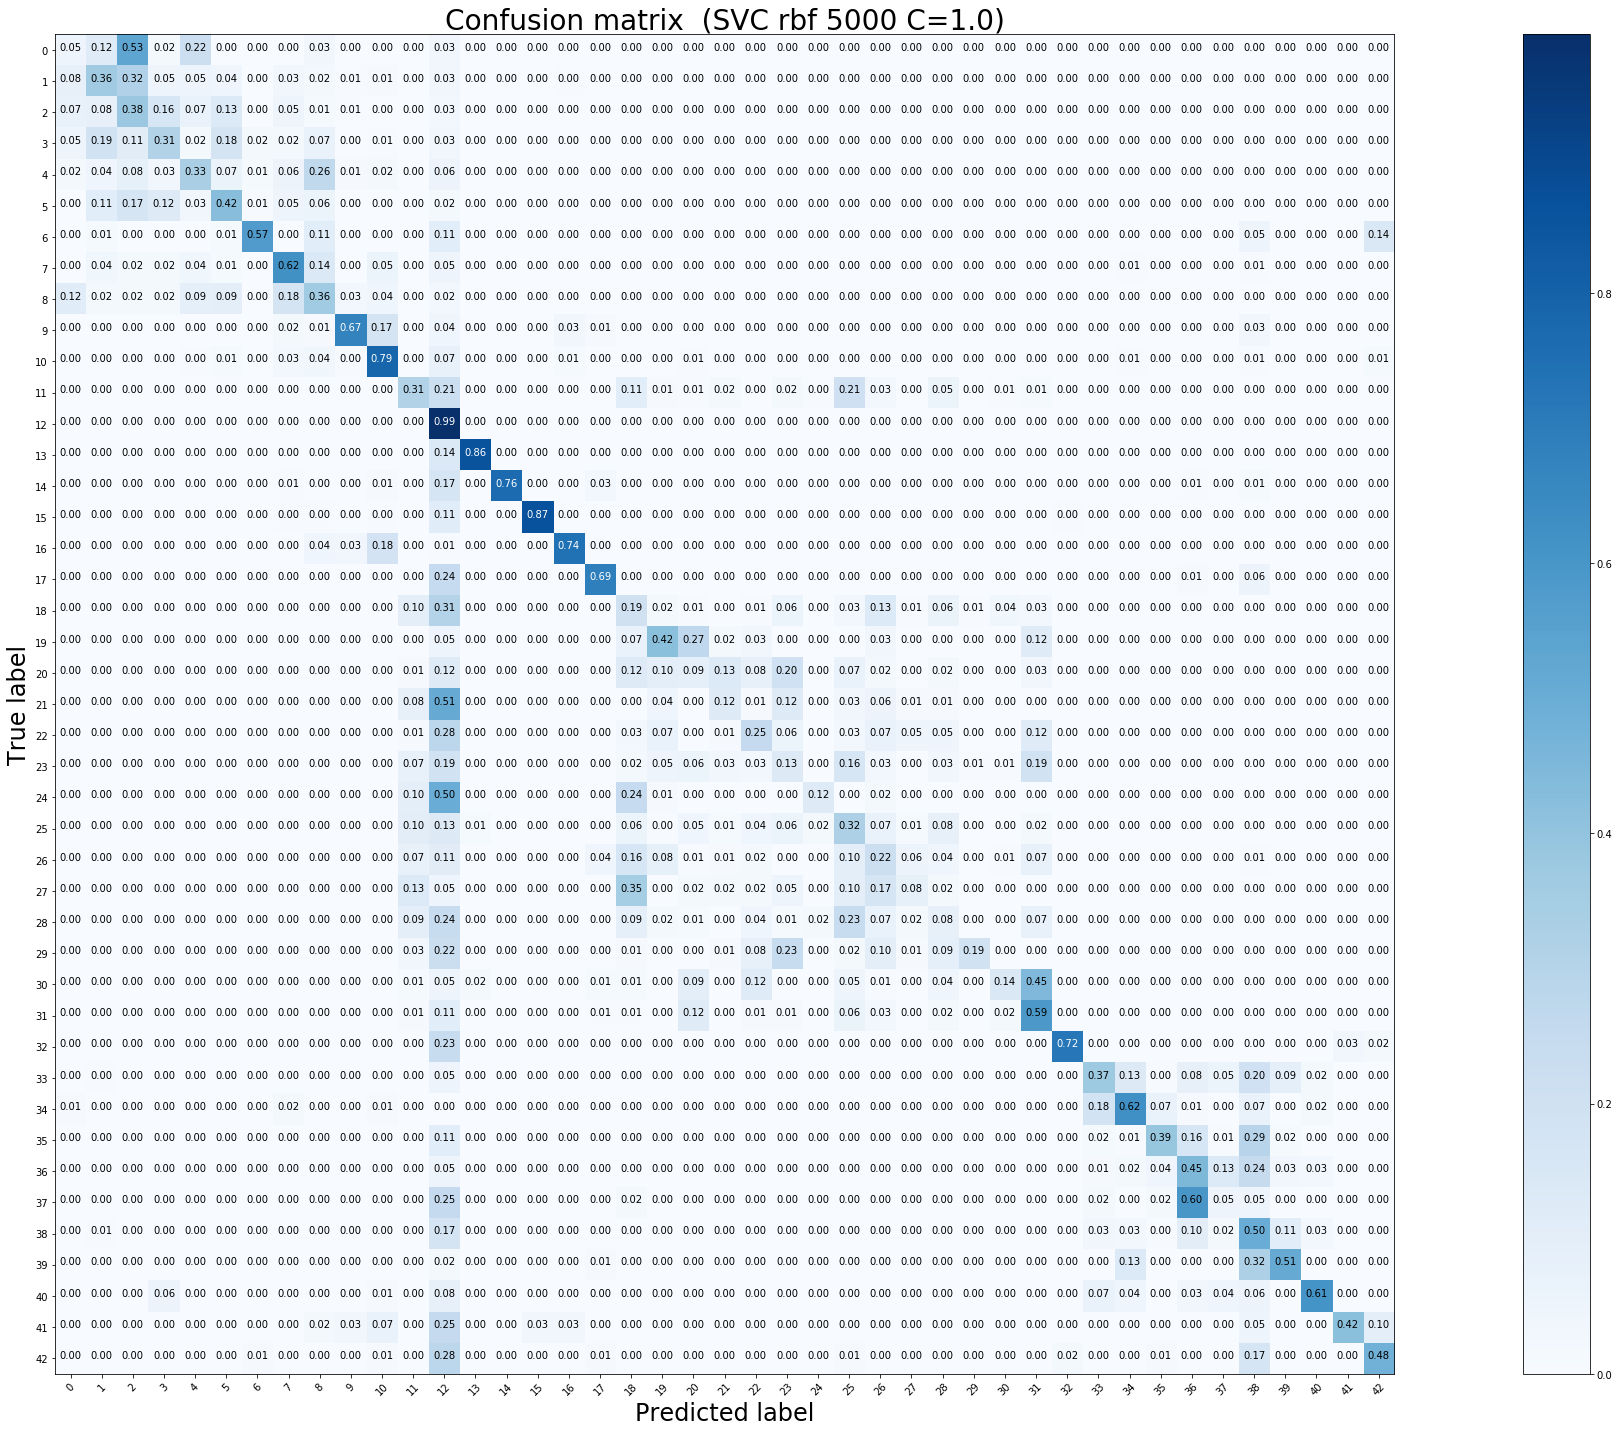

Test accuracy:  0.49311163895486937 

              precision    recall  f1-score   support

           0       0.01      0.05      0.02        60
           1       0.48      0.36      0.41       720
           2       0.37      0.38      0.37       750
           3       0.34      0.31      0.32       450
           4       0.53      0.33      0.41       660
           5       0.46      0.42      0.44       630
           6       0.77      0.57      0.66       150
           7       0.53      0.62      0.57       450
           8       0.30      0.36      0.33       450
           9       0.89      0.67      0.77       480
          10       0.73      0.79      0.76       660
          11       0.45      0.31      0.37       420
          12       0.35      0.99      0.51       690
          13       0.98      0.86      0.91       720
          14       1.00      0.76      0.87       270
          15       0.98      0.87      0.92       210
          16       0.80      0.74      0.77

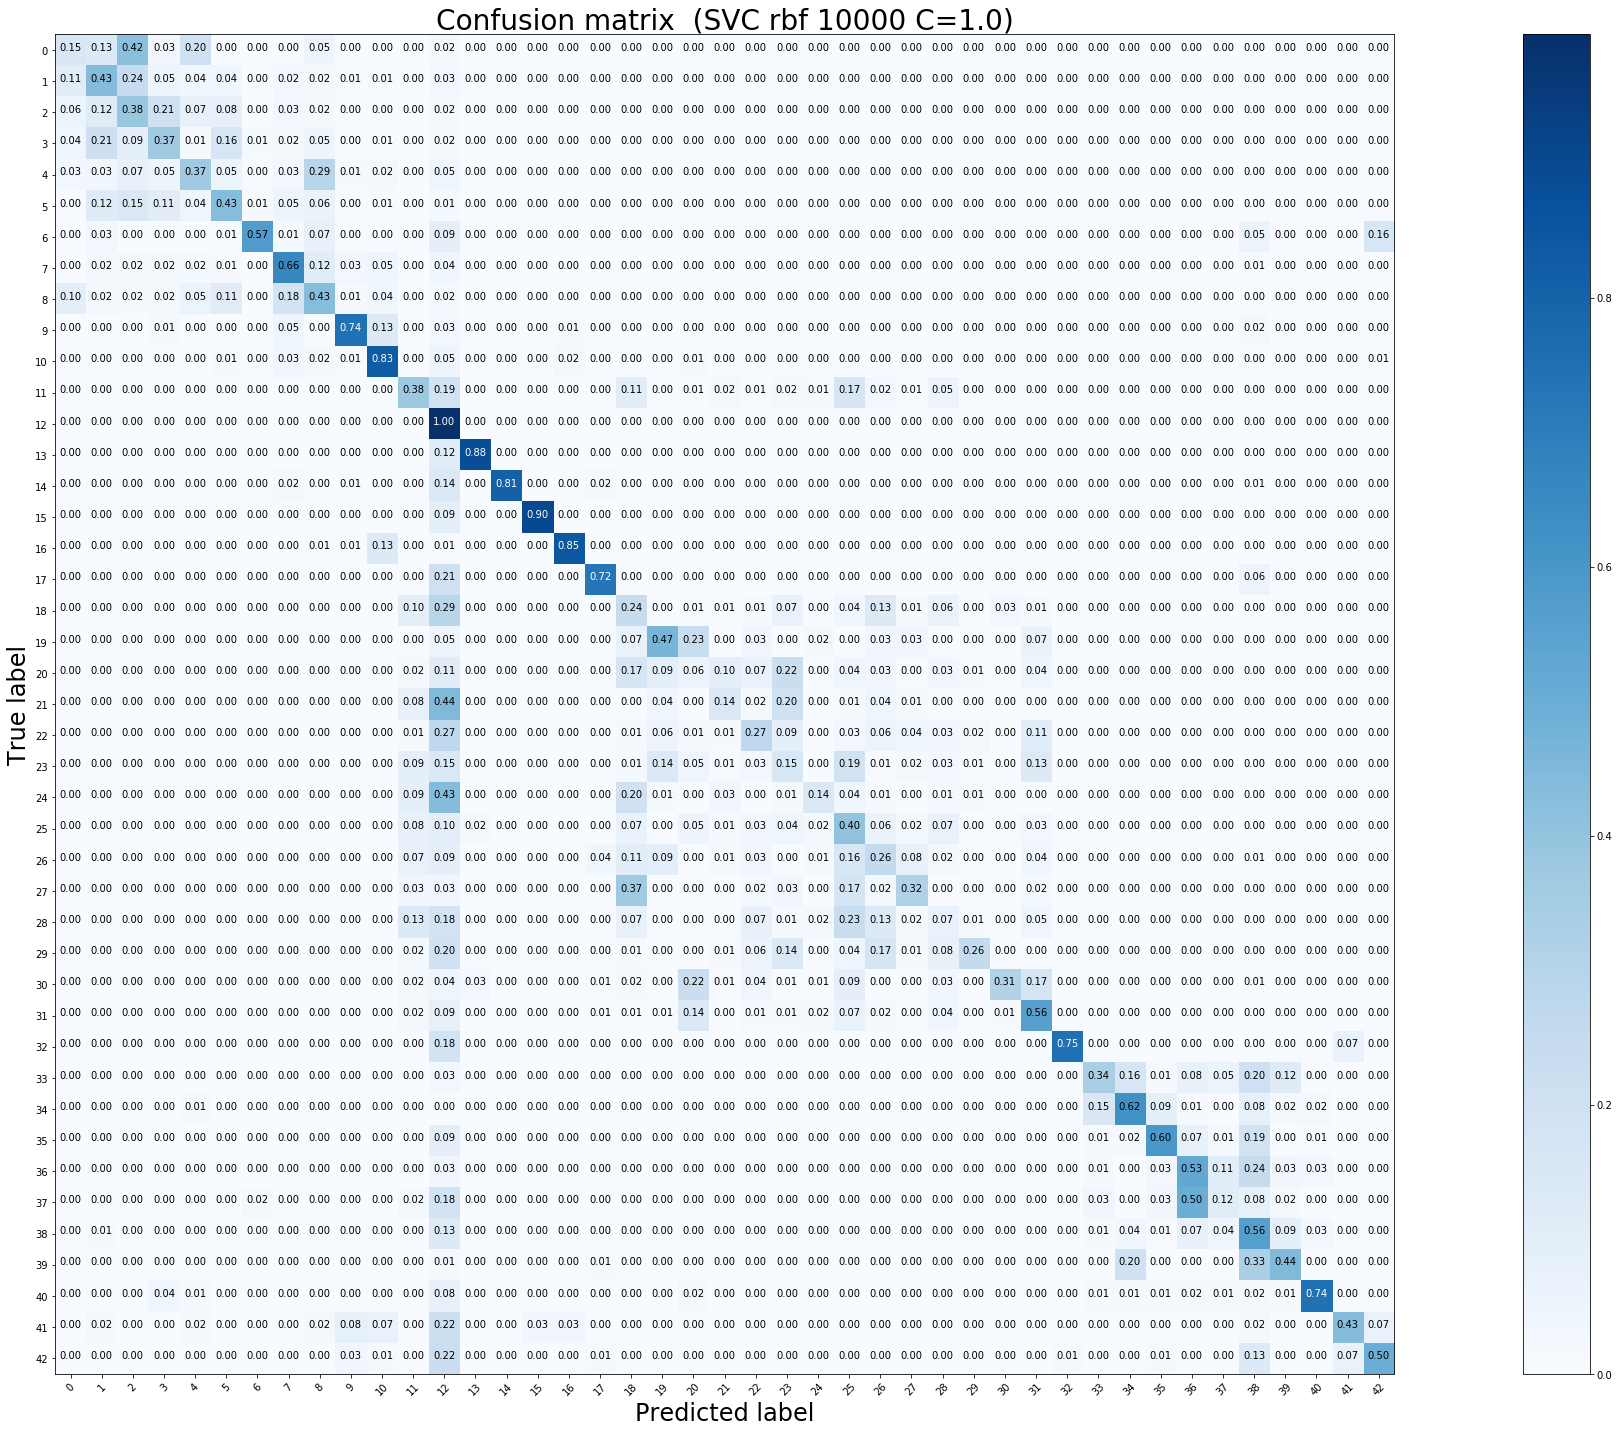

Test accuracy:  0.5380047505938242 

              precision    recall  f1-score   support

           0       0.04      0.15      0.07        60
           1       0.49      0.43      0.46       720
           2       0.42      0.38      0.40       750
           3       0.34      0.37      0.35       450
           4       0.60      0.37      0.46       660
           5       0.51      0.43      0.47       630
           6       0.82      0.57      0.67       150
           7       0.56      0.66      0.61       450
           8       0.35      0.43      0.38       450
           9       0.88      0.74      0.80       480
          10       0.79      0.83      0.81       660
          11       0.51      0.38      0.43       420
          12       0.39      1.00      0.56       690
          13       0.98      0.88      0.93       720
          14       1.00      0.81      0.89       270
          15       0.97      0.90      0.94       210
          16       0.85      0.85      0.85 

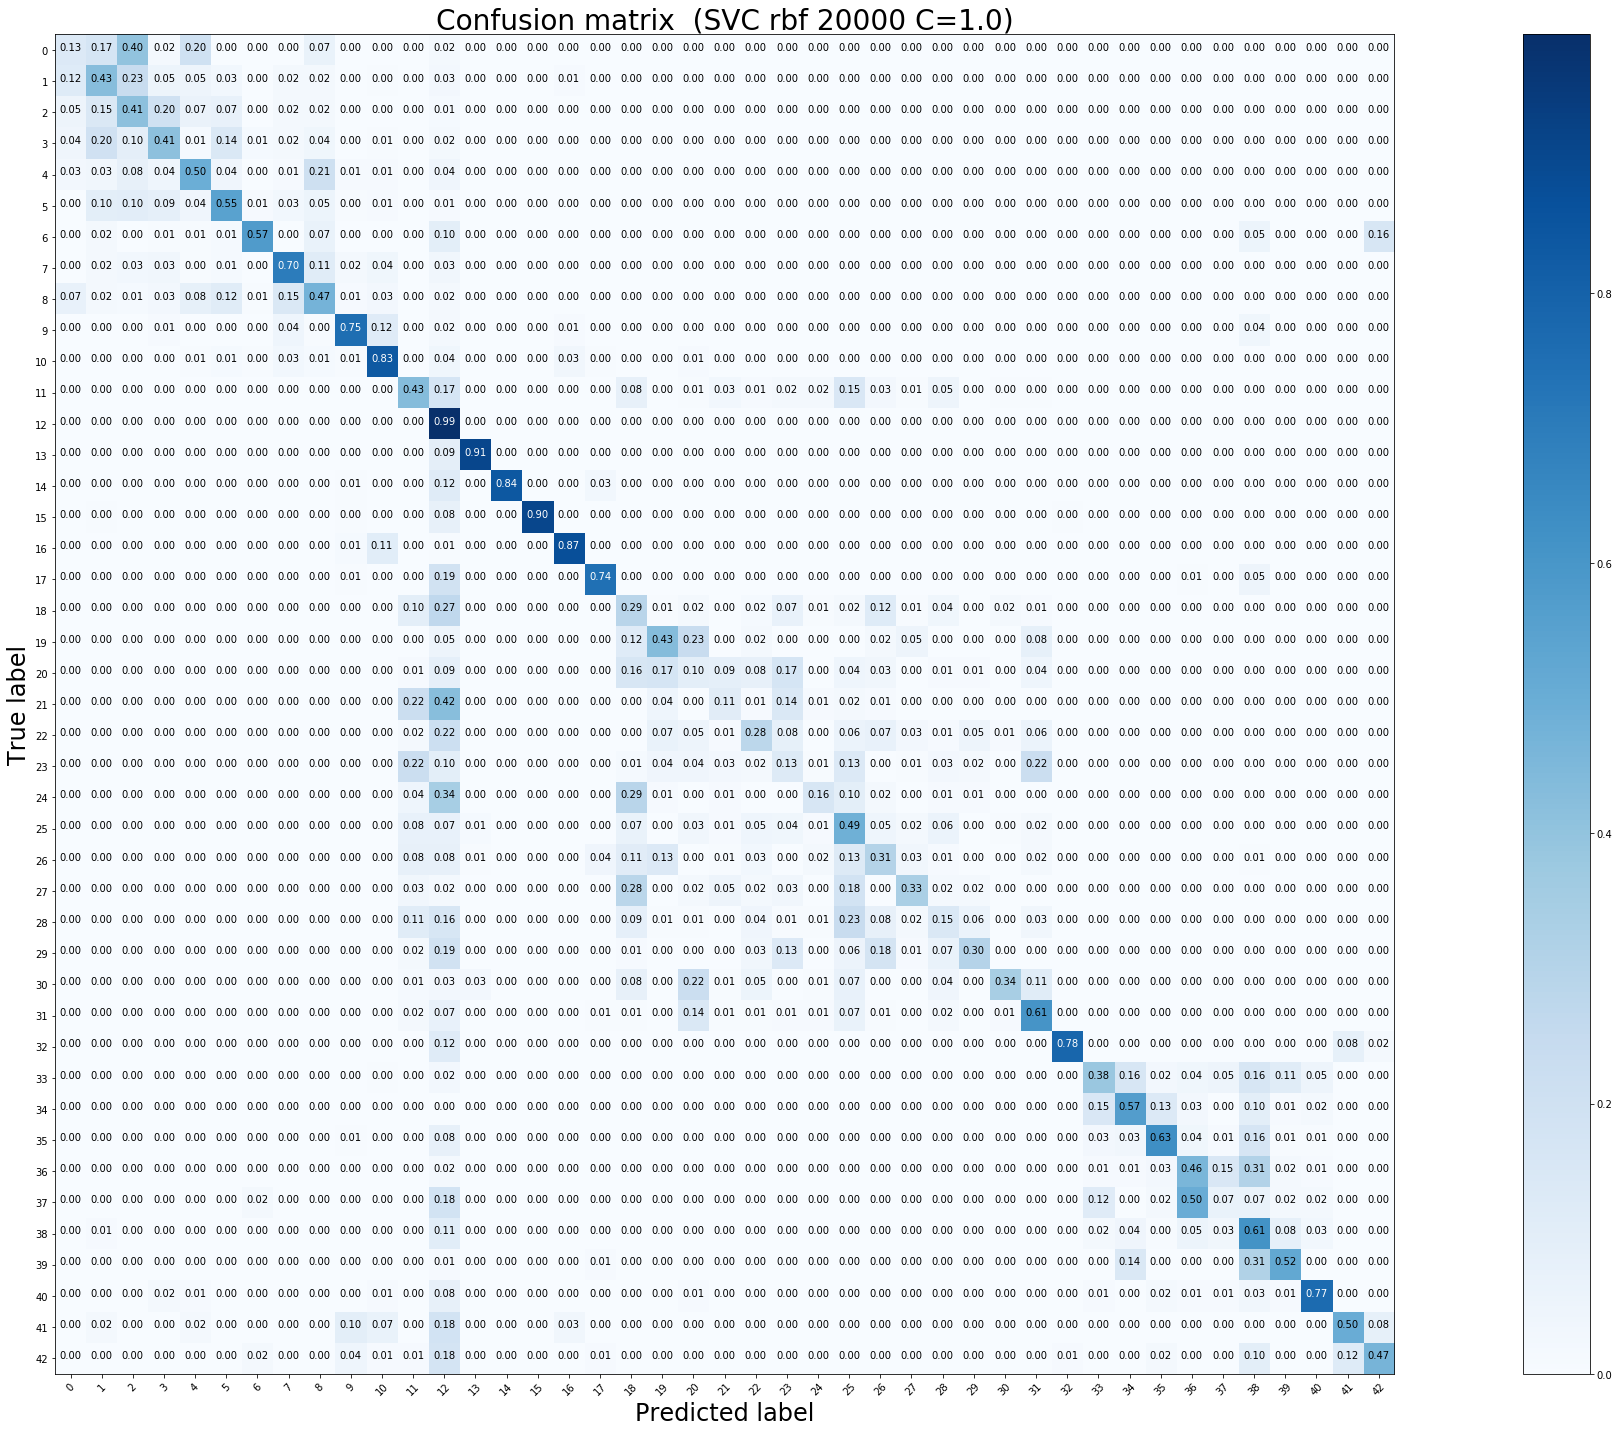

Test accuracy:  0.5737133808392716 

              precision    recall  f1-score   support

           0       0.04      0.13      0.06        60
           1       0.49      0.43      0.46       720
           2       0.45      0.41      0.43       750
           3       0.37      0.41      0.39       450
           4       0.65      0.50      0.56       660
           5       0.60      0.55      0.57       630
           6       0.80      0.57      0.67       150
           7       0.65      0.70      0.67       450
           8       0.42      0.47      0.44       450
           9       0.88      0.75      0.81       480
          10       0.81      0.83      0.82       660
          11       0.50      0.43      0.46       420
          12       0.43      0.99      0.60       690
          13       0.98      0.91      0.94       720
          14       1.00      0.84      0.91       270
          15       0.99      0.90      0.95       210
          16       0.79      0.87      0.83 

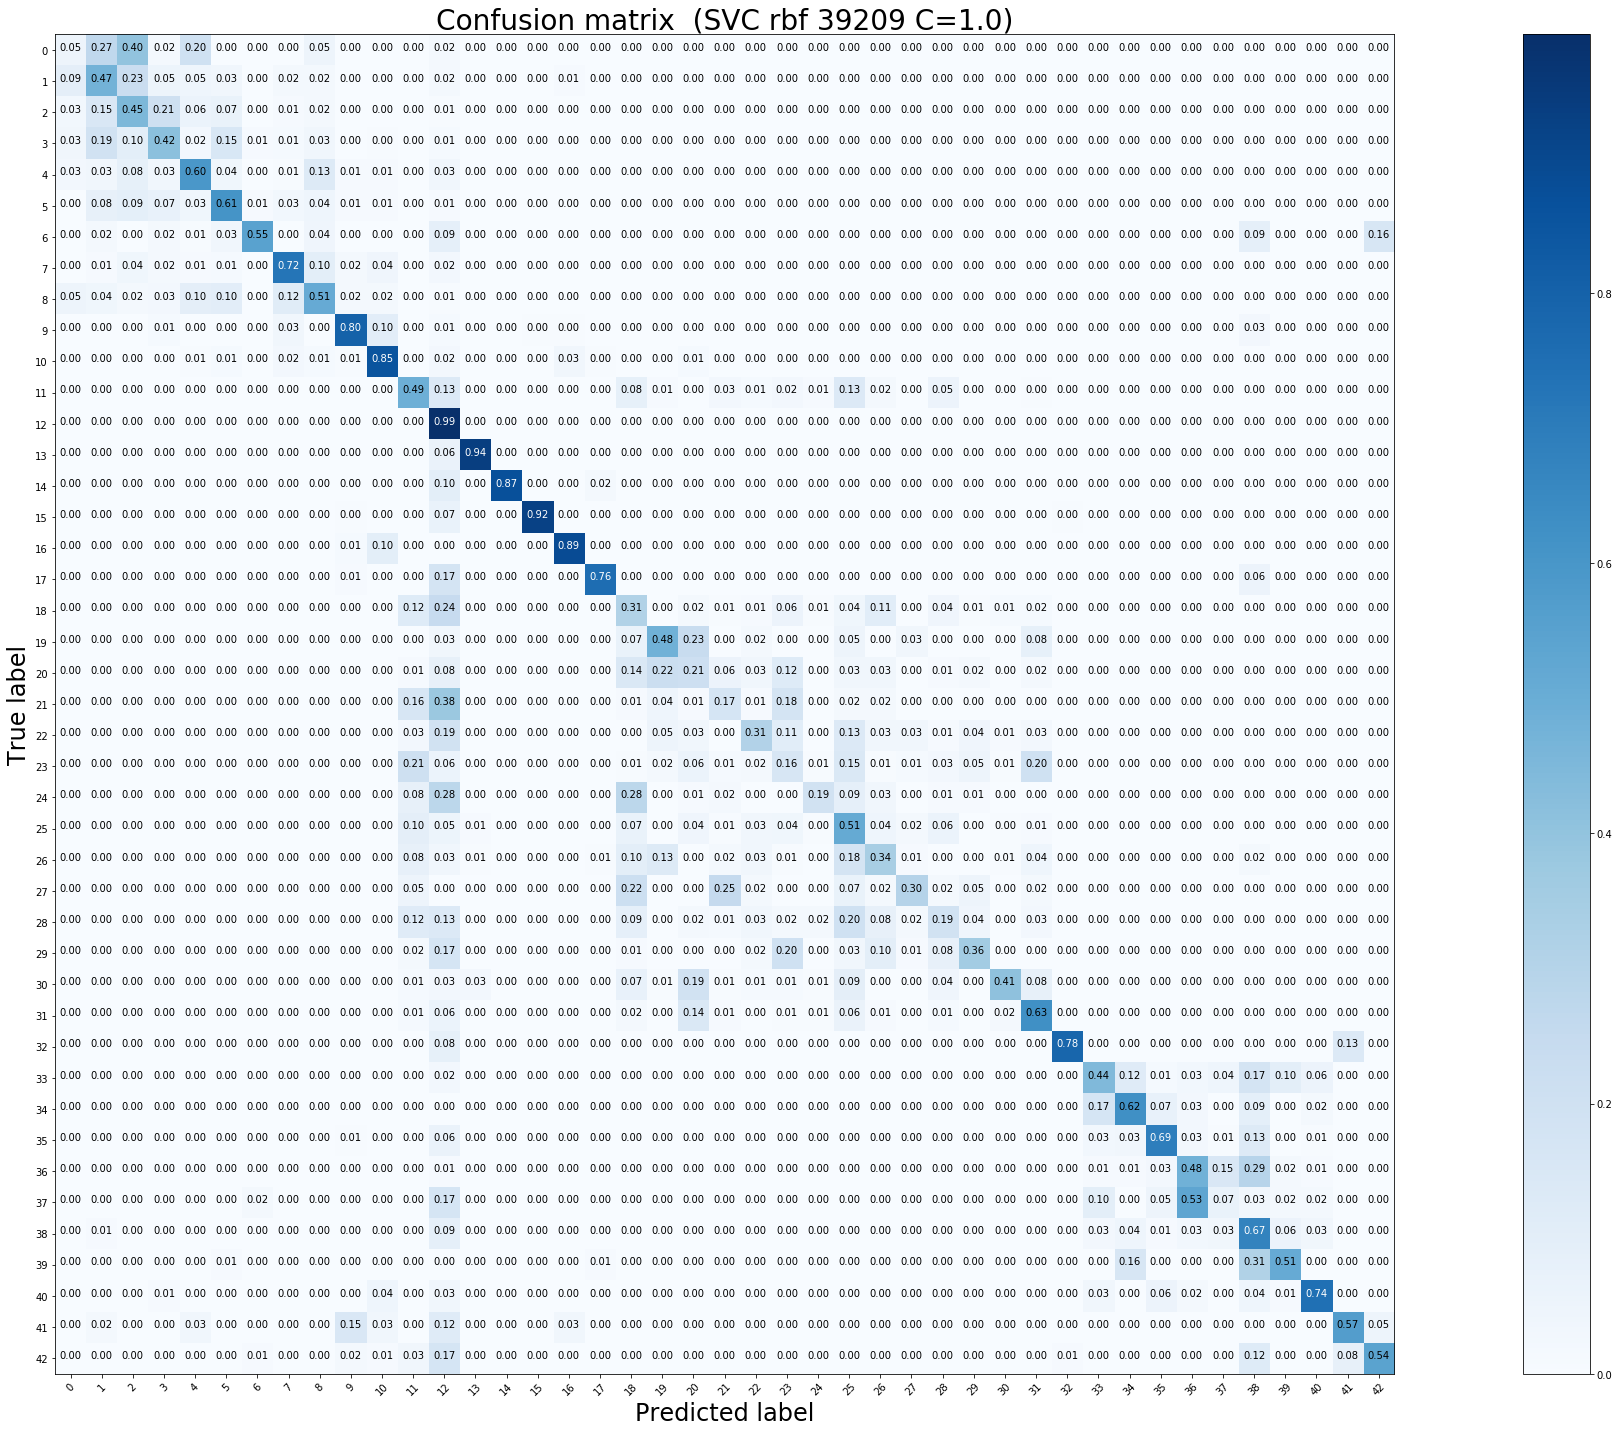

Test accuracy:  0.6109263657957245 

              precision    recall  f1-score   support

           0       0.02      0.05      0.03        60
           1       0.52      0.47      0.49       720
           2       0.48      0.45      0.46       750
           3       0.39      0.42      0.40       450
           4       0.69      0.60      0.64       660
           5       0.62      0.61      0.61       630
           6       0.85      0.55      0.66       150
           7       0.71      0.72      0.72       450
           8       0.52      0.51      0.51       450
           9       0.87      0.80      0.84       480
          10       0.83      0.85      0.84       660
          11       0.51      0.49      0.50       420
          12       0.49      0.99      0.65       690
          13       0.98      0.94      0.96       720
          14       1.00      0.87      0.93       270
          15       0.97      0.92      0.95       210
          16       0.81      0.89      0.84 

In [20]:
##############################################################################
###########   SVC RBF, HOG, seed=1, random_A, with_scaler ###############
##############################################################################

train_RBF_SVC(X_tr_500, X_test_vgg16, y_tr_500, y_test, 1, '500',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr_1000, X_test_vgg16, y_tr_1000, y_test, 1, '1000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr_2000, X_test_vgg16, y_tr_2000, y_test, 1, '2000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr_5000, X_test_vgg16, y_tr_5000, y_test, 1, '5000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr_10000, X_test_vgg16, y_tr_10000, y_test, 1, '10000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr_20000, X_test_vgg16, y_tr_20000, y_test, 1, '20000',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")
train_RBF_SVC(X_tr, X_test_vgg16, y_tr, y_test, 1, '39209',1.0, 'auto', 2, 0, 'ovo', 'balanced',
               "SVM_Modelle_GTSRB/VGG16_default/rbf/Neue Mengen/", "seed_1_random_A_with_scaler", "VGG16_balanced.pkl")

In [27]:
#################################################################################################
################## GridSearch SVC RBF, hinge     ##################################
#################################################################################################
################### 1. DL #######################################################################
#################################################################################################

clf_500_RBF, time_500_RBF = tuning_hyper_params(X_tr_500, y_tr_500, X_test_vgg16, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,12,15, base=2), np.logspace(-16,4,11, base=2), 'l2', 'hinge', 1)
save_trained_model_as_pkl(clf_500_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_500_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/500/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_1000_RBF, time_1000_RBF = tuning_hyper_params(X_tr_1000, y_tr_1000, X_test_vgg16, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,12,15, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_1000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_1000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/1000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_2000_RBF, time_2000_RBF = tuning_hyper_params(X_tr_2000, y_tr_2000, X_test_vgg16, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,12,15, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_2000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/2000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_2000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/2000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

clf_5000_RBF, time_5000_RBF = tuning_hyper_params(X_tr_5000, y_tr_5000, X_test_vgg16, y_test, 'rbf', 10, 2, 0, 
                                                np.logspace(-16,12,15, base=2), np.logspace(-16,4,11, base=2),'l2', 'hinge',1)
save_trained_model_as_pkl(clf_5000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/5000/seed_1_random_A_with_scaler/GridSearch_1DL.pkl")
save_as_csv(time_5000_RBF, "SVM_Modelle_GTSRB/VGG16_opt/rbf/Neue Mengen/5000/seed_1_random_A_with_scaler/", 'Suchzeiten_GridSearch_1_DL.csv')

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03
 4.096e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.3844528501491972

 Besten Parameter:  {'svm__C': 1024.0, 'svm__gamma': 6.103515625e-05}
Bester Estimator score:  0.44045922406967536
Precision-Score: 0.019760 (0.020444) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.018998 (0.020218) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.019341 (0.020046) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.011481 (0.015577) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.007560 (0.009327) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0039062

Accuracy-Score: 0.056000 (0.012309) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 1.0}
Accuracy-Score: 0.056000 (0.012309) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 4.0}
Accuracy-Score: 0.060000 (0.022080) mit Parameter: {'svm__C': 64.0, 'svm__gamma': 16.0}
Accuracy-Score: 0.442000 (0.066113) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 1.52587890625e-05}
Accuracy-Score: 0.482000 (0.082009) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 6.103515625e-05}
Accuracy-Score: 0.492000 (0.083973) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 0.000244140625}
Accuracy-Score: 0.466000 (0.082560) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 0.0009765625}
Accuracy-Score: 0.408000 (0.107384) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 0.00390625}
Accuracy-Score: 0.254000 (0.070479) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 0.015625}
Accuracy-Score: 0.104000 (0.043435) mit Parameter: {'svm__C': 256.0, 'svm__gamma': 0.0625}
Accuracy-Score: 0.062000 (0.015657) mit Parameter: {'svm__C':

C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03
 4.096e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.45060716971507153

 Besten Parameter:  {'svm__C': 1024.0, 'svm__gamma': 6.103515625e-05}
Bester Estimator score:  0.4840855106888361
Precision-Score: 0.010438 (0.010649) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.009195 (0.009421) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.008262 (0.009257) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.009828 (0.010012) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.010595 (0.011752) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0039062


 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03
 4.096e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.5811780758786212

 Besten Parameter:  {'svm__C': 1024.0, 'svm__gamma': 0.000244140625}
Bester Estimator score:  0.542042755344418
Precision-Score: 0.001759 (0.001917) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.003026 (0.003601) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.004054 (0.005525) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.005200 (0.008760) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.003672 (0.003635) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.00390625}



 C_range:  [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03
 4.096e+03]

 gamma_range: [1.526e-05 6.104e-05 2.441e-04 9.766e-04 3.906e-03 1.562e-02 6.250e-02
 2.500e-01 1.000e+00 4.000e+00 1.600e+01]

 Beste Score:  0.7196031301031842

 Besten Parameter:  {'svm__C': 64.0, 'svm__gamma': 0.0009765625}
Bester Estimator score:  0.5939034045922407
Precision-Score: 0.001640 (0.001087) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 1.52587890625e-05}
Precision-Score: 0.001452 (0.000792) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 6.103515625e-05}
Precision-Score: 0.001600 (0.000807) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.000244140625}
Precision-Score: 0.001349 (0.000600) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.0009765625}
Precision-Score: 0.001439 (0.000956) mit Parameter: {'svm__C': 1.52587890625e-05, 'svm__gamma': 0.00390625}
Pre

In [26]:
np.logspace(-16,12,15, base=2)

array([1.526e-05, 6.104e-05, 2.441e-04, 9.766e-04, 3.906e-03, 1.562e-02,
       6.250e-02, 2.500e-01, 1.000e+00, 4.000e+00, 1.600e+01, 6.400e+01,
       2.560e+02, 1.024e+03, 4.096e+03])

In [ ]:
# 500      C=1024, gamma=6.103515625e-05
# 1000     C=1024, gamma=6.103515625e-05

#C = 64, gamma = 0.0009765625